In [40]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("alessiocorrado99/animals10")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Евгений\.cache\kagglehub\datasets\alessiocorrado99\animals10\versions\2


In [41]:
!pip install torchinfo

In [42]:
import torch
import torchvision
from torch import nn, optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torchinfo import summary
import numpy as np
import matplotlib.pyplot as plt

Определяем утройство, у меня установлена видеокарта nvidia  с тензовными ядрами, так что обучение будет идти паралельно и очень быстро

In [43]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Все данные должны быть преобразованны в "тензор", причеем все они должны быть нормализованы, загрузим набор данных

In [44]:
transform = transforms.Compose([
    transforms.Resize((300,300)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [45]:
path = "C:/Users/Евгений/.cache/kagglehub/datasets/alessiocorrado99/animals10/versions/2"

In [46]:
import os

# Укажите путь к папке raw-img
raw_img_path = "C:/Users/Евгений/.cache/kagglehub/datasets/alessiocorrado99/animals10/versions/2/raw-img"

# Выводим содержимое папки raw-img
if os.path.exists(raw_img_path):
    print("Содержимое папки raw-img:")
    for entry in os.scandir(raw_img_path):
        print(entry.name)
else:
    print("Папка raw-img не существует!")

Содержимое папки raw-img:
cane
cavallo
elefante
farfalla
gallina
gatto
mucca
pecora
ragno
scoiattolo


In [47]:
full_dataset = datasets.ImageFolder(os.path.join(path, 'raw-img'))

Ну и конечно же выборки должны быть разделены

Как видно, модель разделена на 20 процентов  тестовой и 8 процентов обучающей выборки, они же перемешиваются

In [48]:
from sklearn.model_selection import train_test_split
train_indices, test_indices = train_test_split(
    range(len(full_dataset)),
    train_size=0.8,
    stratify=full_dataset.targets,  # Стратификация по классам (если нужно)
    random_state=42
)

# Создание подмножеств с разными преобразованиями
train_dataset = datasets.ImageFolder(
    root=os.path.join(path, 'raw-img'),
    transform=train_transform
)
train_dataset.samples = [full_dataset.samples[i] for i in train_indices]
train_dataset.targets = [full_dataset.targets[i] for i in train_indices]

test_dataset = datasets.ImageFolder(
    root=os.path.join(path, 'raw-img'),
    transform=transform
)
test_dataset.samples = [full_dataset.samples[i] for i in test_indices]
test_dataset.targets = [full_dataset.targets[i] for i in test_indices]

# Создание DataLoader'ов
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

Так как датасет испанский, я переведу на русский

In [49]:
translate = {
    "cane": "собака", 
    "cavallo": "лошадь", 
    "elefante": "слон", 
    "farfalla": "бабочка", 
    "gallina": "курица", 
    "gatto": "кошка", 
    "mucca": "корова", 
    "pecora": "овца", 
    "ragno": "паук", 
    "scoiattolo": "белка"
}

In [50]:
class_names = full_dataset.classes
translated_class_names = [translate[name] for name in class_names]

In [51]:
for original, translated in zip(class_names, translated_class_names):
    print(f"{original} -> {translated}")

cane -> собака
cavallo -> лошадь
elefante -> слон
farfalla -> бабочка
gallina -> курица
gatto -> кошка
mucca -> корова
pecora -> овца
ragno -> паук
scoiattolo -> белка


In [52]:
def imshow(img):
    # Преобразуем тензор в numpy массив
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img * std[:, None, None] + mean[:, None, None]
    npimg = img.numpy()
    # Меняем порядок каналов с CxHxW на HxWxC
    npimg = np.transpose(npimg, (1, 2, 0))
    # Если изображения нормализованы, нужно выполнить денормализацию
    # npimg = npimg * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    plt.imshow(npimg)
    plt.axis('off')

In [53]:
images, labels = next(iter(test_loader))

Отобразим

In [54]:
images[4].shape

torch.Size([3, 300, 300])

C:\Users\Евгений\AppData\Local\Temp\ipykernel_28624\361754869.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  img = img * std[:, None, None] + mean[:, None, None]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..1.0000000076293944].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..1.0000000236034394].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [2.7418136649970393e-09..1.0000000236034394].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..1.0000000076293944].
Clipping input data to the valid range for imshow with RGB data ([0..1] for f

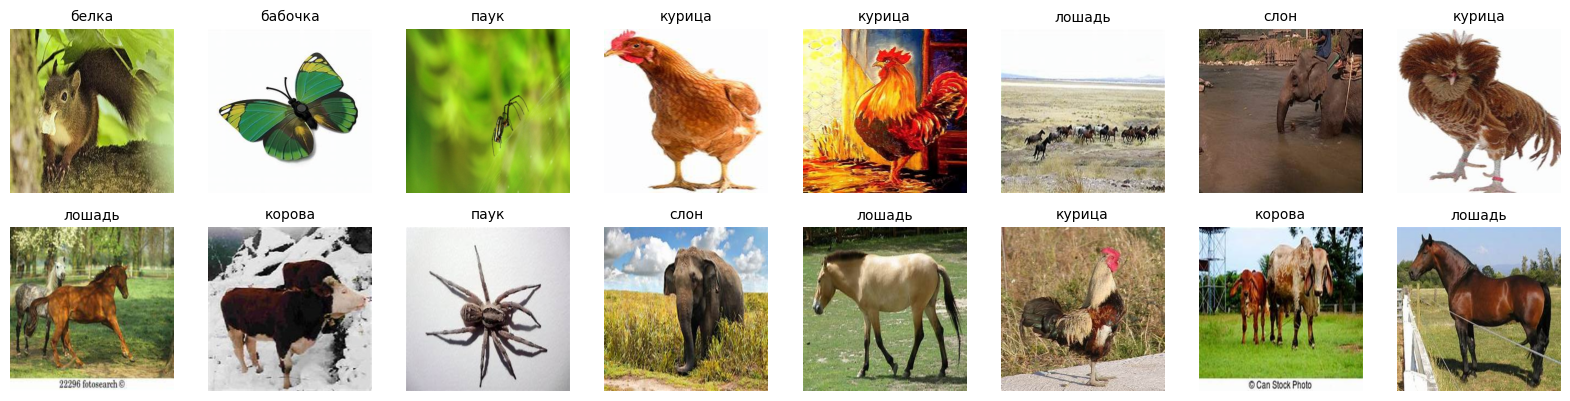

In [55]:
rows = 8  # Количество строк
cols = 8  # Количество столбцов

plt.figure(figsize=(16, 16))  # Увеличиваем размер фигуры
for i in range(len(images[:16])):
    plt.subplot(rows, cols, i + 1)  # Создаем сетку 8x8
    imshow(images[i] )
    # Получаем название класса по индексу метки
    plt.title(translated_class_names[labels[i]], fontsize=10)
    plt.axis('off')  # Скрываем оси
plt.tight_layout()
plt.show()

Создадим архитектуру нейросети


In [56]:
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

<p data-spm-anchor-id="a2ty_o01.29997173.0.i8.7df05171UNgjUK">Функции активации — это математические функции, которые добавляются к нейронным сетям для введения нелинейности. Без функций активации нейронная сеть была бы просто линейной комбинацией входных данных, что сильно ограничивало бы её способность решать сложные задачи. </p>

<h3><strong>Популярные функции активации </strong> </h3>

<h4>a) <strong>ReLU (Rectified Linear Unit) </strong> </h4>
<span class="katex-display"><span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><mi>f</mi><mo stretchy="false">(</mo><mi>x</mi><mo stretchy="false">)</mo><mo>=</mo><mi>max</mi><mo>⁡</mo><mo stretchy="false">(</mo><mn>0</mn><mo separator="true">,</mo><mi>x</mi><mo stretchy="false">)</mo></mrow><annotation encoding="application/x-tex">f(x) = \max(0, x)</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:1em;vertical-align:-0.25em;"></span><span class="mord mathnormal" style="margin-right:0.10764em;">f</span><span class="mopen">(</span><span class="mord mathnormal">x</span><span class="mclose">)</span><span class="mspace" style="margin-right:0.2778em;"></span><span class="mrel">=</span><span class="mspace" style="margin-right:0.2778em;"></span></span><span class="base"><span class="strut" style="height:1em;vertical-align:-0.25em;"></span><span class="mop">max</span><span class="mopen">(</span><span class="mord">0</span><span class="mpunct">,</span><span class="mspace" style="margin-right:0.1667em;"></span><span class="mord mathnormal">x</span><span class="mclose">)</span></span></span></span></span>
<ul><li>Простота вычислений.</li><li>Устраняет проблему затухающих градиентов для положительных значений.</li> </ul>
<ul><li>"Мёртвые нейроны": Нейроны, для которых <span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>x</mi><mo>&lt;</mo><mn>0</mn></mrow><annotation encoding="application/x-tex"> x &lt; 0</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.5782em;vertical-align:-0.0391em;"></span><span class="mord mathnormal">x</span><span class="mspace" style="margin-right:0.2778em;"></span><span class="mrel">&lt;</span><span class="mspace" style="margin-right:0.2778em;"></span></span><span class="base"><span class="strut" style="height:0.6444em;"></span><span class="mord">0</span></span></span></span>, никогда не активируются, так как их градиент равен нулю.</li> </ul>

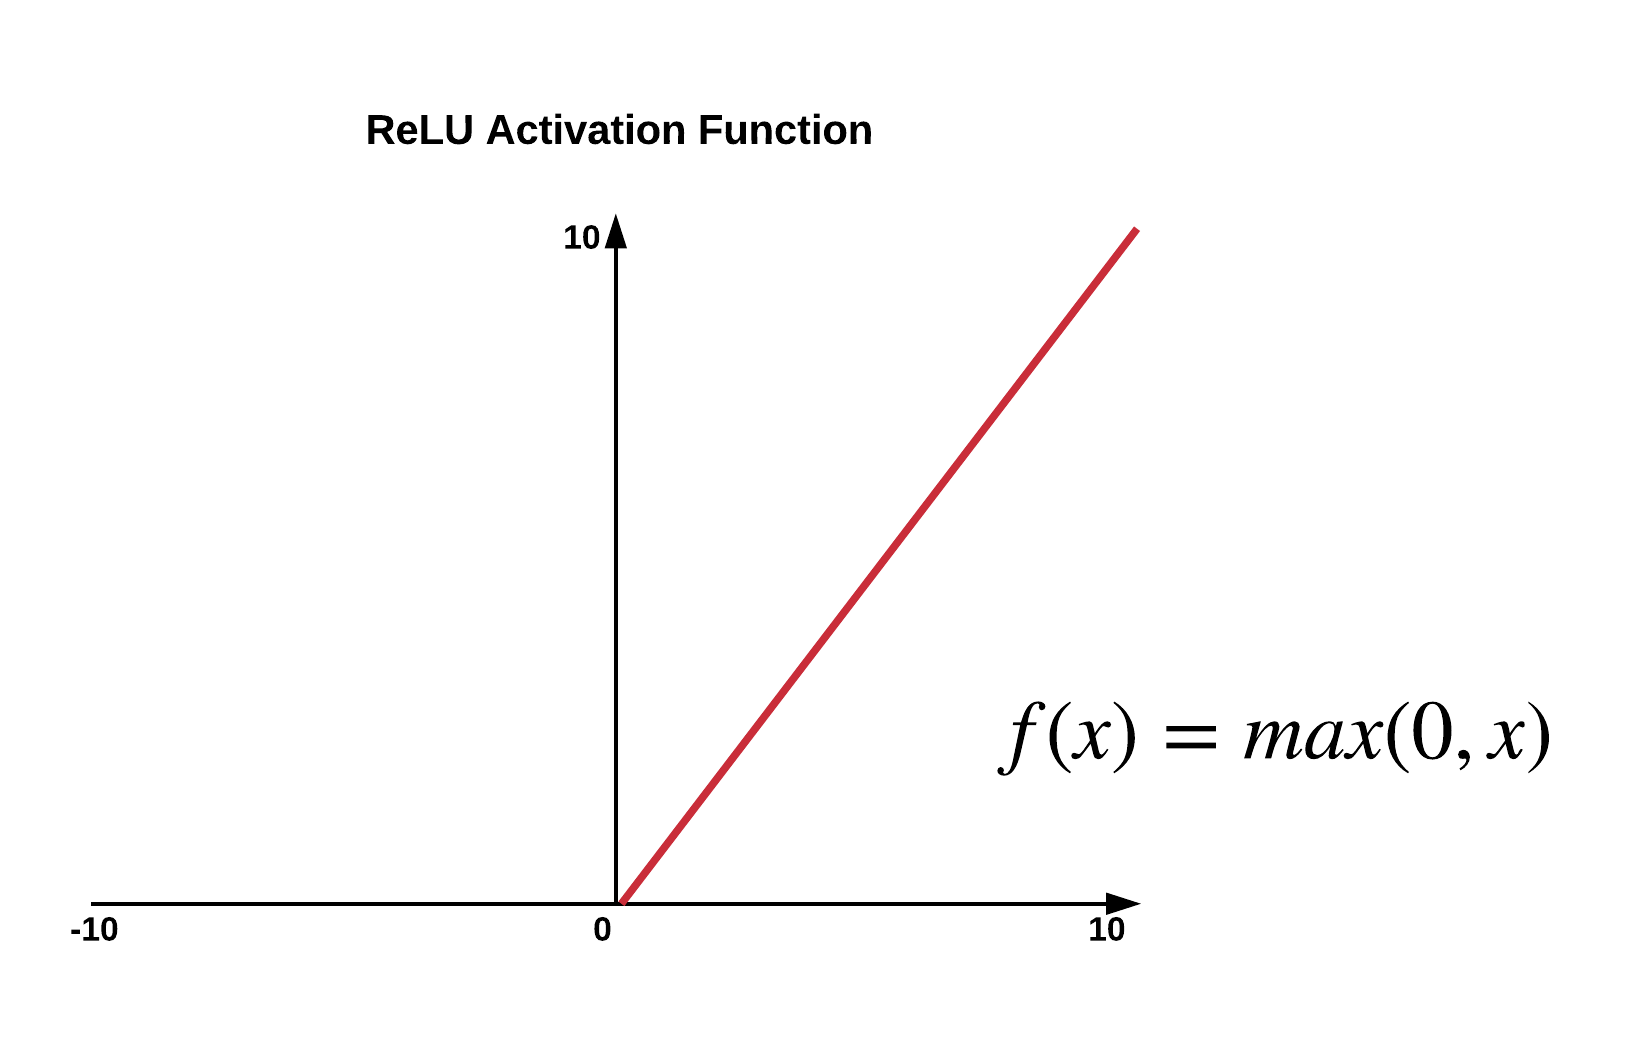{ width=20% }

<h4>b) <strong data-spm-anchor-id="a2ty_o01.29997173.0.i10.7df05171UNgjUK">Leaky ReLU </strong> </h4>
<span class="katex-display"><span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><mi>f</mi><mo stretchy="false">(</mo><mi>x</mi><mo stretchy="false">)</mo><mo>=</mo><mrow><mo fence="true">{</mo><mtable rowspacing="0.36em" columnalign="left left" columnspacing="1em"><mtr><mtd><mstyle scriptlevel="0" displaystyle="false"><mrow><mi>x</mi><mo separator="true">,</mo></mrow></mstyle></mtd><mtd><mstyle scriptlevel="0" displaystyle="false"><mrow><mtext>если&nbsp;</mtext><mi>x</mi><mo>&gt;</mo><mn>0</mn></mrow></mstyle></mtd></mtr><mtr><mtd><mstyle scriptlevel="0" displaystyle="false"><mrow><mi>α</mi><mi>x</mi><mo separator="true">,</mo></mrow></mstyle></mtd><mtd><mstyle scriptlevel="0" displaystyle="false"><mrow><mtext>если&nbsp;</mtext><mi>x</mi><mo>≤</mo><mn>0</mn></mrow></mstyle></mtd></mtr></mtable></mrow></mrow><annotation encoding="application/x-tex">f(x) =
\begin{cases}
x, &amp; \text{если } x &gt; 0 \\
\alpha x, &amp; \text{если } x \leq 0
\end{cases}</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:1em;vertical-align:-0.25em;"></span><span class="mord mathnormal" style="margin-right:0.10764em;">f</span><span class="mopen">(</span><span class="mord mathnormal">x</span><span class="mclose">)</span><span class="mspace" style="margin-right:0.2778em;"></span><span class="mrel">=</span><span class="mspace" style="margin-right:0.2778em;"></span></span><span class="base"><span class="strut" style="height:3em;vertical-align:-1.25em;"></span><span class="minner"><span class="mopen delimcenter" style="top:0em;"><span class="delimsizing size4">{</span></span><span class="mord"><span class="mtable"><span class="col-align-l"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:1.69em;"><span style="top:-3.69em;"><span class="pstrut" style="height:3.008em;"></span><span class="mord"><span class="mord mathnormal">x</span><span class="mpunct">,</span></span></span><span style="top:-2.25em;"><span class="pstrut" style="height:3.008em;"></span><span class="mord"><span class="mord mathnormal">αx</span><span class="mpunct">,</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:1.19em;"><span></span></span></span></span></span><span class="arraycolsep" style="width:1em;"></span><span class="col-align-l"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:1.69em;"><span style="top:-3.69em;"><span class="pstrut" style="height:3.008em;"></span><span class="mord"><span class="mord text"><span class="mord cyrillic_fallback">если</span><span class="mord">&nbsp;</span></span><span class="mord mathnormal">x</span><span class="mspace" style="margin-right:0.2778em;"></span><span class="mrel">&gt;</span><span class="mspace" style="margin-right:0.2778em;"></span><span class="mord">0</span></span></span><span style="top:-2.25em;"><span class="pstrut" style="height:3.008em;"></span><span class="mord"><span class="mord text"><span class="mord cyrillic_fallback">если</span><span class="mord">&nbsp;</span></span><span class="mord mathnormal">x</span><span class="mspace" style="margin-right:0.2778em;"></span><span class="mrel">≤</span><span class="mspace" style="margin-right:0.2778em;"></span><span class="mord">0</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:1.19em;"><span></span></span></span></span></span></span></span><span class="mclose nulldelimiter"></span></span></span></span></span></span>
<p>где <span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>α</mi></mrow><annotation encoding="application/x-tex"> \alpha</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.4306em;"></span><span class="mord mathnormal" style="margin-right:0.0037em;">α</span></span></span></span> — малая константа (например, <span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>α</mi><mo>=</mo><mn>0.01</mn></mrow><annotation encoding="application/x-tex"> \alpha = 0.01</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.4306em;"></span><span class="mord mathnormal" style="margin-right:0.0037em;">α</span><span class="mspace" style="margin-right:0.2778em;"></span><span class="mrel">=</span><span class="mspace" style="margin-right:0.2778em;"></span></span><span class="base"><span class="strut" style="height:0.6444em;"></span><span class="mord">0.01</span></span></span></span>). </p>
<ul><li>Решает проблему "мёртвых нейронов", так как позволяет небольшой градиент для отрицательных значений.</li> </ul>
<ul><li>Значение <span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>α</mi></mrow><annotation encoding="application/x-tex"> \alpha</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.4306em;"></span><span class="mord mathnormal" style="margin-right:0.0037em;">α</span></span></span></span> требует настройки.</li> </ul>

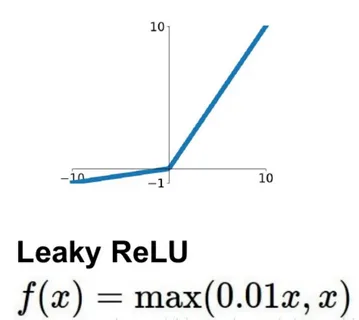

<h4>c) <strong>ELU (Exponential Linear Unit) </strong> </h4>
<span class="katex-display"><span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><mi>f</mi><mo stretchy="false">(</mo><mi>x</mi><mo stretchy="false">)</mo><mo>=</mo><mrow><mo fence="true">{</mo><mtable rowspacing="0.36em" columnalign="left left" columnspacing="1em"><mtr><mtd><mstyle scriptlevel="0" displaystyle="false"><mrow><mi>x</mi><mo separator="true">,</mo></mrow></mstyle></mtd><mtd><mstyle scriptlevel="0" displaystyle="false"><mrow><mtext>если&nbsp;</mtext><mi>x</mi><mo>&gt;</mo><mn>0</mn></mrow></mstyle></mtd></mtr><mtr><mtd><mstyle scriptlevel="0" displaystyle="false"><mrow><mi>α</mi><mo stretchy="false">(</mo><mi>exp</mi><mo>⁡</mo><mo stretchy="false">(</mo><mi>x</mi><mo stretchy="false">)</mo><mo>−</mo><mn>1</mn><mo stretchy="false">)</mo><mo separator="true">,</mo></mrow></mstyle></mtd><mtd><mstyle scriptlevel="0" displaystyle="false"><mrow><mtext>если&nbsp;</mtext><mi>x</mi><mo>≤</mo><mn>0</mn></mrow></mstyle></mtd></mtr></mtable></mrow></mrow><annotation encoding="application/x-tex">f(x) =
\begin{cases}
x, &amp; \text{если } x &gt; 0 \\
\alpha (\exp(x) - 1), &amp; \text{если } x \leq 0
\end{cases}</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:1em;vertical-align:-0.25em;"></span><span class="mord mathnormal" style="margin-right:0.10764em;">f</span><span class="mopen">(</span><span class="mord mathnormal">x</span><span class="mclose">)</span><span class="mspace" style="margin-right:0.2778em;"></span><span class="mrel">=</span><span class="mspace" style="margin-right:0.2778em;"></span></span><span class="base"><span class="strut" style="height:3em;vertical-align:-1.25em;"></span><span class="minner"><span class="mopen delimcenter" style="top:0em;"><span class="delimsizing size4">{</span></span><span class="mord"><span class="mtable"><span class="col-align-l"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:1.69em;"><span style="top:-3.69em;"><span class="pstrut" style="height:3.008em;"></span><span class="mord"><span class="mord mathnormal">x</span><span class="mpunct">,</span></span></span><span style="top:-2.25em;"><span class="pstrut" style="height:3.008em;"></span><span class="mord"><span class="mord mathnormal" style="margin-right:0.0037em;">α</span><span class="mopen">(</span><span class="mop">exp</span><span class="mopen">(</span><span class="mord mathnormal">x</span><span class="mclose">)</span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mbin">−</span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mord">1</span><span class="mclose">)</span><span class="mpunct">,</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:1.19em;"><span></span></span></span></span></span><span class="arraycolsep" style="width:1em;"></span><span class="col-align-l"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:1.69em;"><span style="top:-3.69em;"><span class="pstrut" style="height:3.008em;"></span><span class="mord"><span class="mord text"><span class="mord cyrillic_fallback">если</span><span class="mord">&nbsp;</span></span><span class="mord mathnormal">x</span><span class="mspace" style="margin-right:0.2778em;"></span><span class="mrel">&gt;</span><span class="mspace" style="margin-right:0.2778em;"></span><span class="mord">0</span></span></span><span style="top:-2.25em;"><span class="pstrut" style="height:3.008em;"></span><span class="mord"><span class="mord text"><span class="mord cyrillic_fallback">если</span><span class="mord">&nbsp;</span></span><span class="mord mathnormal">x</span><span class="mspace" style="margin-right:0.2778em;"></span><span class="mrel">≤</span><span class="mspace" style="margin-right:0.2778em;"></span><span class="mord">0</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:1.19em;"><span></span></span></span></span></span></span></span><span class="mclose nulldelimiter"></span></span></span></span></span></span>
<ul><li>Более плавное поведение для отрицательных значений по сравнению с Leaky ReLU.</li><li>Снижает проблему затухающих градиентов.</li> </ul>
<ul><li>Вычислительно сложнее, чем ReLU и Leaky ReLU.</li> </ul>

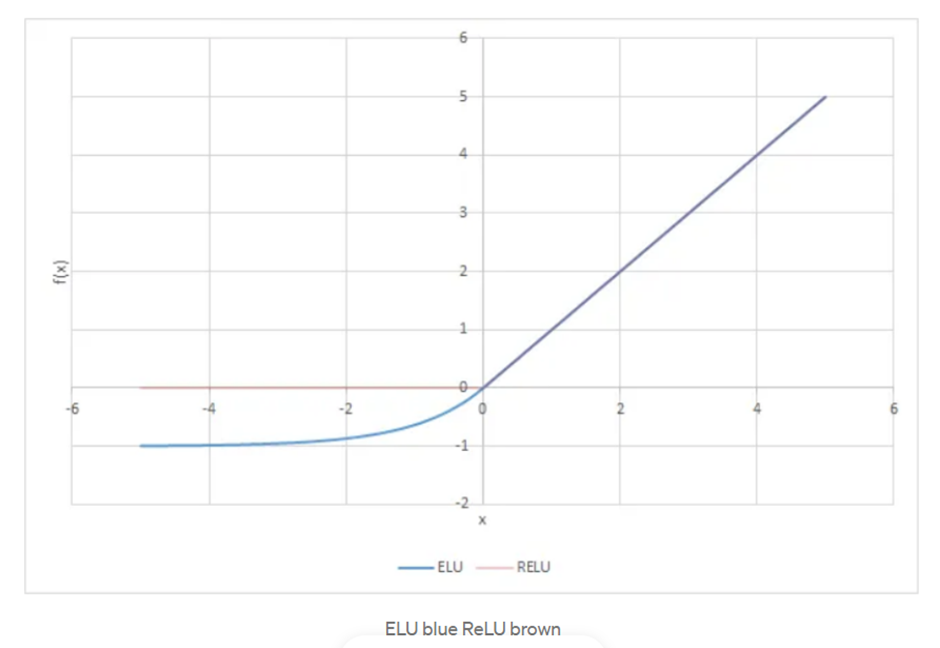

<h4>d) <strong>Swish </strong> </h4>
<span class="katex-display"><span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><mi>f</mi><mo stretchy="false">(</mo><mi>x</mi><mo stretchy="false">)</mo><mo>=</mo><mi>x</mi><mo>⋅</mo><mi>σ</mi><mo stretchy="false">(</mo><mi>x</mi><mo stretchy="false">)</mo><mo separator="true">,</mo></mrow><annotation encoding="application/x-tex">f(x) = x \cdot \sigma(x),</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:1em;vertical-align:-0.25em;"></span><span class="mord mathnormal" style="margin-right:0.10764em;">f</span><span class="mopen">(</span><span class="mord mathnormal">x</span><span class="mclose">)</span><span class="mspace" style="margin-right:0.2778em;"></span><span class="mrel">=</span><span class="mspace" style="margin-right:0.2778em;"></span></span><span class="base"><span class="strut" style="height:0.4445em;"></span><span class="mord mathnormal">x</span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mbin">⋅</span><span class="mspace" style="margin-right:0.2222em;"></span></span><span class="base"><span class="strut" style="height:1em;vertical-align:-0.25em;"></span><span class="mord mathnormal" style="margin-right:0.03588em;">σ</span><span class="mopen">(</span><span class="mord mathnormal">x</span><span class="mclose">)</span><span class="mpunct">,</span></span></span></span></span>
<p>где <span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>σ</mi><mo stretchy="false">(</mo><mi>x</mi><mo stretchy="false">)</mo><mo>=</mo><mfrac><mn>1</mn><mrow><mn>1</mn><mo>+</mo><msup><mi>e</mi><mrow><mo>−</mo><mi>x</mi></mrow></msup></mrow></mfrac></mrow><annotation encoding="application/x-tex"> \sigma(x) = \frac{1}{1 + e^{-x}}</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:1em;vertical-align:-0.25em;"></span><span class="mord mathnormal" style="margin-right:0.03588em;">σ</span><span class="mopen">(</span><span class="mord mathnormal">x</span><span class="mclose">)</span><span class="mspace" style="margin-right:0.2778em;"></span><span class="mrel">=</span><span class="mspace" style="margin-right:0.2778em;"></span></span><span class="base"><span class="strut" style="height:1.2484em;vertical-align:-0.4033em;"></span><span class="mord"><span class="mopen nulldelimiter"></span><span class="mfrac"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.8451em;"><span style="top:-2.655em;"><span class="pstrut" style="height:3em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight"><span class="mord mtight">1</span><span class="mbin mtight">+</span><span class="mord mtight"><span class="mord mathnormal mtight">e</span><span class="msupsub"><span class="vlist-t"><span class="vlist-r"><span class="vlist" style="height:0.7027em;"><span style="top:-2.786em;margin-right:0.0714em;"><span class="pstrut" style="height:2.5em;"></span><span class="sizing reset-size3 size1 mtight"><span class="mord mtight"><span class="mord mtight">−</span><span class="mord mathnormal mtight">x</span></span></span></span></span></span></span></span></span></span></span></span><span style="top:-3.23em;"><span class="pstrut" style="height:3em;"></span><span class="frac-line" style="border-bottom-width:0.04em;"></span></span><span style="top:-3.394em;"><span class="pstrut" style="height:3em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight"><span class="mord mtight">1</span></span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.4033em;"><span></span></span></span></span></span><span class="mclose nulldelimiter"></span></span></span></span></span> — сигмоидальная функция. </p>
<h3>3. <strong>Почему Swish лучше других функций активации? </strong> </h3>
<p>Функция активации <strong>Swish </strong> была предложена в статье Google Brain <strong>"Searching for Activation Functions" </strong> (2017). Она показала превосходные результаты на множестве задач по сравнению с традиционными функциями активации, такими как ReLU. </p>
<h4>a) <strong>Основные преимущества Swish </strong> </h4>
<ol start="1"><li><p><strong>Нелинейность и плавность </strong> </p><ul><li>Swish объединяет свойства ReLU (нелинейность) и сигмоиды (плавность). Это делает её более гибкой для изучения сложных зависимостей.</li> </ul></li><li><p><strong>Отсутствие "мёртвых нейронов" </strong> </p><ul><li>В отличие от ReLU, Swish может активировать нейроны даже при отрицательных значениях <span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>x</mi></mrow><annotation encoding="application/x-tex"> x</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.4306em;"></span><span class="mord mathnormal">x</span></span></span></span>, так как <span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>f</mi><mo stretchy="false">(</mo><mi>x</mi><mo stretchy="false">)</mo><mo mathvariant="normal">≠</mo><mn>0</mn></mrow><annotation encoding="application/x-tex"> f(x) \neq 0</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:1em;vertical-align:-0.25em;"></span><span class="mord mathnormal" style="margin-right:0.10764em;">f</span><span class="mopen">(</span><span class="mord mathnormal">x</span><span class="mclose">)</span><span class="mspace" style="margin-right:0.2778em;"></span><span class="mrel"><span class="mrel"><span class="mord vbox"><span class="thinbox"><span class="rlap"><span class="strut" style="height:0.8889em;vertical-align:-0.1944em;"></span><span class="inner"><span class="mord"><span class="mrel"></span></span></span><span class="fix"></span></span></span></span></span><span class="mrel">=</span></span><span class="mspace" style="margin-right:0.2778em;"></span></span><span class="base"><span class="strut" style="height:0.6444em;"></span><span class="mord">0</span></span></span></span> для всех <span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>x</mi></mrow><annotation encoding="application/x-tex"> x</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.4306em;"></span><span class="mord mathnormal">x</span></span></span></span>.</li> </ul></li><li><p><strong>Саморегулирование </strong> </p><ul><li>Swish автоматически регулирует свои параметры благодаря умножению <span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>x</mi></mrow><annotation encoding="application/x-tex"> x</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.4306em;"></span><span class="mord mathnormal">x</span></span></span></span> на сигмоиду. Это устраняет необходимость вручную настраивать параметры, как в Leaky ReLU или ELU.</li> </ul></li><li><p><strong>Лучшая производительность </strong> </p><ul><li>Эксперименты показали, что Swish превосходит ReLU на глубоких сетях, особенно в задачах классификации и обработки изображений.</li> </ul></li><li><p><strong>Гладкость градиентов </strong> </p><ul><li>Swish имеет гладкие градиенты, что улучшает сходимость при обучении.</li> </ul></li> </ol>
<div class="group relative w-full"><div class="scrollbar-hidden relative max-w-full overflow-x-auto whitespace-nowrap rounded-lg"><table class="w-full max-w-full table-auto rounded-xl text-left text-sm text-gray-500 dark:text-gray-400"><thead class="border-none bg-gray-50 text-xs uppercase text-gray-700 dark:bg-gray-850 dark:text-gray-400"><tr class=""><th scope="col" class="cursor-pointer select-none border border-gray-50 !px-2 !py-1.5 dark:border-gray-850" style="text-align: null"><div class="flex items-center gap-1.5">Характеристика</div> </th><th scope="col" class="cursor-pointer select-none border border-gray-50 !px-2 !py-1.5 dark:border-gray-850" style="text-align: null"><div class="flex items-center gap-1.5">ReLU</div> </th><th scope="col" class="cursor-pointer select-none border border-gray-50 !px-2 !py-1.5 dark:border-gray-850" style="text-align: null"><div class="flex items-center gap-1.5">Swish</div> </th></tr></thead> <tbody><tr class="bg-white text-xs dark:border-gray-850 dark:bg-gray-900"><td class="w-max border border-gray-50 !px-2 !py-1.5 font-medium text-gray-900 dark:border-gray-850 dark:text-white" style="text-align: null"><div class="flex"><strong>Вычислительная сложность </strong></div></td><td class="w-max border border-gray-50 !px-2 !py-1.5 font-medium text-gray-900 dark:border-gray-850 dark:text-white" style="text-align: null"><div class="flex">Очень низкая</div></td><td class="w-max border border-gray-50 !px-2 !py-1.5 font-medium text-gray-900 dark:border-gray-850 dark:text-white" style="text-align: null"><div class="flex">Средняя (из-за сигмоиды)</div></td> </tr><tr class="bg-white text-xs dark:border-gray-850 dark:bg-gray-900"><td class="w-max border border-gray-50 !px-2 !py-1.5 font-medium text-gray-900 dark:border-gray-850 dark:text-white" style="text-align: null"><div class="flex"><strong>Поведение при <span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>x</mi><mo>&lt;</mo><mn>0</mn></mrow><annotation encoding="application/x-tex"> x &lt; 0</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.5782em;vertical-align:-0.0391em;"></span><span class="mord mathnormal">x</span><span class="mspace" style="margin-right:0.2778em;"></span><span class="mrel">&lt;</span><span class="mspace" style="margin-right:0.2778em;"></span></span><span class="base"><span class="strut" style="height:0.6444em;"></span><span class="mord">0</span></span></span></span> </strong></div></td><td class="w-max border border-gray-50 !px-2 !py-1.5 font-medium text-gray-900 dark:border-gray-850 dark:text-white" style="text-align: null"><div class="flex"><span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>f</mi><mo stretchy="false">(</mo><mi>x</mi><mo stretchy="false">)</mo><mo>=</mo><mn>0</mn></mrow><annotation encoding="application/x-tex"> f(x) = 0</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:1em;vertical-align:-0.25em;"></span><span class="mord mathnormal" style="margin-right:0.10764em;">f</span><span class="mopen">(</span><span class="mord mathnormal">x</span><span class="mclose">)</span><span class="mspace" style="margin-right:0.2778em;"></span><span class="mrel">=</span><span class="mspace" style="margin-right:0.2778em;"></span></span><span class="base"><span class="strut" style="height:0.6444em;"></span><span class="mord">0</span></span></span></span></div></td><td class="w-max border border-gray-50 !px-2 !py-1.5 font-medium text-gray-900 dark:border-gray-850 dark:text-white" style="text-align: null"><div class="flex"><span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>f</mi><mo stretchy="false">(</mo><mi>x</mi><mo stretchy="false">)</mo><mo mathvariant="normal">≠</mo><mn>0</mn></mrow><annotation encoding="application/x-tex"> f(x) \neq 0</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:1em;vertical-align:-0.25em;"></span><span class="mord mathnormal" style="margin-right:0.10764em;">f</span><span class="mopen">(</span><span class="mord mathnormal">x</span><span class="mclose">)</span><span class="mspace" style="margin-right:0.2778em;"></span><span class="mrel"><span class="mrel"><span class="mord vbox"><span class="thinbox"><span class="rlap"><span class="strut" style="height:0.8889em;vertical-align:-0.1944em;"></span><span class="inner"><span class="mord"><span class="mrel"></span></span></span><span class="fix"></span></span></span></span></span><span class="mrel">=</span></span><span class="mspace" style="margin-right:0.2778em;"></span></span><span class="base"><span class="strut" style="height:0.6444em;"></span><span class="mord">0</span></span></span></span></div></td> </tr><tr class="bg-white text-xs dark:border-gray-850 dark:bg-gray-900"><td class="w-max border border-gray-50 !px-2 !py-1.5 font-medium text-gray-900 dark:border-gray-850 dark:text-white" style="text-align: null"><div class="flex"><strong>Гладкость </strong></div></td><td class="w-max border border-gray-50 !px-2 !py-1.5 font-medium text-gray-900 dark:border-gray-850 dark:text-white" style="text-align: null"><div class="flex">Негладкая</div></td><td class="w-max border border-gray-50 !px-2 !py-1.5 font-medium text-gray-900 dark:border-gray-850 dark:text-white" style="text-align: null"><div class="flex">Гладкая</div></td> </tr><tr class="bg-white text-xs dark:border-gray-850 dark:bg-gray-900"><td class="w-max border border-gray-50 !px-2 !py-1.5 font-medium text-gray-900 dark:border-gray-850 dark:text-white" style="text-align: null"><div class="flex"><strong>Производительность </strong></div></td><td class="w-max border border-gray-50 !px-2 !py-1.5 font-medium text-gray-900 dark:border-gray-850 dark:text-white" style="text-align: null"><div class="flex">Хорошая</div></td><td class="w-max border border-gray-50 !px-2 !py-1.5 font-medium text-gray-900 dark:border-gray-850 dark:text-white" style="text-align: null"><div class="flex">Лучше на глубоких сетях</div></td> </tr></tbody></table></div> <div class="invisible absolute right-1.5 top-1 z-20 group-hover:visible"><div aria-label="Export to CSV" class="flex" style=""><button class="rounded-lg bg-transparent p-1 transition"><i class="iconfont leading-none icon-line-chevron-down !text-12 font-bold" style=""></i></button></div></div> </div>
<h4>c) <strong>Математическое объяснение </strong> </h4>
<p>Swish сочетает линейное поведение для больших <span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>x</mi></mrow><annotation encoding="application/x-tex"> x</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.4306em;"></span><span class="mord mathnormal">x</span></span></span></span> (как у ReLU) и экспоненциальное затухание для малых <span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>x</mi></mrow><annotation encoding="application/x-tex"> x</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.4306em;"></span><span class="mord mathnormal">x</span></span></span></span>: </p>
<span class="katex-display"><span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><mi>f</mi><mo stretchy="false">(</mo><mi>x</mi><mo stretchy="false">)</mo><mo>=</mo><mi>x</mi><mo>⋅</mo><mi>σ</mi><mo stretchy="false">(</mo><mi>x</mi><mo stretchy="false">)</mo><mo>=</mo><mfrac><mi>x</mi><mrow><mn>1</mn><mo>+</mo><msup><mi>e</mi><mrow><mo>−</mo><mi>x</mi></mrow></msup></mrow></mfrac></mrow><annotation encoding="application/x-tex">f(x) = x \cdot \sigma(x) = \frac{x}{1 + e^{-x}}</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:1em;vertical-align:-0.25em;"></span><span class="mord mathnormal" style="margin-right:0.10764em;">f</span><span class="mopen">(</span><span class="mord mathnormal">x</span><span class="mclose">)</span><span class="mspace" style="margin-right:0.2778em;"></span><span class="mrel">=</span><span class="mspace" style="margin-right:0.2778em;"></span></span><span class="base"><span class="strut" style="height:0.4445em;"></span><span class="mord mathnormal">x</span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mbin">⋅</span><span class="mspace" style="margin-right:0.2222em;"></span></span><span class="base"><span class="strut" style="height:1em;vertical-align:-0.25em;"></span><span class="mord mathnormal" style="margin-right:0.03588em;">σ</span><span class="mopen">(</span><span class="mord mathnormal">x</span><span class="mclose">)</span><span class="mspace" style="margin-right:0.2778em;"></span><span class="mrel">=</span><span class="mspace" style="margin-right:0.2778em;"></span></span><span class="base"><span class="strut" style="height:1.8769em;vertical-align:-0.7693em;"></span><span class="mord"><span class="mopen nulldelimiter"></span><span class="mfrac"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:1.1076em;"><span style="top:-2.314em;"><span class="pstrut" style="height:3em;"></span><span class="mord"><span class="mord">1</span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mbin">+</span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mord"><span class="mord mathnormal">e</span><span class="msupsub"><span class="vlist-t"><span class="vlist-r"><span class="vlist" style="height:0.6973em;"><span style="top:-2.989em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight"><span class="mord mtight">−</span><span class="mord mathnormal mtight">x</span></span></span></span></span></span></span></span></span></span></span><span style="top:-3.23em;"><span class="pstrut" style="height:3em;"></span><span class="frac-line" style="border-bottom-width:0.04em;"></span></span><span style="top:-3.677em;"><span class="pstrut" style="height:3em;"></span><span class="mord"><span class="mord mathnormal">x</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.7693em;"><span></span></span></span></span></span><span class="mclose nulldelimiter"></span></span></span></span></span></span>
<ul><li>При <span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>x</mi><mo>→</mo><mi mathvariant="normal">∞</mi></mrow><annotation encoding="application/x-tex"> x \to \infty</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.4306em;"></span><span class="mord mathnormal">x</span><span class="mspace" style="margin-right:0.2778em;"></span><span class="mrel">→</span><span class="mspace" style="margin-right:0.2778em;"></span></span><span class="base"><span class="strut" style="height:0.4306em;"></span><span class="mord">∞</span></span></span></span>: <span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>f</mi><mo stretchy="false">(</mo><mi>x</mi><mo stretchy="false">)</mo><mo>≈</mo><mi>x</mi></mrow><annotation encoding="application/x-tex"> f(x) \approx x</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:1em;vertical-align:-0.25em;"></span><span class="mord mathnormal" style="margin-right:0.10764em;">f</span><span class="mopen">(</span><span class="mord mathnormal">x</span><span class="mclose">)</span><span class="mspace" style="margin-right:0.2778em;"></span><span class="mrel">≈</span><span class="mspace" style="margin-right:0.2778em;"></span></span><span class="base"><span class="strut" style="height:0.4306em;"></span><span class="mord mathnormal">x</span></span></span></span> (как ReLU).</li><li>При <span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>x</mi><mo>→</mo><mo>−</mo><mi mathvariant="normal">∞</mi></mrow><annotation encoding="application/x-tex"> x \to -\infty</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.4306em;"></span><span class="mord mathnormal">x</span><span class="mspace" style="margin-right:0.2778em;"></span><span class="mrel">→</span><span class="mspace" style="margin-right:0.2778em;"></span></span><span class="base"><span class="strut" style="height:0.6667em;vertical-align:-0.0833em;"></span><span class="mord">−</span><span class="mord">∞</span></span></span></span>: <span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>f</mi><mo stretchy="false">(</mo><mi>x</mi><mo stretchy="false">)</mo><mo>→</mo><mn>0</mn></mrow><annotation encoding="application/x-tex"> f(x) \to 0</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:1em;vertical-align:-0.25em;"></span><span class="mord mathnormal" style="margin-right:0.10764em;">f</span><span class="mopen">(</span><span class="mord mathnormal">x</span><span class="mclose">)</span><span class="mspace" style="margin-right:0.2778em;"></span><span class="mrel">→</span><span class="mspace" style="margin-right:0.2778em;"></span></span><span class="base"><span class="strut" style="height:0.6444em;"></span><span class="mord">0</span></span></span></span> (более плавно, чем у ReLU).</li> </ul>

<span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><mtext>Output&nbsp;size</mtext><mo>=</mo><mrow><mo fence="true">⌊</mo><mfrac><mrow><mtext>Input&nbsp;size</mtext><mo>+</mo><mn>2</mn><mo>⋅</mo><mtext>Padding</mtext><mo>−</mo><mtext>Kernel&nbsp;size</mtext></mrow><mtext>Stride</mtext></mfrac><mo fence="true">⌋</mo></mrow><mo>+</mo><mn>1</mn></mrow><annotation encoding="application/x-tex">\text{Output size} = \left\lfloor \frac{\text{Input size} + 2 \cdot \text{Padding} - \text{Kernel size}}{\text{Stride}} \right\rfloor + 1</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.8778em;vertical-align:-0.1944em;"></span><span class="mord text"><span class="mord" data-spm-anchor-id="a2ty_o01.29997173.0.i17.7df029b55TYn5m">Output&nbsp;size</span></span><span class="mspace" style="margin-right:0.2778em;"></span><span class="mrel">=</span><span class="mspace" style="margin-right:0.2778em;"></span></span><span class="base"><span class="strut" style="height:2.4em;vertical-align:-0.95em;"></span><span class="minner"><span class="mopen delimcenter" style="top:0em;"><span class="delimsizing size3">⌊</span></span><span class="mord"><span class="mopen nulldelimiter"></span><span class="mfrac"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:1.3714em;"><span style="top:-2.314em;"><span class="pstrut" style="height:3em;"></span><span class="mord"><span class="mord text"><span class="mord">Stride</span></span></span></span><span style="top:-3.23em;"><span class="pstrut" style="height:3em;"></span><span class="frac-line" style="border-bottom-width:0.04em;"></span></span><span style="top:-3.677em;"><span class="pstrut" style="height:3em;"></span><span class="mord"><span class="mord text"><span class="mord">Input&nbsp;size</span></span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mbin">+</span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mord">2</span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mbin">⋅</span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mord text"><span class="mord">Padding</span></span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mbin">−</span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mord text"><span class="mord">Kernel&nbsp;size</span></span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.686em;"><span></span></span></span></span></span><span class="mclose nulldelimiter"></span></span><span class="mclose delimcenter" style="top:0em;"><span class="delimsizing size3">⌋</span></span></span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mbin">+</span><span class="mspace" style="margin-right:0.2222em;"></span></span><span class="base"><span class="strut" style="height:0.6444em;"></span><span class="mord">1</span></span></span></span>

Создадим модель

In [57]:
import torch.nn.functional as F
class NNClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        
        # Свёрточные слои
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Полносвязные слои
        self.fc1 = nn.Linear(128 * 18 * 18, 64)
        self.bn_fc1 = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, 32)
        self.bn_fc2 = nn.BatchNorm1d(32)
        self.fc3 = nn.Linear(32, num_classes)

        self.dropout = nn.Dropout(p=0.3)

        self.swish = Swish()

        # Softmax (опционально)
        #self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        if x.dim() == 3:  
            x = x.unsqueeze(0) 
        x = self.pool1(self.swish(self.bn1(self.conv1(x))))
        x = self.pool2(self.swish(self.bn2(self.conv2(x))))
        x = self.pool3(self.swish(self.bn3(self.conv3(x))))
        x = self.pool4(self.swish(self.bn4(self.conv4(x))))
        x = x.view(x.size(0), -1)

        x = self.swish(self.bn_fc1(self.fc1(x)))

        x = self.dropout(x)
        x = self.swish(self.bn_fc2(self.fc2(x)))

        x = self.dropout(x)
        x = self.fc3(x)

        return x

In [58]:
model = NNClassifier(num_classes = 10).to(device)

In [59]:
summary(model, input_size=(3, 300, 300)) 

Layer (type:depth-idx)                   Output Shape              Param #
NNClassifier                             [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 300, 300]         896
├─BatchNorm2d: 1-2                       [1, 32, 300, 300]         64
├─Swish: 1-3                             [1, 32, 300, 300]         --
├─MaxPool2d: 1-4                         [1, 32, 150, 150]         --
├─Conv2d: 1-5                            [1, 64, 150, 150]         18,496
├─BatchNorm2d: 1-6                       [1, 64, 150, 150]         128
├─Swish: 1-7                             [1, 64, 150, 150]         --
├─MaxPool2d: 1-8                         [1, 64, 75, 75]           --
├─Conv2d: 1-9                            [1, 64, 75, 75]           36,928
├─BatchNorm2d: 1-10                      [1, 64, 75, 75]           128
├─Swish: 1-11                            [1, 64, 75, 75]           --
├─MaxPool2d: 1-12                        [1, 64, 37, 37]           --
├─Co

Как видно модель состоит из множества слоев. Суть в том, что проходя через сверточные слои, изображение обрабатывается фильтрами, чтобы выделить главный признак. Теперь подробнее о слоях:


<p data-spm-anchor-id="a2ty_o01.29997173.0.i14.7df05171UNgjUK"><code class="codespan cursor-pointer z-[9] relative">Conv2d</code> (сокращение от <strong>2D Convolution </strong>) — это операция двумерной свёртки, которая широко используется в свёрточных нейронных сетях (CNN) для обработки данных с пространственной структурой, таких как изображения. Математически свёртка представляет собой процесс вычисления взвешенной суммы значений пикселей в локальной области входного тензора. </p>
<ul><li><span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>I</mi></mrow><annotation encoding="application/x-tex"> I</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.6833em;"></span><span class="mord mathnormal" style="margin-right:0.07847em;">I</span></span></span></span> — входное изображение (тензор) размером <span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>H</mi><mo>×</mo><mi>W</mi><mo>×</mo><msub><mi>C</mi><mtext>in</mtext></msub></mrow><annotation encoding="application/x-tex"> H \times W \times C_{\text{in}}</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.7667em;vertical-align:-0.0833em;"></span><span class="mord mathnormal" style="margin-right:0.08125em;">H</span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mbin">×</span><span class="mspace" style="margin-right:0.2222em;"></span></span><span class="base"><span class="strut" style="height:0.7667em;vertical-align:-0.0833em;"></span><span class="mord mathnormal" style="margin-right:0.13889em;">W</span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mbin">×</span><span class="mspace" style="margin-right:0.2222em;"></span></span><span class="base"><span class="strut" style="height:0.8333em;vertical-align:-0.15em;"></span><span class="mord"><span class="mord mathnormal" style="margin-right:0.07153em;">C</span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.3175em;"><span style="top:-2.55em;margin-left:-0.0715em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight"><span class="mord text mtight"><span class="mord mtight">in</span></span></span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.15em;"><span></span></span></span></span></span></span></span></span></span>, где:<ul><li><span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>H</mi></mrow><annotation encoding="application/x-tex"> H</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.6833em;"></span><span class="mord mathnormal" style="margin-right:0.08125em;">H</span></span></span></span>: высота.</li><li><span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>W</mi></mrow><annotation encoding="application/x-tex"> W</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.6833em;"></span><span class="mord mathnormal" style="margin-right:0.13889em;">W</span></span></span></span>: ширина.</li><li><span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><msub><mi>C</mi><mtext>in</mtext></msub></mrow><annotation encoding="application/x-tex"> C_{\text{in}}</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.8333em;vertical-align:-0.15em;"></span><span class="mord"><span class="mord mathnormal" style="margin-right:0.07153em;">C</span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.3175em;"><span style="top:-2.55em;margin-left:-0.0715em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight"><span class="mord text mtight"><span class="mord mtight">in</span></span></span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.15em;"><span></span></span></span></span></span></span></span></span></span>: количество каналов (например, 3 для RGB).</li> </ul></li><li><span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>K</mi></mrow><annotation encoding="application/x-tex"> K</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.6833em;"></span><span class="mord mathnormal" style="margin-right:0.07153em;">K</span></span></span></span> — ядро свёртки (фильтр) размером <span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><msub><mi>K</mi><mi>h</mi></msub><mo>×</mo><msub><mi>K</mi><mi>w</mi></msub><mo>×</mo><msub><mi>C</mi><mtext>in</mtext></msub></mrow><annotation encoding="application/x-tex"> K_h \times K_w \times C_{\text{in}}</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.8333em;vertical-align:-0.15em;"></span><span class="mord"><span class="mord mathnormal" style="margin-right:0.07153em;">K</span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.3361em;"><span style="top:-2.55em;margin-left:-0.0715em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mathnormal mtight">h</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.15em;"><span></span></span></span></span></span></span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mbin">×</span><span class="mspace" style="margin-right:0.2222em;"></span></span><span class="base"><span class="strut" style="height:0.8333em;vertical-align:-0.15em;"></span><span class="mord"><span class="mord mathnormal" style="margin-right:0.07153em;">K</span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.1514em;"><span style="top:-2.55em;margin-left:-0.0715em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mathnormal mtight" style="margin-right:0.02691em;">w</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.15em;"><span></span></span></span></span></span></span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mbin">×</span><span class="mspace" style="margin-right:0.2222em;"></span></span><span class="base"><span class="strut" style="height:0.8333em;vertical-align:-0.15em;"></span><span class="mord"><span class="mord mathnormal" style="margin-right:0.07153em;">C</span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.3175em;"><span style="top:-2.55em;margin-left:-0.0715em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight"><span class="mord text mtight"><span class="mord mtight">in</span></span></span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.15em;"><span></span></span></span></span></span></span></span></span></span>, где:<ul><li><span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><msub><mi>K</mi><mi>h</mi></msub></mrow><annotation encoding="application/x-tex"> K_h</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.8333em;vertical-align:-0.15em;"></span><span class="mord"><span class="mord mathnormal" style="margin-right:0.07153em;">K</span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.3361em;"><span style="top:-2.55em;margin-left:-0.0715em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mathnormal mtight">h</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.15em;"><span></span></span></span></span></span></span></span></span></span>: высота ядра.</li><li><span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><msub><mi>K</mi><mi>w</mi></msub></mrow><annotation encoding="application/x-tex"> K_w</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.8333em;vertical-align:-0.15em;"></span><span class="mord"><span class="mord mathnormal" style="margin-right:0.07153em;">K</span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.1514em;"><span style="top:-2.55em;margin-left:-0.0715em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mathnormal mtight" style="margin-right:0.02691em;">w</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.15em;"><span></span></span></span></span></span></span></span></span></span>: ширина ядра.</li><li><span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><msub><mi>C</mi><mtext>in</mtext></msub></mrow><annotation encoding="application/x-tex"> C_{\text{in}}</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.8333em;vertical-align:-0.15em;"></span><span class="mord"><span class="mord mathnormal" style="margin-right:0.07153em;">C</span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.3175em;"><span style="top:-2.55em;margin-left:-0.0715em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight"><span class="mord text mtight"><span class="mord mtight">in</span></span></span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.15em;"><span></span></span></span></span></span></span></span></span></span>: количество входных каналов (совпадает с <span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><msub><mi>C</mi><mtext>in</mtext></msub></mrow><annotation encoding="application/x-tex"> C_{\text{in}}</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.8333em;vertical-align:-0.15em;"></span><span class="mord"><span class="mord mathnormal" style="margin-right:0.07153em;">C</span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.3175em;"><span style="top:-2.55em;margin-left:-0.0715em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight"><span class="mord text mtight"><span class="mord mtight">in</span></span></span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.15em;"><span></span></span></span></span></span></span></span></span></span> входного изображения).</li> </ul></li> </ul>
<p>Результатом свёртки является выходной тензор <span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>O</mi></mrow><annotation encoding="application/x-tex"> O</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.6833em;"></span><span class="mord mathnormal" style="margin-right:0.02778em;">O</span></span></span></span> размером <span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><msup><mi>H</mi><mo mathvariant="normal" lspace="0em" rspace="0em">′</mo></msup><mo>×</mo><msup><mi>W</mi><mo mathvariant="normal" lspace="0em" rspace="0em">′</mo></msup><mo>×</mo><msub><mi>C</mi><mtext>out</mtext></msub></mrow><annotation encoding="application/x-tex"> H' \times W' \times C_{\text{out}}</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.8352em;vertical-align:-0.0833em;"></span><span class="mord"><span class="mord mathnormal" style="margin-right:0.08125em;">H</span><span class="msupsub"><span class="vlist-t"><span class="vlist-r"><span class="vlist" style="height:0.7519em;"><span style="top:-3.063em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight"><span class="mord mtight">′</span></span></span></span></span></span></span></span></span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mbin">×</span><span class="mspace" style="margin-right:0.2222em;"></span></span><span class="base"><span class="strut" style="height:0.8352em;vertical-align:-0.0833em;"></span><span class="mord"><span class="mord mathnormal" style="margin-right:0.13889em;">W</span><span class="msupsub"><span class="vlist-t"><span class="vlist-r"><span class="vlist" style="height:0.7519em;"><span style="top:-3.063em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight"><span class="mord mtight">′</span></span></span></span></span></span></span></span></span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mbin">×</span><span class="mspace" style="margin-right:0.2222em;"></span></span><span class="base"><span class="strut" style="height:0.8333em;vertical-align:-0.15em;"></span><span class="mord"><span class="mord mathnormal" style="margin-right:0.07153em;">C</span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.2806em;"><span style="top:-2.55em;margin-left:-0.0715em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight"><span class="mord text mtight"><span class="mord mtight">out</span></span></span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.15em;"><span></span></span></span></span></span></span></span></span></span>, где: </p>
<ul><li><span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><msup><mi>H</mi><mo mathvariant="normal" lspace="0em" rspace="0em">′</mo></msup></mrow><annotation encoding="application/x-tex"> H'</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.7519em;"></span><span class="mord"><span class="mord mathnormal" style="margin-right:0.08125em;">H</span><span class="msupsub"><span class="vlist-t"><span class="vlist-r"><span class="vlist" style="height:0.7519em;"><span style="top:-3.063em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight"><span class="mord mtight">′</span></span></span></span></span></span></span></span></span></span></span></span>: высота выходного тензора.</li><li><span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><msup><mi>W</mi><mo mathvariant="normal" lspace="0em" rspace="0em">′</mo></msup></mrow><annotation encoding="application/x-tex"> W'</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.7519em;"></span><span class="mord"><span class="mord mathnormal" style="margin-right:0.13889em;">W</span><span class="msupsub"><span class="vlist-t"><span class="vlist-r"><span class="vlist" style="height:0.7519em;"><span style="top:-3.063em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight"><span class="mord mtight">′</span></span></span></span></span></span></span></span></span></span></span></span>: ширина выходного тензора.</li><li><span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><msub><mi>C</mi><mtext>out</mtext></msub></mrow><annotation encoding="application/x-tex"> C_{\text{out}}</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.8333em;vertical-align:-0.15em;"></span><span class="mord"><span class="mord mathnormal" style="margin-right:0.07153em;">C</span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.2806em;"><span style="top:-2.55em;margin-left:-0.0715em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight"><span class="mord text mtight"><span class="mord mtight">out</span></span></span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.15em;"><span></span></span></span></span></span></span></span></span></span>: количество выходных каналов (равно количеству фильтров).</li> </ul>
<p>Для каждого выходного значения <span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>O</mi><mo stretchy="false">[</mo><mi>i</mi><mo separator="true">,</mo><mi>j</mi><mo separator="true">,</mo><mi>c</mi><mo stretchy="false">]</mo></mrow><annotation encoding="application/x-tex"> O[i, j, c]</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:1em;vertical-align:-0.25em;"></span><span class="mord mathnormal" style="margin-right:0.02778em;">O</span><span class="mopen">[</span><span class="mord mathnormal">i</span><span class="mpunct">,</span><span class="mspace" style="margin-right:0.1667em;"></span><span class="mord mathnormal" style="margin-right:0.05724em;">j</span><span class="mpunct">,</span><span class="mspace" style="margin-right:0.1667em;"></span><span class="mord mathnormal">c</span><span class="mclose">]</span></span></span></span> (где <span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>i</mi><mo separator="true">,</mo><mi>j</mi></mrow><annotation encoding="application/x-tex"> i, j</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.854em;vertical-align:-0.1944em;"></span><span class="mord mathnormal">i</span><span class="mpunct">,</span><span class="mspace" style="margin-right:0.1667em;"></span><span class="mord mathnormal" style="margin-right:0.05724em;">j</span></span></span></span> — координаты пикселя, <span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>c</mi></mrow><annotation encoding="application/x-tex"> c</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.4306em;"></span><span class="mord mathnormal">c</span></span></span></span> — номер канала) выполняется следующее: </p>
<span class="katex-display"><span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><mi>O</mi><mo stretchy="false">[</mo><mi>i</mi><mo separator="true">,</mo><mi>j</mi><mo separator="true">,</mo><mi>c</mi><mo stretchy="false">]</mo><mo>=</mo><munderover><mo>∑</mo><mrow><mi>m</mi><mo>=</mo><mn>0</mn></mrow><mrow><msub><mi>K</mi><mi>h</mi></msub><mo>−</mo><mn>1</mn></mrow></munderover><munderover><mo>∑</mo><mrow><mi>n</mi><mo>=</mo><mn>0</mn></mrow><mrow><msub><mi>K</mi><mi>w</mi></msub><mo>−</mo><mn>1</mn></mrow></munderover><munderover><mo>∑</mo><mrow><mi>k</mi><mo>=</mo><mn>0</mn></mrow><mrow><msub><mi>C</mi><mtext>in</mtext></msub><mo>−</mo><mn>1</mn></mrow></munderover><mi>I</mi><mo stretchy="false">[</mo><mi>i</mi><mo>+</mo><mi>m</mi><mo separator="true">,</mo><mi>j</mi><mo>+</mo><mi>n</mi><mo separator="true">,</mo><mi>k</mi><mo stretchy="false">]</mo><mo>⋅</mo><mi>K</mi><mo stretchy="false">[</mo><mi>m</mi><mo separator="true">,</mo><mi>n</mi><mo separator="true">,</mo><mi>k</mi><mo separator="true">,</mo><mi>c</mi><mo stretchy="false">]</mo><mo>+</mo><mi>b</mi><mo stretchy="false">[</mo><mi>c</mi><mo stretchy="false">]</mo></mrow><annotation encoding="application/x-tex">O[i, j, c] = \sum_{m=0}^{K_h-1} \sum_{n=0}^{K_w-1} \sum_{k=0}^{C_{\text{in}}-1} I[i+m, j+n, k] \cdot K[m, n, k, c] + b[c]</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:1em;vertical-align:-0.25em;"></span><span class="mord mathnormal" style="margin-right:0.02778em;">O</span><span class="mopen">[</span><span class="mord mathnormal">i</span><span class="mpunct">,</span><span class="mspace" style="margin-right:0.1667em;"></span><span class="mord mathnormal" style="margin-right:0.05724em;">j</span><span class="mpunct">,</span><span class="mspace" style="margin-right:0.1667em;"></span><span class="mord mathnormal">c</span><span class="mclose">]</span><span class="mspace" style="margin-right:0.2778em;"></span><span class="mrel">=</span><span class="mspace" style="margin-right:0.2778em;"></span></span><span class="base"><span class="strut" style="height:3.1473em;vertical-align:-1.3021em;"></span><span class="mop op-limits"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:1.8452em;"><span style="top:-1.8829em;margin-left:0em;"><span class="pstrut" style="height:3.05em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight"><span class="mord mathnormal mtight">m</span><span class="mrel mtight">=</span><span class="mord mtight">0</span></span></span></span><span style="top:-3.05em;"><span class="pstrut" style="height:3.05em;"></span><span><span class="mop op-symbol large-op">∑</span></span></span><span style="top:-4.3169em;margin-left:0em;"><span class="pstrut" style="height:3.05em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight"><span class="mord mtight"><span class="mord mathnormal mtight" style="margin-right:0.07153em;">K</span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.3448em;"><span style="top:-2.3488em;margin-left:-0.0715em;margin-right:0.0714em;"><span class="pstrut" style="height:2.5em;"></span><span class="sizing reset-size3 size1 mtight"><span class="mord mathnormal mtight">h</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.1512em;"><span></span></span></span></span></span></span><span class="mbin mtight">−</span><span class="mord mtight">1</span></span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:1.2671em;"><span></span></span></span></span></span><span class="mspace" style="margin-right:0.1667em;"></span><span class="mop op-limits"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:1.8394em;"><span style="top:-1.8829em;margin-left:0em;"><span class="pstrut" style="height:3.05em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight"><span class="mord mathnormal mtight">n</span><span class="mrel mtight">=</span><span class="mord mtight">0</span></span></span></span><span style="top:-3.05em;"><span class="pstrut" style="height:3.05em;"></span><span><span class="mop op-symbol large-op">∑</span></span></span><span style="top:-4.3111em;margin-left:0em;"><span class="pstrut" style="height:3.05em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight"><span class="mord mtight"><span class="mord mathnormal mtight" style="margin-right:0.07153em;">K</span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.1645em;"><span style="top:-2.357em;margin-left:-0.0715em;margin-right:0.0714em;"><span class="pstrut" style="height:2.5em;"></span><span class="sizing reset-size3 size1 mtight"><span class="mord mathnormal mtight" style="margin-right:0.02691em;">w</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.143em;"><span></span></span></span></span></span></span><span class="mbin mtight">−</span><span class="mord mtight">1</span></span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:1.2671em;"><span></span></span></span></span></span><span class="mspace" style="margin-right:0.1667em;"></span><span class="mop op-limits"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:1.8394em;"><span style="top:-1.8479em;margin-left:0em;"><span class="pstrut" style="height:3.05em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight"><span class="mord mathnormal mtight" style="margin-right:0.03148em;">k</span><span class="mrel mtight">=</span><span class="mord mtight">0</span></span></span></span><span style="top:-3.05em;"><span class="pstrut" style="height:3.05em;"></span><span><span class="mop op-symbol large-op">∑</span></span></span><span style="top:-4.3111em;margin-left:0em;"><span class="pstrut" style="height:3.05em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight"><span class="mord mtight"><span class="mord mathnormal mtight" style="margin-right:0.07153em;">C</span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.334em;"><span style="top:-2.357em;margin-left:-0.0715em;margin-right:0.0714em;"><span class="pstrut" style="height:2.5em;"></span><span class="sizing reset-size3 size1 mtight"><span class="mord mtight"><span class="mord text mtight"><span class="mord mtight">in</span></span></span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.143em;"><span></span></span></span></span></span></span><span class="mbin mtight">−</span><span class="mord mtight">1</span></span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:1.3021em;"><span></span></span></span></span></span><span class="mspace" style="margin-right:0.1667em;"></span><span class="mord mathnormal" style="margin-right:0.07847em;">I</span><span class="mopen">[</span><span class="mord mathnormal">i</span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mbin">+</span><span class="mspace" style="margin-right:0.2222em;"></span></span><span class="base"><span class="strut" style="height:0.854em;vertical-align:-0.1944em;"></span><span class="mord mathnormal">m</span><span class="mpunct">,</span><span class="mspace" style="margin-right:0.1667em;"></span><span class="mord mathnormal" style="margin-right:0.05724em;">j</span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mbin">+</span><span class="mspace" style="margin-right:0.2222em;"></span></span><span class="base"><span class="strut" style="height:1em;vertical-align:-0.25em;"></span><span class="mord mathnormal">n</span><span class="mpunct">,</span><span class="mspace" style="margin-right:0.1667em;"></span><span class="mord mathnormal" style="margin-right:0.03148em;">k</span><span class="mclose">]</span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mbin">⋅</span><span class="mspace" style="margin-right:0.2222em;"></span></span><span class="base"><span class="strut" style="height:1em;vertical-align:-0.25em;"></span><span class="mord mathnormal" style="margin-right:0.07153em;">K</span><span class="mopen">[</span><span class="mord mathnormal">m</span><span class="mpunct">,</span><span class="mspace" style="margin-right:0.1667em;"></span><span class="mord mathnormal">n</span><span class="mpunct">,</span><span class="mspace" style="margin-right:0.1667em;"></span><span class="mord mathnormal" style="margin-right:0.03148em;">k</span><span class="mpunct">,</span><span class="mspace" style="margin-right:0.1667em;"></span><span class="mord mathnormal">c</span><span class="mclose">]</span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mbin">+</span><span class="mspace" style="margin-right:0.2222em;"></span></span><span class="base"><span class="strut" style="height:1em;vertical-align:-0.25em;"></span><span class="mord mathnormal">b</span><span class="mopen">[</span><span class="mord mathnormal">c</span><span class="mclose">]</span></span></span></span></span>
<p>Где: </p>
<ul><li><span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>I</mi><mo stretchy="false">[</mo><mi>i</mi><mo>+</mo><mi>m</mi><mo separator="true">,</mo><mi>j</mi><mo>+</mo><mi>n</mi><mo separator="true">,</mo><mi>k</mi><mo stretchy="false">]</mo></mrow><annotation encoding="application/x-tex"> I[i+m, j+n, k]</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:1em;vertical-align:-0.25em;"></span><span class="mord mathnormal" style="margin-right:0.07847em;">I</span><span class="mopen">[</span><span class="mord mathnormal">i</span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mbin">+</span><span class="mspace" style="margin-right:0.2222em;"></span></span><span class="base"><span class="strut" style="height:0.854em;vertical-align:-0.1944em;"></span><span class="mord mathnormal">m</span><span class="mpunct">,</span><span class="mspace" style="margin-right:0.1667em;"></span><span class="mord mathnormal" style="margin-right:0.05724em;">j</span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mbin">+</span><span class="mspace" style="margin-right:0.2222em;"></span></span><span class="base"><span class="strut" style="height:1em;vertical-align:-0.25em;"></span><span class="mord mathnormal">n</span><span class="mpunct">,</span><span class="mspace" style="margin-right:0.1667em;"></span><span class="mord mathnormal" style="margin-right:0.03148em;">k</span><span class="mclose">]</span></span></span></span>: значение пикселя входного изображения.</li><li><span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>K</mi><mo stretchy="false">[</mo><mi>m</mi><mo separator="true">,</mo><mi>n</mi><mo separator="true">,</mo><mi>k</mi><mo separator="true">,</mo><mi>c</mi><mo stretchy="false">]</mo></mrow><annotation encoding="application/x-tex"> K[m, n, k, c]</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:1em;vertical-align:-0.25em;"></span><span class="mord mathnormal" style="margin-right:0.07153em;">K</span><span class="mopen">[</span><span class="mord mathnormal">m</span><span class="mpunct">,</span><span class="mspace" style="margin-right:0.1667em;"></span><span class="mord mathnormal">n</span><span class="mpunct">,</span><span class="mspace" style="margin-right:0.1667em;"></span><span class="mord mathnormal" style="margin-right:0.03148em;">k</span><span class="mpunct">,</span><span class="mspace" style="margin-right:0.1667em;"></span><span class="mord mathnormal">c</span><span class="mclose">]</span></span></span></span>: значение веса ядра для канала <span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>k</mi></mrow><annotation encoding="application/x-tex"> k</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.6944em;"></span><span class="mord mathnormal" style="margin-right:0.03148em;">k</span></span></span></span> и фильтра <span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>c</mi></mrow><annotation encoding="application/x-tex"> c</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.4306em;"></span><span class="mord mathnormal">c</span></span></span></span>.</li><li><span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>b</mi><mo stretchy="false">[</mo><mi>c</mi><mo stretchy="false">]</mo></mrow><annotation encoding="application/x-tex"> b[c]</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:1em;vertical-align:-0.25em;"></span><span class="mord mathnormal">b</span><span class="mopen">[</span><span class="mord mathnormal">c</span><span class="mclose">]</span></span></span></span>: смещение (bias) для фильтра <span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>c</mi></mrow><annotation encoding="application/x-tex"> c</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.4306em;"></span><span class="mord mathnormal">c</span></span></span></span>.</li> </ul>

<ul><li>Ядро — это маленькая матрица (например, <span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mn>3</mn><mo>×</mo><mn>3</mn></mrow><annotation encoding="application/x-tex"> 3 \times 3</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.7278em;vertical-align:-0.0833em;"></span><span class="mord">3</span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mbin">×</span><span class="mspace" style="margin-right:0.2222em;"></span></span><span class="base"><span class="strut" style="height:0.6444em;"></span><span class="mord">3</span></span></span></span>), которая "скользит" по входному изображению.</li><li>Для каждого положения ядра вычисляется взвешенная сумма значений пикселей в области, покрытой ядром.</li> </ul>
<ul><li>Ядро перемещается по входному изображению с шагом <span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>s</mi></mrow><annotation encoding="application/x-tex"> s</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.4306em;"></span><span class="mord mathnormal">s</span></span></span></span> (stride). Например:<ul><li>Если <span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>s</mi><mo>=</mo><mn>1</mn></mrow><annotation encoding="application/x-tex"> s = 1</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.4306em;"></span><span class="mord mathnormal">s</span><span class="mspace" style="margin-right:0.2778em;"></span><span class="mrel">=</span><span class="mspace" style="margin-right:0.2778em;"></span></span><span class="base"><span class="strut" style="height:0.6444em;"></span><span class="mord">1</span></span></span></span>, ядро сдвигается на один пиксель.</li><li>Если <span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>s</mi><mo>=</mo><mn>2</mn></mrow><annotation encoding="application/x-tex"> s = 2</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.4306em;"></span><span class="mord mathnormal">s</span><span class="mspace" style="margin-right:0.2778em;"></span><span class="mrel">=</span><span class="mspace" style="margin-right:0.2778em;"></span></span><span class="base"><span class="strut" style="height:0.6444em;"></span><span class="mord">2</span></span></span></span>, ядро пропускает один пиксель.</li> </ul></li> </ul>

<ul><li>Чтобы сохранить размер выходного тензора или уменьшить потерю информации на границах, к входному изображению добавляются дополнительные пиксели (padding). Например:<ul><li><span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mtext>Padding</mtext><mo>=</mo><mn>1</mn></mrow><annotation encoding="application/x-tex"> \text{Padding} = 1</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.8889em;vertical-align:-0.1944em;"></span><span class="mord text"><span class="mord">Padding</span></span><span class="mspace" style="margin-right:0.2778em;"></span><span class="mrel">=</span><span class="mspace" style="margin-right:0.2778em;"></span></span><span class="base"><span class="strut" style="height:0.6444em;"></span><span class="mord">1</span></span></span></span>: добавляется рамка из нулей шириной 1 пиксель.</li> </ul></li> </ul>




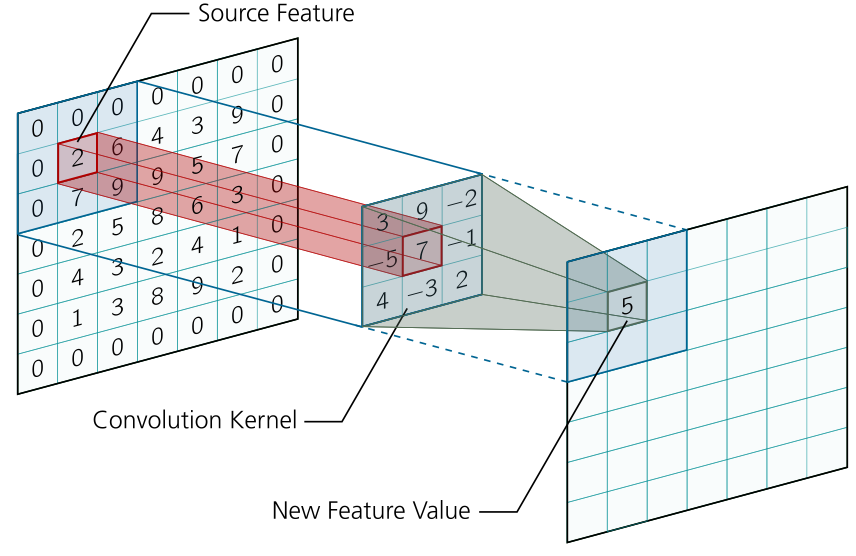

BatchNorm2d нормализует активации текущего слоя, чтобы их среднее значение было близко к 0, а дисперсия — к 1. Это позволяет ускорить обучение и сделать его более стабильным.
<li data-spm-anchor-id="a2ty_o01.29997173.0.i16.7df05171UNgjUK"><span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>X</mi></mrow><annotation encoding="application/x-tex"> X</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.6833em;"></span><span class="mord mathnormal" style="margin-right:0.07847em;">X</span></span></span></span> — входной тензор размером <span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>B</mi><mo>×</mo><mi>C</mi><mo>×</mo><mi>H</mi><mo>×</mo><mi>W</mi></mrow><annotation encoding="application/x-tex"> B \times C \times H \times W</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.7667em;vertical-align:-0.0833em;"></span><span class="mord mathnormal" style="margin-right:0.05017em;">B</span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mbin">×</span><span class="mspace" style="margin-right:0.2222em;"></span></span><span class="base"><span class="strut" style="height:0.7667em;vertical-align:-0.0833em;"></span><span class="mord mathnormal" style="margin-right:0.07153em;">C</span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mbin">×</span><span class="mspace" style="margin-right:0.2222em;"></span></span><span class="base"><span class="strut" style="height:0.7667em;vertical-align:-0.0833em;"></span><span class="mord mathnormal" style="margin-right:0.08125em;">H</span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mbin">×</span><span class="mspace" style="margin-right:0.2222em;"></span></span><span class="base"><span class="strut" style="height:0.6833em;"></span><span class="mord mathnormal" style="margin-right:0.13889em;">W</span></span></span></span>, где:<ul><li><span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>B</mi></mrow><annotation encoding="application/x-tex"> B</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.6833em;"></span><span class="mord mathnormal" style="margin-right:0.05017em;">B</span></span></span></span>: размер батча.</li><li><span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>C</mi></mrow><annotation encoding="application/x-tex"> C</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.6833em;"></span><span class="mord mathnormal" style="margin-right:0.07153em;">C</span></span></span></span>: количество каналов.</li><li><span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>H</mi></mrow><annotation encoding="application/x-tex"> H</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.6833em;"></span><span class="mord mathnormal" style="margin-right:0.08125em;">H</span></span></span></span>: высота.</li><li><span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>W</mi></mrow><annotation encoding="application/x-tex"> W</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.6833em;"></span><span class="mord mathnormal" style="margin-right:0.13889em;">W</span></span></span></span>: ширина.</li> </ul></li>

<p>Для каждого канала <span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>c</mi></mrow><annotation encoding="application/x-tex"> c</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.4306em;"></span><span class="mord mathnormal">c</span></span></span></span> выполняются следующие шаги: </p>

<p>Среднее значение (<span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><msub><mi>μ</mi><mi>c</mi></msub></mrow><annotation encoding="application/x-tex"> \mu_c</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.625em;vertical-align:-0.1944em;"></span><span class="mord"><span class="mord mathnormal">μ</span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.1514em;"><span style="top:-2.55em;margin-left:0em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mathnormal mtight">c</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.15em;"><span></span></span></span></span></span></span></span></span></span>) и дисперсия (<span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><msubsup><mi>σ</mi><mi>c</mi><mn>2</mn></msubsup></mrow><annotation encoding="application/x-tex"> \sigma_c^2</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:1.0611em;vertical-align:-0.247em;"></span><span class="mord"><span class="mord mathnormal" style="margin-right:0.03588em;">σ</span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.8141em;"><span style="top:-2.453em;margin-left:-0.0359em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mathnormal mtight">c</span></span></span><span style="top:-3.063em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight">2</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.247em;"><span></span></span></span></span></span></span></span></span></span>) для канала <span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>c</mi></mrow><annotation encoding="application/x-tex"> c</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.4306em;"></span><span class="mord mathnormal">c</span></span></span></span> вычисляются по всем элементам батча и пространственным координатам: </p>
<span class="katex-display"><span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><msub><mi>μ</mi><mi>c</mi></msub><mo>=</mo><mfrac><mn>1</mn><mrow><mi>B</mi><mo>⋅</mo><mi>H</mi><mo>⋅</mo><mi>W</mi></mrow></mfrac><munderover><mo>∑</mo><mrow><mi>b</mi><mo>=</mo><mn>1</mn></mrow><mi>B</mi></munderover><munderover><mo>∑</mo><mrow><mi>h</mi><mo>=</mo><mn>1</mn></mrow><mi>H</mi></munderover><munderover><mo>∑</mo><mrow><mi>w</mi><mo>=</mo><mn>1</mn></mrow><mi>W</mi></munderover><mi>X</mi><mo stretchy="false">[</mo><mi>b</mi><mo separator="true">,</mo><mi>c</mi><mo separator="true">,</mo><mi>h</mi><mo separator="true">,</mo><mi>w</mi><mo stretchy="false">]</mo></mrow><annotation encoding="application/x-tex">\mu_c = \frac{1}{B \cdot H \cdot W} \sum_{b=1}^{B} \sum_{h=1}^{H} \sum_{w=1}^{W} X[b, c, h, w]</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.625em;vertical-align:-0.1944em;"></span><span class="mord"><span class="mord mathnormal">μ</span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.1514em;"><span style="top:-2.55em;margin-left:0em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mathnormal mtight">c</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.15em;"><span></span></span></span></span></span></span><span class="mspace" style="margin-right:0.2778em;"></span><span class="mrel">=</span><span class="mspace" style="margin-right:0.2778em;"></span></span><span class="base"><span class="strut" style="height:3.1304em;vertical-align:-1.3021em;"></span><span class="mord"><span class="mopen nulldelimiter"></span><span class="mfrac"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:1.3214em;"><span style="top:-2.314em;"><span class="pstrut" style="height:3em;"></span><span class="mord"><span class="mord mathnormal" style="margin-right:0.05017em;">B</span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mbin">⋅</span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mord mathnormal" style="margin-right:0.08125em;">H</span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mbin">⋅</span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mord mathnormal" style="margin-right:0.13889em;">W</span></span></span><span style="top:-3.23em;"><span class="pstrut" style="height:3em;"></span><span class="frac-line" style="border-bottom-width:0.04em;"></span></span><span style="top:-3.677em;"><span class="pstrut" style="height:3em;"></span><span class="mord"><span class="mord">1</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.686em;"><span></span></span></span></span></span><span class="mclose nulldelimiter"></span></span><span class="mspace" style="margin-right:0.1667em;"></span><span class="mop op-limits"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:1.8283em;"><span style="top:-1.8479em;margin-left:0em;"><span class="pstrut" style="height:3.05em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight"><span class="mord mathnormal mtight">b</span><span class="mrel mtight">=</span><span class="mord mtight">1</span></span></span></span><span style="top:-3.05em;"><span class="pstrut" style="height:3.05em;"></span><span><span class="mop op-symbol large-op">∑</span></span></span><span style="top:-4.3em;margin-left:0em;"><span class="pstrut" style="height:3.05em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight"><span class="mord mathnormal mtight" style="margin-right:0.05017em;">B</span></span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:1.3021em;"><span></span></span></span></span></span><span class="mspace" style="margin-right:0.1667em;"></span><span class="mop op-limits"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:1.8283em;"><span style="top:-1.8479em;margin-left:0em;"><span class="pstrut" style="height:3.05em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight"><span class="mord mathnormal mtight">h</span><span class="mrel mtight">=</span><span class="mord mtight">1</span></span></span></span><span style="top:-3.05em;"><span class="pstrut" style="height:3.05em;"></span><span><span class="mop op-symbol large-op">∑</span></span></span><span style="top:-4.3em;margin-left:0em;"><span class="pstrut" style="height:3.05em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight"><span class="mord mathnormal mtight" style="margin-right:0.08125em;">H</span></span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:1.3021em;"><span></span></span></span></span></span><span class="mspace" style="margin-right:0.1667em;"></span><span class="mop op-limits"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:1.8283em;"><span style="top:-1.8829em;margin-left:0em;"><span class="pstrut" style="height:3.05em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight"><span class="mord mathnormal mtight" style="margin-right:0.02691em;">w</span><span class="mrel mtight">=</span><span class="mord mtight">1</span></span></span></span><span style="top:-3.05em;"><span class="pstrut" style="height:3.05em;"></span><span><span class="mop op-symbol large-op">∑</span></span></span><span style="top:-4.3em;margin-left:0em;"><span class="pstrut" style="height:3.05em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight"><span class="mord mathnormal mtight" style="margin-right:0.13889em;">W</span></span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:1.2671em;"><span></span></span></span></span></span><span class="mspace" style="margin-right:0.1667em;"></span><span class="mord mathnormal" style="margin-right:0.07847em;">X</span><span class="mopen">[</span><span class="mord mathnormal">b</span><span class="mpunct">,</span><span class="mspace" style="margin-right:0.1667em;"></span><span class="mord mathnormal">c</span><span class="mpunct">,</span><span class="mspace" style="margin-right:0.1667em;"></span><span class="mord mathnormal">h</span><span class="mpunct">,</span><span class="mspace" style="margin-right:0.1667em;"></span><span class="mord mathnormal" style="margin-right:0.02691em;">w</span><span class="mclose">]</span></span></span></span></span>
<span class="katex-display"><span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><msubsup><mi>σ</mi><mi>c</mi><mn>2</mn></msubsup><mo>=</mo><mfrac><mn>1</mn><mrow><mi>B</mi><mo>⋅</mo><mi>H</mi><mo>⋅</mo><mi>W</mi></mrow></mfrac><munderover><mo>∑</mo><mrow><mi>b</mi><mo>=</mo><mn>1</mn></mrow><mi>B</mi></munderover><munderover><mo>∑</mo><mrow><mi>h</mi><mo>=</mo><mn>1</mn></mrow><mi>H</mi></munderover><munderover><mo>∑</mo><mrow><mi>w</mi><mo>=</mo><mn>1</mn></mrow><mi>W</mi></munderover><msup><mrow><mo fence="true">(</mo><mi>X</mi><mo stretchy="false">[</mo><mi>b</mi><mo separator="true">,</mo><mi>c</mi><mo separator="true">,</mo><mi>h</mi><mo separator="true">,</mo><mi>w</mi><mo stretchy="false">]</mo><mo>−</mo><msub><mi>μ</mi><mi>c</mi></msub><mo fence="true">)</mo></mrow><mn>2</mn></msup></mrow><annotation encoding="application/x-tex">\sigma_c^2 = \frac{1}{B \cdot H \cdot W} \sum_{b=1}^{B} \sum_{h=1}^{H} \sum_{w=1}^{W} \left( X[b, c, h, w] - \mu_c \right)^2</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:1.1111em;vertical-align:-0.247em;"></span><span class="mord"><span class="mord mathnormal" style="margin-right:0.03588em;">σ</span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.8641em;"><span style="top:-2.453em;margin-left:-0.0359em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mathnormal mtight">c</span></span></span><span style="top:-3.113em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight">2</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.247em;"><span></span></span></span></span></span></span><span class="mspace" style="margin-right:0.2778em;"></span><span class="mrel">=</span><span class="mspace" style="margin-right:0.2778em;"></span></span><span class="base"><span class="strut" style="height:3.1304em;vertical-align:-1.3021em;"></span><span class="mord"><span class="mopen nulldelimiter"></span><span class="mfrac"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:1.3214em;"><span style="top:-2.314em;"><span class="pstrut" style="height:3em;"></span><span class="mord"><span class="mord mathnormal" style="margin-right:0.05017em;">B</span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mbin">⋅</span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mord mathnormal" style="margin-right:0.08125em;">H</span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mbin">⋅</span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mord mathnormal" style="margin-right:0.13889em;">W</span></span></span><span style="top:-3.23em;"><span class="pstrut" style="height:3em;"></span><span class="frac-line" style="border-bottom-width:0.04em;"></span></span><span style="top:-3.677em;"><span class="pstrut" style="height:3em;"></span><span class="mord"><span class="mord">1</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.686em;"><span></span></span></span></span></span><span class="mclose nulldelimiter"></span></span><span class="mspace" style="margin-right:0.1667em;"></span><span class="mop op-limits"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:1.8283em;"><span style="top:-1.8479em;margin-left:0em;"><span class="pstrut" style="height:3.05em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight"><span class="mord mathnormal mtight">b</span><span class="mrel mtight">=</span><span class="mord mtight">1</span></span></span></span><span style="top:-3.05em;"><span class="pstrut" style="height:3.05em;"></span><span><span class="mop op-symbol large-op">∑</span></span></span><span style="top:-4.3em;margin-left:0em;"><span class="pstrut" style="height:3.05em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight"><span class="mord mathnormal mtight" style="margin-right:0.05017em;">B</span></span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:1.3021em;"><span></span></span></span></span></span><span class="mspace" style="margin-right:0.1667em;"></span><span class="mop op-limits"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:1.8283em;"><span style="top:-1.8479em;margin-left:0em;"><span class="pstrut" style="height:3.05em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight"><span class="mord mathnormal mtight">h</span><span class="mrel mtight">=</span><span class="mord mtight">1</span></span></span></span><span style="top:-3.05em;"><span class="pstrut" style="height:3.05em;"></span><span><span class="mop op-symbol large-op">∑</span></span></span><span style="top:-4.3em;margin-left:0em;"><span class="pstrut" style="height:3.05em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight"><span class="mord mathnormal mtight" style="margin-right:0.08125em;">H</span></span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:1.3021em;"><span></span></span></span></span></span><span class="mspace" style="margin-right:0.1667em;"></span><span class="mop op-limits"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:1.8283em;"><span style="top:-1.8829em;margin-left:0em;"><span class="pstrut" style="height:3.05em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight"><span class="mord mathnormal mtight" style="margin-right:0.02691em;">w</span><span class="mrel mtight">=</span><span class="mord mtight">1</span></span></span></span><span style="top:-3.05em;"><span class="pstrut" style="height:3.05em;"></span><span><span class="mop op-symbol large-op">∑</span></span></span><span style="top:-4.3em;margin-left:0em;"><span class="pstrut" style="height:3.05em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight"><span class="mord mathnormal mtight" style="margin-right:0.13889em;">W</span></span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:1.2671em;"><span></span></span></span></span></span><span class="mspace" style="margin-right:0.1667em;"></span><span class="minner"><span class="minner"><span class="mopen delimcenter" style="top:0em;">(</span><span class="mord mathnormal" style="margin-right:0.07847em;">X</span><span class="mopen">[</span><span class="mord mathnormal">b</span><span class="mpunct">,</span><span class="mspace" style="margin-right:0.1667em;"></span><span class="mord mathnormal">c</span><span class="mpunct">,</span><span class="mspace" style="margin-right:0.1667em;"></span><span class="mord mathnormal">h</span><span class="mpunct">,</span><span class="mspace" style="margin-right:0.1667em;"></span><span class="mord mathnormal" style="margin-right:0.02691em;">w</span><span class="mclose">]</span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mbin">−</span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mord"><span class="mord mathnormal">μ</span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.1514em;"><span style="top:-2.55em;margin-left:0em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mathnormal mtight">c</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.15em;"><span></span></span></span></span></span></span><span class="mclose delimcenter" style="top:0em;">)</span></span><span class="msupsub"><span class="vlist-t"><span class="vlist-r"><span class="vlist" style="height:0.954em;"><span style="top:-3.2029em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight">2</span></span></span></span></span></span></span></span></span></span></span></span>
<p>Каждый элемент <span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>X</mi><mo stretchy="false">[</mo><mi>b</mi><mo separator="true">,</mo><mi>c</mi><mo separator="true">,</mo><mi>h</mi><mo separator="true">,</mo><mi>w</mi><mo stretchy="false">]</mo></mrow><annotation encoding="application/x-tex"> X[b, c, h, w]</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:1em;vertical-align:-0.25em;"></span><span class="mord mathnormal" style="margin-right:0.07847em;">X</span><span class="mopen">[</span><span class="mord mathnormal">b</span><span class="mpunct">,</span><span class="mspace" style="margin-right:0.1667em;"></span><span class="mord mathnormal">c</span><span class="mpunct">,</span><span class="mspace" style="margin-right:0.1667em;"></span><span class="mord mathnormal">h</span><span class="mpunct">,</span><span class="mspace" style="margin-right:0.1667em;"></span><span class="mord mathnormal" style="margin-right:0.02691em;">w</span><span class="mclose">]</span></span></span></span> нормализуется: </p>
<span class="katex-display"><span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><mover accent="true"><mi>X</mi><mo>^</mo></mover><mo stretchy="false">[</mo><mi>b</mi><mo separator="true">,</mo><mi>c</mi><mo separator="true">,</mo><mi>h</mi><mo separator="true">,</mo><mi>w</mi><mo stretchy="false">]</mo><mo>=</mo><mfrac><mrow><mi>X</mi><mo stretchy="false">[</mo><mi>b</mi><mo separator="true">,</mo><mi>c</mi><mo separator="true">,</mo><mi>h</mi><mo separator="true">,</mo><mi>w</mi><mo stretchy="false">]</mo><mo>−</mo><msub><mi>μ</mi><mi>c</mi></msub></mrow><msqrt><mrow><msubsup><mi>σ</mi><mi>c</mi><mn>2</mn></msubsup><mo>+</mo><mi>ϵ</mi></mrow></msqrt></mfrac></mrow><annotation encoding="application/x-tex">\hat{X}[b, c, h, w] = \frac{X[b, c, h, w] - \mu_c}{\sqrt{\sigma_c^2 + \epsilon}}</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:1.1968em;vertical-align:-0.25em;"></span><span class="mord accent"><span class="vlist-t"><span class="vlist-r"><span class="vlist" style="height:0.9468em;"><span style="top:-3em;"><span class="pstrut" style="height:3em;"></span><span class="mord mathnormal" style="margin-right:0.07847em;">X</span></span><span style="top:-3.2523em;"><span class="pstrut" style="height:3em;"></span><span class="accent-body" style="left:-0.1667em;"><span class="mord">^</span></span></span></span></span></span></span><span class="mopen">[</span><span class="mord mathnormal">b</span><span class="mpunct">,</span><span class="mspace" style="margin-right:0.1667em;"></span><span class="mord mathnormal">c</span><span class="mpunct">,</span><span class="mspace" style="margin-right:0.1667em;"></span><span class="mord mathnormal">h</span><span class="mpunct">,</span><span class="mspace" style="margin-right:0.1667em;"></span><span class="mord mathnormal" style="margin-right:0.02691em;">w</span><span class="mclose">]</span><span class="mspace" style="margin-right:0.2778em;"></span><span class="mrel">=</span><span class="mspace" style="margin-right:0.2778em;"></span></span><span class="base"><span class="strut" style="height:2.557em;vertical-align:-1.13em;"></span><span class="mord"><span class="mopen nulldelimiter"></span><span class="mfrac"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:1.427em;"><span style="top:-2.1784em;"><span class="pstrut" style="height:3em;"></span><span class="mord"><span class="mord sqrt"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.9316em;"><span class="svg-align" style="top:-3.2em;"><span class="pstrut" style="height:3.2em;"></span><span class="mord" style="padding-left:1em;"><span class="mord"><span class="mord mathnormal" style="margin-right:0.03588em;">σ</span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.7401em;"><span style="top:-2.453em;margin-left:-0.0359em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mathnormal mtight">c</span></span></span><span style="top:-2.989em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight">2</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.247em;"><span></span></span></span></span></span></span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mbin">+</span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mord mathnormal">ϵ</span></span></span><span style="top:-2.8916em;"><span class="pstrut" style="height:3.2em;"></span><span class="hide-tail" style="min-width:1.02em;height:1.28em;"><svg xmlns="http://www.w3.org/2000/svg" width="400em" height="1.28em" viewBox="0 0 400000 1296" preserveAspectRatio="xMinYMin slice"><path d="M263,681c0.7,0,18,39.7,52,119
c34,79.3,68.167,158.7,102.5,238c34.3,79.3,51.8,119.3,52.5,120
c340,-704.7,510.7,-1060.3,512,-1067
l0 -0
c4.7,-7.3,11,-11,19,-11
H40000v40H1012.3
s-271.3,567,-271.3,567c-38.7,80.7,-84,175,-136,283c-52,108,-89.167,185.3,-111.5,232
c-22.3,46.7,-33.8,70.3,-34.5,71c-4.7,4.7,-12.3,7,-23,7s-12,-1,-12,-1
s-109,-253,-109,-253c-72.7,-168,-109.3,-252,-110,-252c-10.7,8,-22,16.7,-34,26
c-22,17.3,-33.3,26,-34,26s-26,-26,-26,-26s76,-59,76,-59s76,-60,76,-60z
M1001 80h400000v40h-400000z"></path></svg></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.3084em;"><span></span></span></span></span></span></span></span><span style="top:-3.23em;"><span class="pstrut" style="height:3em;"></span><span class="frac-line" style="border-bottom-width:0.04em;"></span></span><span style="top:-3.677em;"><span class="pstrut" style="height:3em;"></span><span class="mord"><span class="mord mathnormal" style="margin-right:0.07847em;">X</span><span class="mopen">[</span><span class="mord mathnormal">b</span><span class="mpunct">,</span><span class="mspace" style="margin-right:0.1667em;"></span><span class="mord mathnormal">c</span><span class="mpunct">,</span><span class="mspace" style="margin-right:0.1667em;"></span><span class="mord mathnormal">h</span><span class="mpunct">,</span><span class="mspace" style="margin-right:0.1667em;"></span><span class="mord mathnormal" style="margin-right:0.02691em;">w</span><span class="mclose">]</span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mbin">−</span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mord"><span class="mord mathnormal">μ</span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.1514em;"><span style="top:-2.55em;margin-left:0em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mathnormal mtight">c</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.15em;"><span></span></span></span></span></span></span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:1.13em;"><span></span></span></span></span></span><span class="mclose nulldelimiter"></span></span></span></span></span></span>
<p>Нормализованные значения масштабируются и сдвигаются с помощью обучаемых параметров <span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><msub><mi>γ</mi><mi>c</mi></msub></mrow><annotation encoding="application/x-tex"> \gamma_c</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.625em;vertical-align:-0.1944em;"></span><span class="mord"><span class="mord mathnormal" style="margin-right:0.05556em;">γ</span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.1514em;"><span style="top:-2.55em;margin-left:-0.0556em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mathnormal mtight">c</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.15em;"><span></span></span></span></span></span></span></span></span></span> (scale) и <span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><msub><mi>β</mi><mi>c</mi></msub></mrow><annotation encoding="application/x-tex"> \beta_c</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.8889em;vertical-align:-0.1944em;"></span><span class="mord"><span class="mord mathnormal" style="margin-right:0.05278em;">β</span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.1514em;"><span style="top:-2.55em;margin-left:-0.0528em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mathnormal mtight">c</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.15em;"><span></span></span></span></span></span></span></span></span></span> (bias): </p>
<span class="katex-display"><span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><mi>Y</mi><mo stretchy="false">[</mo><mi>b</mi><mo separator="true">,</mo><mi>c</mi><mo separator="true">,</mo><mi>h</mi><mo separator="true">,</mo><mi>w</mi><mo stretchy="false">]</mo><mo>=</mo><msub><mi>γ</mi><mi>c</mi></msub><mo>⋅</mo><mover accent="true"><mi>X</mi><mo>^</mo></mover><mo stretchy="false">[</mo><mi>b</mi><mo separator="true">,</mo><mi>c</mi><mo separator="true">,</mo><mi>h</mi><mo separator="true">,</mo><mi>w</mi><mo stretchy="false">]</mo><mo>+</mo><msub><mi>β</mi><mi>c</mi></msub></mrow><annotation encoding="application/x-tex">Y[b, c, h, w] = \gamma_c \cdot \hat{X}[b, c, h, w] + \beta_c</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:1em;vertical-align:-0.25em;"></span><span class="mord mathnormal" style="margin-right:0.22222em;">Y</span><span class="mopen">[</span><span class="mord mathnormal">b</span><span class="mpunct">,</span><span class="mspace" style="margin-right:0.1667em;"></span><span class="mord mathnormal">c</span><span class="mpunct">,</span><span class="mspace" style="margin-right:0.1667em;"></span><span class="mord mathnormal">h</span><span class="mpunct">,</span><span class="mspace" style="margin-right:0.1667em;"></span><span class="mord mathnormal" style="margin-right:0.02691em;">w</span><span class="mclose">]</span><span class="mspace" style="margin-right:0.2778em;"></span><span class="mrel">=</span><span class="mspace" style="margin-right:0.2778em;"></span></span><span class="base"><span class="strut" style="height:0.6389em;vertical-align:-0.1944em;"></span><span class="mord"><span class="mord mathnormal" style="margin-right:0.05556em;">γ</span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.1514em;"><span style="top:-2.55em;margin-left:-0.0556em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mathnormal mtight">c</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.15em;"><span></span></span></span></span></span></span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mbin">⋅</span><span class="mspace" style="margin-right:0.2222em;"></span></span><span class="base"><span class="strut" style="height:1.1968em;vertical-align:-0.25em;"></span><span class="mord accent"><span class="vlist-t"><span class="vlist-r"><span class="vlist" style="height:0.9468em;"><span style="top:-3em;"><span class="pstrut" style="height:3em;"></span><span class="mord mathnormal" style="margin-right:0.07847em;">X</span></span><span style="top:-3.2523em;"><span class="pstrut" style="height:3em;"></span><span class="accent-body" style="left:-0.1667em;"><span class="mord">^</span></span></span></span></span></span></span><span class="mopen">[</span><span class="mord mathnormal">b</span><span class="mpunct">,</span><span class="mspace" style="margin-right:0.1667em;"></span><span class="mord mathnormal">c</span><span class="mpunct">,</span><span class="mspace" style="margin-right:0.1667em;"></span><span class="mord mathnormal">h</span><span class="mpunct">,</span><span class="mspace" style="margin-right:0.1667em;"></span><span class="mord mathnormal" style="margin-right:0.02691em;">w</span><span class="mclose">]</span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mbin">+</span><span class="mspace" style="margin-right:0.2222em;"></span></span><span class="base"><span class="strut" style="height:0.8889em;vertical-align:-0.1944em;"></span><span class="mord"><span class="mord mathnormal" style="margin-right:0.05278em;">β</span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.1514em;"><span style="top:-2.55em;margin-left:-0.0528em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mathnormal mtight">c</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.15em;"><span></span></span></span></span></span></span></span></span></span></span>
<ul><li><span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><msub><mi>γ</mi><mi>c</mi></msub></mrow><annotation encoding="application/x-tex"> \gamma_c</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.625em;vertical-align:-0.1944em;"></span><span class="mord"><span class="mord mathnormal" style="margin-right:0.05556em;">γ</span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.1514em;"><span style="top:-2.55em;margin-left:-0.0556em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mathnormal mtight">c</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.15em;"><span></span></span></span></span></span></span></span></span></span> и <span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><msub><mi>β</mi><mi>c</mi></msub></mrow><annotation encoding="application/x-tex"> \beta_c</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.8889em;vertical-align:-0.1944em;"></span><span class="mord"><span class="mord mathnormal" style="margin-right:0.05278em;">β</span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.1514em;"><span style="top:-2.55em;margin-left:-0.0528em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mathnormal mtight">c</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.15em;"><span></span></span></span></span></span></span></span></span></span>: обучаемые параметры для каждого канала <span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>c</mi></mrow><annotation encoding="application/x-tex"> c</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.4306em;"></span><span class="mord mathnormal">c</span></span></span></span>.</li> </ul>

<p data-spm-anchor-id="a2ty_o01.29997173.0.i19.7df05171UNgjUK"><code class="codespan cursor-pointer z-[9] relative">MaxPool2d</code> — это операция <strong>максимального пулинга </strong> (max pooling), которая используется в свёрточных нейронных сетях (CNN) для уменьшения пространственных размеров данных. Она помогает снизить вычислительную сложность, добавить инвариантность к небольшим смещениям и уменьшить риск переобучения. </p>
<p>Для каждого канала <span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>c</mi></mrow><annotation encoding="application/x-tex"> c</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.4306em;"></span><span class="mord mathnormal">c</span></span></span></span> и каждого окна <span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mo stretchy="false">(</mo><mi>i</mi><mo separator="true">,</mo><mi>j</mi><mo stretchy="false">)</mo></mrow><annotation encoding="application/x-tex"> (i, j)</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:1em;vertical-align:-0.25em;"></span><span class="mopen">(</span><span class="mord mathnormal">i</span><span class="mpunct">,</span><span class="mspace" style="margin-right:0.1667em;"></span><span class="mord mathnormal" style="margin-right:0.05724em;">j</span><span class="mclose">)</span></span></span></span>: </p>
<span class="katex-display"><span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><mi>Y</mi><mo stretchy="false">[</mo><mi>b</mi><mo separator="true">,</mo><mi>c</mi><mo separator="true">,</mo><mi>i</mi><mo separator="true">,</mo><mi>j</mi><mo stretchy="false">]</mo><mo>=</mo><munderover><mrow><mi>max</mi><mo>⁡</mo></mrow><mrow><mi>m</mi><mo>=</mo><mn>0</mn></mrow><mrow><msub><mi>K</mi><mi>h</mi></msub><mo>−</mo><mn>1</mn></mrow></munderover><munderover><mrow><mi>max</mi><mo>⁡</mo></mrow><mrow><mi>n</mi><mo>=</mo><mn>0</mn></mrow><mrow><msub><mi>K</mi><mi>w</mi></msub><mo>−</mo><mn>1</mn></mrow></munderover><mi>X</mi><mo stretchy="false">[</mo><mi>b</mi><mo separator="true">,</mo><mi>c</mi><mo separator="true">,</mo><mi>s</mi><mo>⋅</mo><mi>i</mi><mo>+</mo><mi>m</mi><mo separator="true">,</mo><mi>s</mi><mo>⋅</mo><mi>j</mi><mo>+</mo><mi>n</mi><mo stretchy="false">]</mo></mrow><annotation encoding="application/x-tex">Y[b, c, i, j] = \max_{m=0}^{K_h-1} \max_{n=0}^{K_w-1} X[b, c, s \cdot i + m, s \cdot j + n]</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:1em;vertical-align:-0.25em;"></span><span class="mord mathnormal" style="margin-right:0.22222em;">Y</span><span class="mopen">[</span><span class="mord mathnormal">b</span><span class="mpunct">,</span><span class="mspace" style="margin-right:0.1667em;"></span><span class="mord mathnormal">c</span><span class="mpunct">,</span><span class="mspace" style="margin-right:0.1667em;"></span><span class="mord mathnormal">i</span><span class="mpunct">,</span><span class="mspace" style="margin-right:0.1667em;"></span><span class="mord mathnormal" style="margin-right:0.05724em;">j</span><span class="mclose">]</span><span class="mspace" style="margin-right:0.2778em;"></span><span class="mrel">=</span><span class="mspace" style="margin-right:0.2778em;"></span></span><span class="base"><span class="strut" style="height:1.9429em;vertical-align:-0.7171em;"></span><span class="mop op-limits"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:1.2258em;"><span style="top:-2.3829em;margin-left:0em;"><span class="pstrut" style="height:3em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight"><span class="mord mathnormal mtight">m</span><span class="mrel mtight">=</span><span class="mord mtight">0</span></span></span></span><span style="top:-3em;"><span class="pstrut" style="height:3em;"></span><span><span class="mop">max</span></span></span><span style="top:-3.6474em;margin-left:0em;"><span class="pstrut" style="height:3em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight"><span class="mord mtight"><span class="mord mathnormal mtight" style="margin-right:0.07153em;">K</span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.3448em;"><span style="top:-2.3488em;margin-left:-0.0715em;margin-right:0.0714em;"><span class="pstrut" style="height:2.5em;"></span><span class="sizing reset-size3 size1 mtight"><span class="mord mathnormal mtight">h</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.1512em;"><span></span></span></span></span></span></span><span class="mbin mtight">−</span><span class="mord mtight">1</span></span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.7171em;"><span></span></span></span></span></span><span class="mspace" style="margin-right:0.1667em;"></span><span class="mop op-limits"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:1.22em;"><span style="top:-2.3829em;margin-left:0em;"><span class="pstrut" style="height:3em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight"><span class="mord mathnormal mtight">n</span><span class="mrel mtight">=</span><span class="mord mtight">0</span></span></span></span><span style="top:-3em;"><span class="pstrut" style="height:3em;"></span><span><span class="mop">max</span></span></span><span style="top:-3.6417em;margin-left:0em;"><span class="pstrut" style="height:3em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight"><span class="mord mtight"><span class="mord mathnormal mtight" style="margin-right:0.07153em;">K</span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.1645em;"><span style="top:-2.357em;margin-left:-0.0715em;margin-right:0.0714em;"><span class="pstrut" style="height:2.5em;"></span><span class="sizing reset-size3 size1 mtight"><span class="mord mathnormal mtight" style="margin-right:0.02691em;">w</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.143em;"><span></span></span></span></span></span></span><span class="mbin mtight">−</span><span class="mord mtight">1</span></span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.7171em;"><span></span></span></span></span></span><span class="mspace" style="margin-right:0.1667em;"></span><span class="mord mathnormal" style="margin-right:0.07847em;">X</span><span class="mopen">[</span><span class="mord mathnormal">b</span><span class="mpunct">,</span><span class="mspace" style="margin-right:0.1667em;"></span><span class="mord mathnormal">c</span><span class="mpunct">,</span><span class="mspace" style="margin-right:0.1667em;"></span><span class="mord mathnormal">s</span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mbin">⋅</span><span class="mspace" style="margin-right:0.2222em;"></span></span><span class="base"><span class="strut" style="height:0.7429em;vertical-align:-0.0833em;"></span><span class="mord mathnormal">i</span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mbin">+</span><span class="mspace" style="margin-right:0.2222em;"></span></span><span class="base"><span class="strut" style="height:0.6389em;vertical-align:-0.1944em;"></span><span class="mord mathnormal">m</span><span class="mpunct">,</span><span class="mspace" style="margin-right:0.1667em;"></span><span class="mord mathnormal">s</span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mbin">⋅</span><span class="mspace" style="margin-right:0.2222em;"></span></span><span class="base"><span class="strut" style="height:0.854em;vertical-align:-0.1944em;"></span><span class="mord mathnormal" style="margin-right:0.05724em;">j</span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mbin">+</span><span class="mspace" style="margin-right:0.2222em;"></span></span><span class="base"><span class="strut" style="height:1em;vertical-align:-0.25em;"></span><span class="mord mathnormal">n</span><span class="mclose">]</span></span></span></span></span>
<ul><li><span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><msub><mi>K</mi><mi>h</mi></msub><mo>×</mo><msub><mi>K</mi><mi>w</mi></msub></mrow><annotation encoding="application/x-tex"> K_h \times K_w</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.8333em;vertical-align:-0.15em;"></span><span class="mord"><span class="mord mathnormal" style="margin-right:0.07153em;">K</span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.3361em;"><span style="top:-2.55em;margin-left:-0.0715em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mathnormal mtight">h</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.15em;"><span></span></span></span></span></span></span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mbin">×</span><span class="mspace" style="margin-right:0.2222em;"></span></span><span class="base"><span class="strut" style="height:0.8333em;vertical-align:-0.15em;"></span><span class="mord"><span class="mord mathnormal" style="margin-right:0.07153em;">K</span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.1514em;"><span style="top:-2.55em;margin-left:-0.0715em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mathnormal mtight" style="margin-right:0.02691em;">w</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.15em;"><span></span></span></span></span></span></span></span></span></span>: размер окна пулинга.</li><li><span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>s</mi></mrow><annotation encoding="application/x-tex"> s</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.4306em;"></span><span class="mord mathnormal">s</span></span></span></span>: шаг (stride).</li><li><span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>b</mi></mrow><annotation encoding="application/x-tex"> b</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.6944em;"></span><span class="mord mathnormal">b</span></span></span></span>: индекс батча.</li><li><span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>c</mi></mrow><annotation encoding="application/x-tex"> c</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.4306em;"></span><span class="mord mathnormal">c</span></span></span></span>: индекс канала.</li><li><span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>i</mi><mo separator="true">,</mo><mi>j</mi></mrow><annotation encoding="application/x-tex"> i, j</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.854em;vertical-align:-0.1944em;"></span><span class="mord mathnormal">i</span><span class="mpunct">,</span><span class="mspace" style="margin-right:0.1667em;"></span><span class="mord mathnormal" style="margin-right:0.05724em;">j</span></span></span></span>: координаты выходного тензора.</li> </ul>

<ul><li>Окно пулинга — это маленькая матрица (например, <span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mn>2</mn><mo>×</mo><mn>2</mn></mrow><annotation encoding="application/x-tex"> 2 \times 2</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.7278em;vertical-align:-0.0833em;"></span><span class="mord">2</span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mbin">×</span><span class="mspace" style="margin-right:0.2222em;"></span></span><span class="base"><span class="strut" style="height:0.6444em;"></span><span class="mord">2</span></span></span></span>), которая "скользит" по входному тензору.</li><li>Для каждого положения окна выбирается максимальное значение.</li> </ul>

<ul><li>Шаг определяет, на сколько пикселей окно перемещается после обработки текущего положения. Например:<ul><li><span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>s</mi><mo>=</mo><mn>1</mn></mrow><annotation encoding="application/x-tex"> s = 1</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.4306em;"></span><span class="mord mathnormal">s</span><span class="mspace" style="margin-right:0.2778em;"></span><span class="mrel">=</span><span class="mspace" style="margin-right:0.2778em;"></span></span><span class="base"><span class="strut" style="height:0.6444em;"></span><span class="mord">1</span></span></span></span>: окно сдвигается на 1 пиксель.</li><li><span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>s</mi><mo>=</mo><mn>2</mn></mrow><annotation encoding="application/x-tex"> s = 2</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.4306em;"></span><span class="mord mathnormal">s</span><span class="mspace" style="margin-right:0.2778em;"></span><span class="mrel">=</span><span class="mspace" style="margin-right:0.2778em;"></span></span><span class="base"><span class="strut" style="height:0.6444em;"></span><span class="mord">2</span></span></span></span>: окно пропускает 1 пиксель.</li> </ul></li> </ul>

# Преимущества

<ol start="1"><li><p><strong data-spm-anchor-id="a2ty_o01.29997173.0.i22.7df05171UNgjUK">Уменьшение размерности </strong>: </p><ul><li>Снижает вычислительную сложность сети.</li><li>Уменьшает количество параметров в последующих слоях.</li> </ul></li><li><p><strong>Инвариантность к смещению </strong>: </p><ul><li>Делает модель менее чувствительной к небольшим смещениям объектов.</li> </ul></li><li><p><strong>Регуляризация </strong>: </p><ul><li data-spm-anchor-id="a2ty_o01.29997173.0.i21.7df05171UNgjUK">Уменьшает риск переобучения за счёт отбора наиболее значимых признаков.</li> </ul></li> </ol>

<p data-spm-anchor-id="a2ty_o01.29997173.0.i20.7df05171UNgjUK"><code class="codespan cursor-pointer z-[9] relative">MaxPool2d</code> — это операция, которая выбирает максимальное значение из локальных областей входного тензора. Она используется для уменьшения пространственных размеров данных, снижения вычислительной сложности и добавления инвариантности к небольшим смещениям. Математически это реализуется через скользящее окно, которое выбирает максимальное значение для каждой области. </p>

In [68]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)

<div><p>Давайте разберем математическую основу для этих двух строк: </p><div class="my-2"></div><ol start="1"><li><strong><code class="codespan cursor-pointer z-[9] relative">criterion = nn.CrossEntropyLoss()</code> </strong> — это функция потерь, используемая для задач классификации.</li><li><strong><code class="codespan cursor-pointer z-[9] relative">optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)</code> </strong> — это оптимизатор, который обновляет параметры модели на основе градиентов.</li> </ol><div class="my-2"></div><hr><h3>1. <strong><code class="codespan cursor-pointer z-[9] relative">nn.CrossEntropyLoss()</code> </strong> </h3><h4>a) <strong data-spm-anchor-id="a2ty_o01.29997173.0.i23.7df05171UNgjUK">Что делает CrossEntropyLoss? </strong> </h4><p>CrossEntropyLoss объединяет два шага: </p><ol start="1"><li><strong>LogSoftmax </strong>: Преобразует выходы модели в вероятности с помощью softmax.</li><li><strong>Negative Log Likelihood (NLL) </strong>: Вычисляет отрицательный логарифм правдоподобия для истинного класса.</li> </ol><div class="my-2"></div><h4>b) <strong>Математическая формула </strong> </h4><p>Пусть: </p><ul><li><span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>y</mi></mrow><annotation encoding="application/x-tex"> y</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.625em;vertical-align:-0.1944em;"></span><span class="mord mathnormal" style="margin-right:0.03588em;">y</span></span></span></span>: истинные метки (классы).</li><li><span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mover accent="true"><mi>y</mi><mo>^</mo></mover></mrow><annotation encoding="application/x-tex"> \hat{y}</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.8889em;vertical-align:-0.1944em;"></span><span class="mord accent"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.6944em;"><span style="top:-3em;"><span class="pstrut" style="height:3em;"></span><span class="mord mathnormal" style="margin-right:0.03588em;">y</span></span><span style="top:-3em;"><span class="pstrut" style="height:3em;"></span><span class="accent-body" style="left:-0.1944em;"><span class="mord">^</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.1944em;"><span></span></span></span></span></span></span></span></span>: предсказания модели (логиты).</li><li><span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>C</mi></mrow><annotation encoding="application/x-tex"> C</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.6833em;"></span><span class="mord mathnormal" style="margin-right:0.07153em;">C</span></span></span></span>: количество классов.</li> </ul><div class="my-2"></div><p>Функция потерь для одного примера выглядит так: </p><span class="katex-display"><span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><mtext>CrossEntropyLoss</mtext><mo stretchy="false">(</mo><mi>y</mi><mo separator="true">,</mo><mover accent="true"><mi>y</mi><mo>^</mo></mover><mo stretchy="false">)</mo><mo>=</mo><mo>−</mo><mi>log</mi><mo>⁡</mo><mrow><mo fence="true">(</mo><mfrac><mrow><mi>exp</mi><mo>⁡</mo><mo stretchy="false">(</mo><msub><mover accent="true"><mi>y</mi><mo>^</mo></mover><mi>y</mi></msub><mo stretchy="false">)</mo></mrow><mrow><munderover><mo>∑</mo><mrow><mi>j</mi><mo>=</mo><mn>1</mn></mrow><mi>C</mi></munderover><mi>exp</mi><mo>⁡</mo><mo stretchy="false">(</mo><msub><mover accent="true"><mi>y</mi><mo>^</mo></mover><mi>j</mi></msub><mo stretchy="false">)</mo></mrow></mfrac><mo fence="true">)</mo></mrow></mrow><annotation encoding="application/x-tex">\text{CrossEntropyLoss}(y, \hat{y}) = -\log\left(\frac{\exp(\hat{y}_y)}{\sum_{j=1}^{C} \exp(\hat{y}_j)}\right)</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:1em;vertical-align:-0.25em;"></span><span class="mord text"><span class="mord">CrossEntropyLoss</span></span><span class="mopen">(</span><span class="mord mathnormal" style="margin-right:0.03588em;">y</span><span class="mpunct">,</span><span class="mspace" style="margin-right:0.1667em;"></span><span class="mord accent"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.6944em;"><span style="top:-3em;"><span class="pstrut" style="height:3em;"></span><span class="mord mathnormal" style="margin-right:0.03588em;">y</span></span><span style="top:-3em;"><span class="pstrut" style="height:3em;"></span><span class="accent-body" style="left:-0.1944em;"><span class="mord">^</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.1944em;"><span></span></span></span></span></span><span class="mclose">)</span><span class="mspace" style="margin-right:0.2778em;"></span><span class="mrel">=</span><span class="mspace" style="margin-right:0.2778em;"></span></span><span class="base"><span class="strut" style="height:3.057em;vertical-align:-1.307em;"></span><span class="mord">−</span><span class="mspace" style="margin-right:0.1667em;"></span><span class="mop">lo<span style="margin-right:0.01389em;">g</span></span><span class="mspace" style="margin-right:0.1667em;"></span><span class="minner"><span class="mopen delimcenter" style="top:0em;"><span class="delimsizing size4">(</span></span><span class="mord"><span class="mopen nulldelimiter"></span><span class="mfrac"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:1.427em;"><span style="top:-2.1288em;"><span class="pstrut" style="height:3em;"></span><span class="mord"><span class="mop"><span class="mop op-symbol small-op" style="position:relative;top:0em;">∑</span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.9812em;"><span style="top:-2.4003em;margin-left:0em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight"><span class="mord mathnormal mtight" style="margin-right:0.05724em;">j</span><span class="mrel mtight">=</span><span class="mord mtight">1</span></span></span></span><span style="top:-3.2029em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight"><span class="mord mathnormal mtight" style="margin-right:0.07153em;">C</span></span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.4358em;"><span></span></span></span></span></span></span><span class="mspace" style="margin-right:0.1667em;"></span><span class="mop">exp</span><span class="mopen">(</span><span class="mord"><span class="mord accent"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.6944em;"><span style="top:-3em;"><span class="pstrut" style="height:3em;"></span><span class="mord mathnormal" style="margin-right:0.03588em;">y</span></span><span style="top:-3em;"><span class="pstrut" style="height:3em;"></span><span class="accent-body" style="left:-0.1944em;"><span class="mord">^</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.1944em;"><span></span></span></span></span></span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.3117em;"><span style="top:-2.55em;margin-left:-0.0359em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mathnormal mtight" style="margin-right:0.05724em;">j</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.2861em;"><span></span></span></span></span></span></span><span class="mclose">)</span></span></span><span style="top:-3.23em;"><span class="pstrut" style="height:3em;"></span><span class="frac-line" style="border-bottom-width:0.04em;"></span></span><span style="top:-3.677em;"><span class="pstrut" style="height:3em;"></span><span class="mord"><span class="mop">exp</span><span class="mopen">(</span><span class="mord"><span class="mord accent"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.6944em;"><span style="top:-3em;"><span class="pstrut" style="height:3em;"></span><span class="mord mathnormal" style="margin-right:0.03588em;">y</span></span><span style="top:-3em;"><span class="pstrut" style="height:3em;"></span><span class="accent-body" style="left:-0.1944em;"><span class="mord">^</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.1944em;"><span></span></span></span></span></span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.1514em;"><span style="top:-2.55em;margin-left:-0.0359em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mathnormal mtight" style="margin-right:0.03588em;">y</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.2861em;"><span></span></span></span></span></span></span><span class="mclose">)</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:1.307em;"><span></span></span></span></span></span><span class="mclose nulldelimiter"></span></span><span class="mclose delimcenter" style="top:0em;"><span class="delimsizing size4">)</span></span></span></span></span></span></span><div class="my-2"></div><p>Где: </p><ul><li><span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><msub><mover accent="true"><mi>y</mi><mo>^</mo></mover><mi>y</mi></msub></mrow><annotation encoding="application/x-tex"> \hat{y}_y</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.9805em;vertical-align:-0.2861em;"></span><span class="mord"><span class="mord accent"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.6944em;"><span style="top:-3em;"><span class="pstrut" style="height:3em;"></span><span class="mord mathnormal" style="margin-right:0.03588em;">y</span></span><span style="top:-3em;"><span class="pstrut" style="height:3em;"></span><span class="accent-body" style="left:-0.1944em;"><span class="mord">^</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.1944em;"><span></span></span></span></span></span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.1514em;"><span style="top:-2.55em;margin-left:-0.0359em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mathnormal mtight" style="margin-right:0.03588em;">y</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.2861em;"><span></span></span></span></span></span></span></span></span></span>: значение логита для истинного класса <span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>y</mi></mrow><annotation encoding="application/x-tex"> y</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.625em;vertical-align:-0.1944em;"></span><span class="mord mathnormal" style="margin-right:0.03588em;">y</span></span></span></span>.</li><li><span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><msubsup><mo>∑</mo><mrow><mi>j</mi><mo>=</mo><mn>1</mn></mrow><mi>C</mi></msubsup><mi>exp</mi><mo>⁡</mo><mo stretchy="false">(</mo><msub><mover accent="true"><mi>y</mi><mo>^</mo></mover><mi>j</mi></msub><mo stretchy="false">)</mo></mrow><annotation encoding="application/x-tex"> \sum_{j=1}^{C} \exp(\hat{y}_j)</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:1.417em;vertical-align:-0.4358em;"></span><span class="mop"><span class="mop op-symbol small-op" style="position:relative;top:0em;">∑</span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.9812em;"><span style="top:-2.4003em;margin-left:0em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight"><span class="mord mathnormal mtight" style="margin-right:0.05724em;">j</span><span class="mrel mtight">=</span><span class="mord mtight">1</span></span></span></span><span style="top:-3.2029em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight"><span class="mord mathnormal mtight" style="margin-right:0.07153em;">C</span></span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.4358em;"><span></span></span></span></span></span></span><span class="mspace" style="margin-right:0.1667em;"></span><span class="mop">exp</span><span class="mopen">(</span><span class="mord"><span class="mord accent"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.6944em;"><span style="top:-3em;"><span class="pstrut" style="height:3em;"></span><span class="mord mathnormal" style="margin-right:0.03588em;">y</span></span><span style="top:-3em;"><span class="pstrut" style="height:3em;"></span><span class="accent-body" style="left:-0.1944em;"><span class="mord">^</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.1944em;"><span></span></span></span></span></span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.3117em;"><span style="top:-2.55em;margin-left:-0.0359em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mathnormal mtight" style="margin-right:0.05724em;">j</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.2861em;"><span></span></span></span></span></span></span><span class="mclose">)</span></span></span></span>: сумма экспонент всех логитов (softmax).</li> </ul><div class="my-2"></div><p>Для батча из <span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>N</mi></mrow><annotation encoding="application/x-tex"> N</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.6833em;"></span><span class="mord mathnormal" style="margin-right:0.10903em;">N</span></span></span></span> примеров средняя ошибка вычисляется как: </p><span class="katex-display"><span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><mtext>CrossEntropyLoss</mtext><mo>=</mo><mo>−</mo><mfrac><mn>1</mn><mi>N</mi></mfrac><munderover><mo>∑</mo><mrow><mi>i</mi><mo>=</mo><mn>1</mn></mrow><mi>N</mi></munderover><mi>log</mi><mo>⁡</mo><mrow><mo fence="true">(</mo><mfrac><mrow><mi>exp</mi><mo>⁡</mo><mo stretchy="false">(</mo><msub><mover accent="true"><mi>y</mi><mo>^</mo></mover><mrow><mi>i</mi><mo separator="true">,</mo><msub><mi>y</mi><mi>i</mi></msub></mrow></msub><mo stretchy="false">)</mo></mrow><mrow><munderover><mo>∑</mo><mrow><mi>j</mi><mo>=</mo><mn>1</mn></mrow><mi>C</mi></munderover><mi>exp</mi><mo>⁡</mo><mo stretchy="false">(</mo><msub><mover accent="true"><mi>y</mi><mo>^</mo></mover><mrow><mi>i</mi><mo separator="true">,</mo><mi>j</mi></mrow></msub><mo stretchy="false">)</mo></mrow></mfrac><mo fence="true">)</mo></mrow></mrow><annotation encoding="application/x-tex">\text{CrossEntropyLoss} = -\frac{1}{N} \sum_{i=1}^{N} \log\left(\frac{\exp(\hat{y}_{i,y_i})}{\sum_{j=1}^{C} \exp(\hat{y}_{i,j})}\right)</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.8778em;vertical-align:-0.1944em;"></span><span class="mord text"><span class="mord">CrossEntropyLoss</span></span><span class="mspace" style="margin-right:0.2778em;"></span><span class="mrel">=</span><span class="mspace" style="margin-right:0.2778em;"></span></span><span class="base"><span class="strut" style="height:3.1354em;vertical-align:-1.307em;"></span><span class="mord">−</span><span class="mord"><span class="mopen nulldelimiter"></span><span class="mfrac"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:1.3214em;"><span style="top:-2.314em;"><span class="pstrut" style="height:3em;"></span><span class="mord"><span class="mord mathnormal" style="margin-right:0.10903em;">N</span></span></span><span style="top:-3.23em;"><span class="pstrut" style="height:3em;"></span><span class="frac-line" style="border-bottom-width:0.04em;"></span></span><span style="top:-3.677em;"><span class="pstrut" style="height:3em;"></span><span class="mord"><span class="mord">1</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.686em;"><span></span></span></span></span></span><span class="mclose nulldelimiter"></span></span><span class="mspace" style="margin-right:0.1667em;"></span><span class="mop op-limits"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:1.8283em;"><span style="top:-1.8723em;margin-left:0em;"><span class="pstrut" style="height:3.05em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight"><span class="mord mathnormal mtight">i</span><span class="mrel mtight">=</span><span class="mord mtight">1</span></span></span></span><span style="top:-3.05em;"><span class="pstrut" style="height:3.05em;"></span><span><span class="mop op-symbol large-op">∑</span></span></span><span style="top:-4.3em;margin-left:0em;"><span class="pstrut" style="height:3.05em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight"><span class="mord mathnormal mtight" style="margin-right:0.10903em;">N</span></span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:1.2777em;"><span></span></span></span></span></span><span class="mspace" style="margin-right:0.1667em;"></span><span class="mop">lo<span style="margin-right:0.01389em;">g</span></span><span class="mspace" style="margin-right:0.1667em;"></span><span class="minner"><span class="mopen delimcenter" style="top:0em;"><span class="delimsizing size4">(</span></span><span class="mord"><span class="mopen nulldelimiter"></span><span class="mfrac"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:1.427em;"><span style="top:-2.1288em;"><span class="pstrut" style="height:3em;"></span><span class="mord"><span class="mop"><span class="mop op-symbol small-op" style="position:relative;top:0em;">∑</span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.9812em;"><span style="top:-2.4003em;margin-left:0em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight"><span class="mord mathnormal mtight" style="margin-right:0.05724em;">j</span><span class="mrel mtight">=</span><span class="mord mtight">1</span></span></span></span><span style="top:-3.2029em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight"><span class="mord mathnormal mtight" style="margin-right:0.07153em;">C</span></span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.4358em;"><span></span></span></span></span></span></span><span class="mspace" style="margin-right:0.1667em;"></span><span class="mop">exp</span><span class="mopen">(</span><span class="mord"><span class="mord accent"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.6944em;"><span style="top:-3em;"><span class="pstrut" style="height:3em;"></span><span class="mord mathnormal" style="margin-right:0.03588em;">y</span></span><span style="top:-3em;"><span class="pstrut" style="height:3em;"></span><span class="accent-body" style="left:-0.1944em;"><span class="mord">^</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.1944em;"><span></span></span></span></span></span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.3117em;"><span style="top:-2.55em;margin-left:-0.0359em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight"><span class="mord mathnormal mtight">i</span><span class="mpunct mtight">,</span><span class="mord mathnormal mtight" style="margin-right:0.05724em;">j</span></span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.2861em;"><span></span></span></span></span></span></span><span class="mclose">)</span></span></span><span style="top:-3.23em;"><span class="pstrut" style="height:3em;"></span><span class="frac-line" style="border-bottom-width:0.04em;"></span></span><span style="top:-3.677em;"><span class="pstrut" style="height:3em;"></span><span class="mord"><span class="mop">exp</span><span class="mopen">(</span><span class="mord"><span class="mord accent"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.6944em;"><span style="top:-3em;"><span class="pstrut" style="height:3em;"></span><span class="mord mathnormal" style="margin-right:0.03588em;">y</span></span><span style="top:-3em;"><span class="pstrut" style="height:3em;"></span><span class="accent-body" style="left:-0.1944em;"><span class="mord">^</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.1944em;"><span></span></span></span></span></span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.3117em;"><span style="top:-2.55em;margin-left:-0.0359em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight"><span class="mord mathnormal mtight">i</span><span class="mpunct mtight">,</span><span class="mord mtight"><span class="mord mathnormal mtight" style="margin-right:0.03588em;">y</span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.3281em;"><span style="top:-2.357em;margin-left:-0.0359em;margin-right:0.0714em;"><span class="pstrut" style="height:2.5em;"></span><span class="sizing reset-size3 size1 mtight"><span class="mord mathnormal mtight">i</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.143em;"><span></span></span></span></span></span></span></span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.2861em;"><span></span></span></span></span></span></span><span class="mclose">)</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:1.307em;"><span></span></span></span></span></span><span class="mclose nulldelimiter"></span></span><span class="mclose delimcenter" style="top:0em;"><span class="delimsizing size4">)</span></span></span></span></span></span></span><div class="my-2"></div><h4>c) <strong>Пример </strong> </h4><p>Пусть модель предсказывает логиты для 3 классов: </p><span class="katex-display"><span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><mover accent="true"><mi>y</mi><mo>^</mo></mover><mo>=</mo><mo stretchy="false">[</mo><mn>2.0</mn><mo separator="true">,</mo><mn>1.0</mn><mo separator="true">,</mo><mn>0.1</mn><mo stretchy="false">]</mo></mrow><annotation encoding="application/x-tex">\hat{y} = [2.0, 1.0, 0.1]</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.8889em;vertical-align:-0.1944em;"></span><span class="mord accent"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.6944em;"><span style="top:-3em;"><span class="pstrut" style="height:3em;"></span><span class="mord mathnormal" style="margin-right:0.03588em;">y</span></span><span style="top:-3em;"><span class="pstrut" style="height:3em;"></span><span class="accent-body" style="left:-0.1944em;"><span class="mord">^</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.1944em;"><span></span></span></span></span></span><span class="mspace" style="margin-right:0.2778em;"></span><span class="mrel">=</span><span class="mspace" style="margin-right:0.2778em;"></span></span><span class="base"><span class="strut" style="height:1em;vertical-align:-0.25em;"></span><span class="mopen">[</span><span class="mord">2.0</span><span class="mpunct">,</span><span class="mspace" style="margin-right:0.1667em;"></span><span class="mord">1.0</span><span class="mpunct">,</span><span class="mspace" style="margin-right:0.1667em;"></span><span class="mord">0.1</span><span class="mclose">]</span></span></span></span></span><p>Истинный класс <span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>y</mi><mo>=</mo><mn>0</mn></mrow><annotation encoding="application/x-tex"> y = 0</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.625em;vertical-align:-0.1944em;"></span><span class="mord mathnormal" style="margin-right:0.03588em;">y</span><span class="mspace" style="margin-right:0.2778em;"></span><span class="mrel">=</span><span class="mspace" style="margin-right:0.2778em;"></span></span><span class="base"><span class="strut" style="height:0.6444em;"></span><span class="mord">0</span></span></span></span>. </p><div class="my-2"></div><ol start="1"><li><strong>Softmax </strong>:<span class="katex-display"><span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><mtext>Softmax</mtext><mo stretchy="false">(</mo><mover accent="true"><mi>y</mi><mo>^</mo></mover><mo stretchy="false">)</mo><mo>=</mo><mrow><mo fence="true">[</mo><mfrac><mrow><mi>exp</mi><mo>⁡</mo><mo stretchy="false">(</mo><mn>2.0</mn><mo stretchy="false">)</mo></mrow><mrow><mi>exp</mi><mo>⁡</mo><mo stretchy="false">(</mo><mn>2.0</mn><mo stretchy="false">)</mo><mo>+</mo><mi>exp</mi><mo>⁡</mo><mo stretchy="false">(</mo><mn>1.0</mn><mo stretchy="false">)</mo><mo>+</mo><mi>exp</mi><mo>⁡</mo><mo stretchy="false">(</mo><mn>0.1</mn><mo stretchy="false">)</mo></mrow></mfrac><mo separator="true">,</mo><mfrac><mrow><mi>exp</mi><mo>⁡</mo><mo stretchy="false">(</mo><mn>1.0</mn><mo stretchy="false">)</mo></mrow><mrow><mi>exp</mi><mo>⁡</mo><mo stretchy="false">(</mo><mn>2.0</mn><mo stretchy="false">)</mo><mo>+</mo><mi>exp</mi><mo>⁡</mo><mo stretchy="false">(</mo><mn>1.0</mn><mo stretchy="false">)</mo><mo>+</mo><mi>exp</mi><mo>⁡</mo><mo stretchy="false">(</mo><mn>0.1</mn><mo stretchy="false">)</mo></mrow></mfrac><mo separator="true">,</mo><mfrac><mrow><mi>exp</mi><mo>⁡</mo><mo stretchy="false">(</mo><mn>0.1</mn><mo stretchy="false">)</mo></mrow><mrow><mi>exp</mi><mo>⁡</mo><mo stretchy="false">(</mo><mn>2.0</mn><mo stretchy="false">)</mo><mo>+</mo><mi>exp</mi><mo>⁡</mo><mo stretchy="false">(</mo><mn>1.0</mn><mo stretchy="false">)</mo><mo>+</mo><mi>exp</mi><mo>⁡</mo><mo stretchy="false">(</mo><mn>0.1</mn><mo stretchy="false">)</mo></mrow></mfrac><mo fence="true">]</mo></mrow></mrow><annotation encoding="application/x-tex">\text{Softmax}(\hat{y}) = \left[\frac{\exp(2.0)}{\exp(2.0) + \exp(1.0) + \exp(0.1)}, \frac{\exp(1.0)}{\exp(2.0) + \exp(1.0) + \exp(0.1)}, \frac{\exp(0.1)}{\exp(2.0) + \exp(1.0) + \exp(0.1)}\right]</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:1em;vertical-align:-0.25em;"></span><span class="mord text"><span class="mord">Softmax</span></span><span class="mopen">(</span><span class="mord accent"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.6944em;"><span style="top:-3em;"><span class="pstrut" style="height:3em;"></span><span class="mord mathnormal" style="margin-right:0.03588em;">y</span></span><span style="top:-3em;"><span class="pstrut" style="height:3em;"></span><span class="accent-body" style="left:-0.1944em;"><span class="mord">^</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.1944em;"><span></span></span></span></span></span><span class="mclose">)</span><span class="mspace" style="margin-right:0.2778em;"></span><span class="mrel">=</span><span class="mspace" style="margin-right:0.2778em;"></span></span><span class="base"><span class="strut" style="height:2.4em;vertical-align:-0.95em;"></span><span class="minner"><span class="mopen delimcenter" style="top:0em;"><span class="delimsizing size3">[</span></span><span class="mord"><span class="mopen nulldelimiter"></span><span class="mfrac"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:1.427em;"><span style="top:-2.314em;"><span class="pstrut" style="height:3em;"></span><span class="mord"><span class="mop">exp</span><span class="mopen">(</span><span class="mord">2.0</span><span class="mclose">)</span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mbin">+</span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mop">exp</span><span class="mopen">(</span><span class="mord">1.0</span><span class="mclose">)</span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mbin">+</span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mop">exp</span><span class="mopen">(</span><span class="mord">0.1</span><span class="mclose">)</span></span></span><span style="top:-3.23em;"><span class="pstrut" style="height:3em;"></span><span class="frac-line" style="border-bottom-width:0.04em;"></span></span><span style="top:-3.677em;"><span class="pstrut" style="height:3em;"></span><span class="mord"><span class="mop">exp</span><span class="mopen">(</span><span class="mord">2.0</span><span class="mclose">)</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.936em;"><span></span></span></span></span></span><span class="mclose nulldelimiter"></span></span><span class="mpunct">,</span><span class="mspace" style="margin-right:0.1667em;"></span><span class="mord"><span class="mopen nulldelimiter"></span><span class="mfrac"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:1.427em;"><span style="top:-2.314em;"><span class="pstrut" style="height:3em;"></span><span class="mord"><span class="mop">exp</span><span class="mopen">(</span><span class="mord">2.0</span><span class="mclose">)</span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mbin">+</span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mop">exp</span><span class="mopen">(</span><span class="mord">1.0</span><span class="mclose">)</span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mbin">+</span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mop">exp</span><span class="mopen">(</span><span class="mord">0.1</span><span class="mclose">)</span></span></span><span style="top:-3.23em;"><span class="pstrut" style="height:3em;"></span><span class="frac-line" style="border-bottom-width:0.04em;"></span></span><span style="top:-3.677em;"><span class="pstrut" style="height:3em;"></span><span class="mord"><span class="mop">exp</span><span class="mopen">(</span><span class="mord">1.0</span><span class="mclose">)</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.936em;"><span></span></span></span></span></span><span class="mclose nulldelimiter"></span></span><span class="mpunct">,</span><span class="mspace" style="margin-right:0.1667em;"></span><span class="mord"><span class="mopen nulldelimiter"></span><span class="mfrac"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:1.427em;"><span style="top:-2.314em;"><span class="pstrut" style="height:3em;"></span><span class="mord"><span class="mop">exp</span><span class="mopen">(</span><span class="mord">2.0</span><span class="mclose">)</span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mbin">+</span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mop">exp</span><span class="mopen">(</span><span class="mord">1.0</span><span class="mclose">)</span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mbin">+</span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mop">exp</span><span class="mopen">(</span><span class="mord">0.1</span><span class="mclose">)</span></span></span><span style="top:-3.23em;"><span class="pstrut" style="height:3em;"></span><span class="frac-line" style="border-bottom-width:0.04em;"></span></span><span style="top:-3.677em;"><span class="pstrut" style="height:3em;"></span><span class="mord"><span class="mop">exp</span><span class="mopen">(</span><span class="mord">0.1</span><span class="mclose">)</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.936em;"><span></span></span></span></span></span><span class="mclose nulldelimiter"></span></span><span class="mclose delimcenter" style="top:0em;"><span class="delimsizing size3">]</span></span></span></span></span></span></span></li> </ol><div class="my-2"></div><p>Подставляем значения: </p><span class="katex-display"><span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><mtext>Softmax</mtext><mo stretchy="false">(</mo><mover accent="true"><mi>y</mi><mo>^</mo></mover><mo stretchy="false">)</mo><mo>=</mo><mrow><mo fence="true">[</mo><mfrac><mn>7.389</mn><mrow><mn>7.389</mn><mo>+</mo><mn>2.718</mn><mo>+</mo><mn>1.105</mn></mrow></mfrac><mo separator="true">,</mo><mfrac><mn>2.718</mn><mrow><mn>7.389</mn><mo>+</mo><mn>2.718</mn><mo>+</mo><mn>1.105</mn></mrow></mfrac><mo separator="true">,</mo><mfrac><mn>1.105</mn><mrow><mn>7.389</mn><mo>+</mo><mn>2.718</mn><mo>+</mo><mn>1.105</mn></mrow></mfrac><mo fence="true">]</mo></mrow></mrow><annotation encoding="application/x-tex">\text{Softmax}(\hat{y}) = \left[\frac{7.389}{7.389 + 2.718 + 1.105}, \frac{2.718}{7.389 + 2.718 + 1.105}, \frac{1.105}{7.389 + 2.718 + 1.105}\right]</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:1em;vertical-align:-0.25em;"></span><span class="mord text"><span class="mord">Softmax</span></span><span class="mopen">(</span><span class="mord accent"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.6944em;"><span style="top:-3em;"><span class="pstrut" style="height:3em;"></span><span class="mord mathnormal" style="margin-right:0.03588em;">y</span></span><span style="top:-3em;"><span class="pstrut" style="height:3em;"></span><span class="accent-body" style="left:-0.1944em;"><span class="mord">^</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.1944em;"><span></span></span></span></span></span><span class="mclose">)</span><span class="mspace" style="margin-right:0.2778em;"></span><span class="mrel">=</span><span class="mspace" style="margin-right:0.2778em;"></span></span><span class="base"><span class="strut" style="height:2.4em;vertical-align:-0.95em;"></span><span class="minner"><span class="mopen delimcenter" style="top:0em;"><span class="delimsizing size3">[</span></span><span class="mord"><span class="mopen nulldelimiter"></span><span class="mfrac"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:1.3214em;"><span style="top:-2.314em;"><span class="pstrut" style="height:3em;"></span><span class="mord"><span class="mord">7.389</span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mbin">+</span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mord">2.718</span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mbin">+</span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mord">1.105</span></span></span><span style="top:-3.23em;"><span class="pstrut" style="height:3em;"></span><span class="frac-line" style="border-bottom-width:0.04em;"></span></span><span style="top:-3.677em;"><span class="pstrut" style="height:3em;"></span><span class="mord"><span class="mord">7.389</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.7693em;"><span></span></span></span></span></span><span class="mclose nulldelimiter"></span></span><span class="mpunct">,</span><span class="mspace" style="margin-right:0.1667em;"></span><span class="mord"><span class="mopen nulldelimiter"></span><span class="mfrac"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:1.3214em;"><span style="top:-2.314em;"><span class="pstrut" style="height:3em;"></span><span class="mord"><span class="mord">7.389</span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mbin">+</span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mord">2.718</span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mbin">+</span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mord">1.105</span></span></span><span style="top:-3.23em;"><span class="pstrut" style="height:3em;"></span><span class="frac-line" style="border-bottom-width:0.04em;"></span></span><span style="top:-3.677em;"><span class="pstrut" style="height:3em;"></span><span class="mord"><span class="mord">2.718</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.7693em;"><span></span></span></span></span></span><span class="mclose nulldelimiter"></span></span><span class="mpunct">,</span><span class="mspace" style="margin-right:0.1667em;"></span><span class="mord"><span class="mopen nulldelimiter"></span><span class="mfrac"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:1.3214em;"><span style="top:-2.314em;"><span class="pstrut" style="height:3em;"></span><span class="mord"><span class="mord">7.389</span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mbin">+</span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mord">2.718</span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mbin">+</span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mord">1.105</span></span></span><span style="top:-3.23em;"><span class="pstrut" style="height:3em;"></span><span class="frac-line" style="border-bottom-width:0.04em;"></span></span><span style="top:-3.677em;"><span class="pstrut" style="height:3em;"></span><span class="mord"><span class="mord">1.105</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.7693em;"><span></span></span></span></span></span><span class="mclose nulldelimiter"></span></span><span class="mclose delimcenter" style="top:0em;"><span class="delimsizing size3">]</span></span></span></span></span></span></span><span class="katex-display"><span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><mtext>Softmax</mtext><mo stretchy="false">(</mo><mover accent="true"><mi>y</mi><mo>^</mo></mover><mo stretchy="false">)</mo><mo>≈</mo><mo stretchy="false">[</mo><mn>0.67</mn><mo separator="true">,</mo><mn>0.25</mn><mo separator="true">,</mo><mn>0.08</mn><mo stretchy="false">]</mo></mrow><annotation encoding="application/x-tex">\text{Softmax}(\hat{y}) \approx [0.67, 0.25, 0.08]</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:1em;vertical-align:-0.25em;"></span><span class="mord text"><span class="mord">Softmax</span></span><span class="mopen">(</span><span class="mord accent"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.6944em;"><span style="top:-3em;"><span class="pstrut" style="height:3em;"></span><span class="mord mathnormal" style="margin-right:0.03588em;">y</span></span><span style="top:-3em;"><span class="pstrut" style="height:3em;"></span><span class="accent-body" style="left:-0.1944em;"><span class="mord">^</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.1944em;"><span></span></span></span></span></span><span class="mclose">)</span><span class="mspace" style="margin-right:0.2778em;"></span><span class="mrel">≈</span><span class="mspace" style="margin-right:0.2778em;"></span></span><span class="base"><span class="strut" style="height:1em;vertical-align:-0.25em;"></span><span class="mopen">[</span><span class="mord">0.67</span><span class="mpunct">,</span><span class="mspace" style="margin-right:0.1667em;"></span><span class="mord">0.25</span><span class="mpunct">,</span><span class="mspace" style="margin-right:0.1667em;"></span><span class="mord">0.08</span><span class="mclose">]</span></span></span></span></span><div class="my-2"></div><ol start="2"><li><strong>Negative Log Likelihood </strong>:<span class="katex-display"><span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><mtext>NLL</mtext><mo>=</mo><mo>−</mo><mi>log</mi><mo>⁡</mo><mo stretchy="false">(</mo><mn>0.67</mn><mo stretchy="false">)</mo><mo>≈</mo><mn>0.40</mn></mrow><annotation encoding="application/x-tex">\text{NLL} = -\log(0.67) \approx 0.40</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.6833em;"></span><span class="mord text"><span class="mord">NLL</span></span><span class="mspace" style="margin-right:0.2778em;"></span><span class="mrel">=</span><span class="mspace" style="margin-right:0.2778em;"></span></span><span class="base"><span class="strut" style="height:1em;vertical-align:-0.25em;"></span><span class="mord">−</span><span class="mspace" style="margin-right:0.1667em;"></span><span class="mop">lo<span style="margin-right:0.01389em;">g</span></span><span class="mopen">(</span><span class="mord">0.67</span><span class="mclose">)</span><span class="mspace" style="margin-right:0.2778em;"></span><span class="mrel">≈</span><span class="mspace" style="margin-right:0.2778em;"></span></span><span class="base"><span class="strut" style="height:0.6444em;"></span><span class="mord">0.40</span></span></span></span></span></li> </ol><div class="my-2"></div><p>Таким образом, потеря для этого примера равна <span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mn>0.40</mn></mrow><annotation encoding="application/x-tex"> 0.40</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.6444em;"></span><span class="mord">0.40</span></span></span></span>. </p><div class="my-2"></div><hr><h3>2. <strong><code class="codespan cursor-pointer z-[9] relative">optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)</code> </strong> </h3><h4>a) <strong>Что делает Adam? </strong> </h4><p>Adam (Adaptive Moment Estimation) — это адаптивный метод оптимизации, который комбинирует преимущества: </p><ul><li><strong>Momentum </strong>: Учитывает накопленный градиент (первый момент).</li><li><strong>RMSProp </strong>: Нормализует градиенты с учетом их квадратов (второй момент).</li> </ul><div class="my-2"></div><h4>b) <strong>Математическая формула </strong> </h4><p>Adam обновляет параметры <span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>θ</mi></mrow><annotation encoding="application/x-tex"> \theta</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.6944em;"></span><span class="mord mathnormal" style="margin-right:0.02778em;">θ</span></span></span></span> следующим образом: </p><div class="my-2"></div><ol start="1"><li><strong>Вычисление градиентов </strong>:<span class="katex-display"><span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><msub><mi>g</mi><mi>t</mi></msub><mo>=</mo><msub><mi mathvariant="normal">∇</mi><mi>θ</mi></msub><mi>L</mi><mo stretchy="false">(</mo><mi>θ</mi><mo stretchy="false">)</mo></mrow><annotation encoding="application/x-tex">g_t = \nabla_\theta L(\theta)</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.625em;vertical-align:-0.1944em;"></span><span class="mord"><span class="mord mathnormal" style="margin-right:0.03588em;">g</span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.2806em;"><span style="top:-2.55em;margin-left:-0.0359em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mathnormal mtight">t</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.15em;"><span></span></span></span></span></span></span><span class="mspace" style="margin-right:0.2778em;"></span><span class="mrel">=</span><span class="mspace" style="margin-right:0.2778em;"></span></span><span class="base"><span class="strut" style="height:1em;vertical-align:-0.25em;"></span><span class="mord"><span class="mord">∇</span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.3361em;"><span style="top:-2.55em;margin-left:0em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mathnormal mtight" style="margin-right:0.02778em;">θ</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.15em;"><span></span></span></span></span></span></span><span class="mord mathnormal">L</span><span class="mopen">(</span><span class="mord mathnormal" style="margin-right:0.02778em;">θ</span><span class="mclose">)</span></span></span></span></span></li> </ol><div class="my-2"></div><p>Где: </p><ul><li><span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>L</mi><mo stretchy="false">(</mo><mi>θ</mi><mo stretchy="false">)</mo></mrow><annotation encoding="application/x-tex"> L(\theta)</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:1em;vertical-align:-0.25em;"></span><span class="mord mathnormal">L</span><span class="mopen">(</span><span class="mord mathnormal" style="margin-right:0.02778em;">θ</span><span class="mclose">)</span></span></span></span>: функция потерь.</li><li><span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><msub><mi>g</mi><mi>t</mi></msub></mrow><annotation encoding="application/x-tex"> g_t</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.625em;vertical-align:-0.1944em;"></span><span class="mord"><span class="mord mathnormal" style="margin-right:0.03588em;">g</span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.2806em;"><span style="top:-2.55em;margin-left:-0.0359em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mathnormal mtight">t</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.15em;"><span></span></span></span></span></span></span></span></span></span>: градиент на шаге <span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>t</mi></mrow><annotation encoding="application/x-tex"> t</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.6151em;"></span><span class="mord mathnormal">t</span></span></span></span>.</li> </ul><div class="my-2"></div><ol start="2"><li><p><strong>Обновление первого момента (накопленный градиент) </strong>: </p><span class="katex-display"><span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><msub><mi>m</mi><mi>t</mi></msub><mo>=</mo><msub><mi>β</mi><mn>1</mn></msub><msub><mi>m</mi><mrow><mi>t</mi><mo>−</mo><mn>1</mn></mrow></msub><mo>+</mo><mo stretchy="false">(</mo><mn>1</mn><mo>−</mo><msub><mi>β</mi><mn>1</mn></msub><mo stretchy="false">)</mo><msub><mi>g</mi><mi>t</mi></msub></mrow><annotation encoding="application/x-tex">m_t = \beta_1 m_{t-1} + (1 - \beta_1) g_t</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.5806em;vertical-align:-0.15em;"></span><span class="mord"><span class="mord mathnormal">m</span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.2806em;"><span style="top:-2.55em;margin-left:0em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mathnormal mtight">t</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.15em;"><span></span></span></span></span></span></span><span class="mspace" style="margin-right:0.2778em;"></span><span class="mrel">=</span><span class="mspace" style="margin-right:0.2778em;"></span></span><span class="base"><span class="strut" style="height:0.9028em;vertical-align:-0.2083em;"></span><span class="mord"><span class="mord mathnormal" style="margin-right:0.05278em;">β</span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.3011em;"><span style="top:-2.55em;margin-left:-0.0528em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight">1</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.15em;"><span></span></span></span></span></span></span><span class="mord"><span class="mord mathnormal">m</span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.3011em;"><span style="top:-2.55em;margin-left:0em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight"><span class="mord mathnormal mtight">t</span><span class="mbin mtight">−</span><span class="mord mtight">1</span></span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.2083em;"><span></span></span></span></span></span></span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mbin">+</span><span class="mspace" style="margin-right:0.2222em;"></span></span><span class="base"><span class="strut" style="height:1em;vertical-align:-0.25em;"></span><span class="mopen">(</span><span class="mord">1</span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mbin">−</span><span class="mspace" style="margin-right:0.2222em;"></span></span><span class="base"><span class="strut" style="height:1em;vertical-align:-0.25em;"></span><span class="mord"><span class="mord mathnormal" style="margin-right:0.05278em;">β</span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.3011em;"><span style="top:-2.55em;margin-left:-0.0528em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight">1</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.15em;"><span></span></span></span></span></span></span><span class="mclose">)</span><span class="mord"><span class="mord mathnormal" style="margin-right:0.03588em;">g</span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.2806em;"><span style="top:-2.55em;margin-left:-0.0359em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mathnormal mtight">t</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.15em;"><span></span></span></span></span></span></span></span></span></span></span></li><li><p><strong>Обновление второго момента (квадраты градиентов) </strong>: </p><span class="katex-display"><span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><msub><mi>v</mi><mi>t</mi></msub><mo>=</mo><msub><mi>β</mi><mn>2</mn></msub><msub><mi>v</mi><mrow><mi>t</mi><mo>−</mo><mn>1</mn></mrow></msub><mo>+</mo><mo stretchy="false">(</mo><mn>1</mn><mo>−</mo><msub><mi>β</mi><mn>2</mn></msub><mo stretchy="false">)</mo><msubsup><mi>g</mi><mi>t</mi><mn>2</mn></msubsup></mrow><annotation encoding="application/x-tex">v_t = \beta_2 v_{t-1} + (1 - \beta_2) g_t^2</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.5806em;vertical-align:-0.15em;"></span><span class="mord"><span class="mord mathnormal" style="margin-right:0.03588em;">v</span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.2806em;"><span style="top:-2.55em;margin-left:-0.0359em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mathnormal mtight">t</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.15em;"><span></span></span></span></span></span></span><span class="mspace" style="margin-right:0.2778em;"></span><span class="mrel">=</span><span class="mspace" style="margin-right:0.2778em;"></span></span><span class="base"><span class="strut" style="height:0.9028em;vertical-align:-0.2083em;"></span><span class="mord"><span class="mord mathnormal" style="margin-right:0.05278em;">β</span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.3011em;"><span style="top:-2.55em;margin-left:-0.0528em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight">2</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.15em;"><span></span></span></span></span></span></span><span class="mord"><span class="mord mathnormal" style="margin-right:0.03588em;">v</span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.3011em;"><span style="top:-2.55em;margin-left:-0.0359em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight"><span class="mord mathnormal mtight">t</span><span class="mbin mtight">−</span><span class="mord mtight">1</span></span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.2083em;"><span></span></span></span></span></span></span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mbin">+</span><span class="mspace" style="margin-right:0.2222em;"></span></span><span class="base"><span class="strut" style="height:1em;vertical-align:-0.25em;"></span><span class="mopen">(</span><span class="mord">1</span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mbin">−</span><span class="mspace" style="margin-right:0.2222em;"></span></span><span class="base"><span class="strut" style="height:1.1141em;vertical-align:-0.25em;"></span><span class="mord"><span class="mord mathnormal" style="margin-right:0.05278em;">β</span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.3011em;"><span style="top:-2.55em;margin-left:-0.0528em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight">2</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.15em;"><span></span></span></span></span></span></span><span class="mclose">)</span><span class="mord"><span class="mord mathnormal" style="margin-right:0.03588em;">g</span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.8641em;"><span style="top:-2.453em;margin-left:-0.0359em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mathnormal mtight">t</span></span></span><span style="top:-3.113em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight">2</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.247em;"><span></span></span></span></span></span></span></span></span></span></span></li><li><p><strong>Коррекция смещения </strong>: </p><span class="katex-display"><span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><msub><mover accent="true"><mi>m</mi><mo>^</mo></mover><mi>t</mi></msub><mo>=</mo><mfrac><msub><mi>m</mi><mi>t</mi></msub><mrow><mn>1</mn><mo>−</mo><msubsup><mi>β</mi><mn>1</mn><mi>t</mi></msubsup></mrow></mfrac><mo separator="true">,</mo><mspace width="1em"></mspace><msub><mover accent="true"><mi>v</mi><mo>^</mo></mover><mi>t</mi></msub><mo>=</mo><mfrac><msub><mi>v</mi><mi>t</mi></msub><mrow><mn>1</mn><mo>−</mo><msubsup><mi>β</mi><mn>2</mn><mi>t</mi></msubsup></mrow></mfrac></mrow><annotation encoding="application/x-tex">\hat{m}_t = \frac{m_t}{1 - \beta_1^t}, \quad \hat{v}_t = \frac{v_t}{1 - \beta_2^t}</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.8444em;vertical-align:-0.15em;"></span><span class="mord"><span class="mord accent"><span class="vlist-t"><span class="vlist-r"><span class="vlist" style="height:0.6944em;"><span style="top:-3em;"><span class="pstrut" style="height:3em;"></span><span class="mord mathnormal">m</span></span><span style="top:-3em;"><span class="pstrut" style="height:3em;"></span><span class="accent-body" style="left:-0.25em;"><span class="mord">^</span></span></span></span></span></span></span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.2806em;"><span style="top:-2.55em;margin-left:0em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mathnormal mtight">t</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.15em;"><span></span></span></span></span></span></span><span class="mspace" style="margin-right:0.2778em;"></span><span class="mrel">=</span><span class="mspace" style="margin-right:0.2778em;"></span></span><span class="base"><span class="strut" style="height:2.0599em;vertical-align:-0.9523em;"></span><span class="mord"><span class="mopen nulldelimiter"></span><span class="mfrac"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:1.1076em;"><span style="top:-2.314em;"><span class="pstrut" style="height:3em;"></span><span class="mord"><span class="mord">1</span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mbin">−</span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mord"><span class="mord mathnormal" style="margin-right:0.05278em;">β</span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.7754em;"><span style="top:-2.4337em;margin-left:-0.0528em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight">1</span></span></span><span style="top:-3.0448em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mathnormal mtight">t</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.2663em;"><span></span></span></span></span></span></span></span></span><span style="top:-3.23em;"><span class="pstrut" style="height:3em;"></span><span class="frac-line" style="border-bottom-width:0.04em;"></span></span><span style="top:-3.677em;"><span class="pstrut" style="height:3em;"></span><span class="mord"><span class="mord"><span class="mord mathnormal">m</span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.2806em;"><span style="top:-2.55em;margin-left:0em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mathnormal mtight">t</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.15em;"><span></span></span></span></span></span></span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.9523em;"><span></span></span></span></span></span><span class="mclose nulldelimiter"></span></span><span class="mpunct">,</span><span class="mspace" style="margin-right:1em;"></span><span class="mspace" style="margin-right:0.1667em;"></span><span class="mord"><span class="mord accent"><span class="vlist-t"><span class="vlist-r"><span class="vlist" style="height:0.6944em;"><span style="top:-3em;"><span class="pstrut" style="height:3em;"></span><span class="mord mathnormal" style="margin-right:0.03588em;">v</span></span><span style="top:-3em;"><span class="pstrut" style="height:3em;"></span><span class="accent-body" style="left:-0.2222em;"><span class="mord">^</span></span></span></span></span></span></span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.2806em;"><span style="top:-2.55em;margin-left:-0.0359em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mathnormal mtight">t</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.15em;"><span></span></span></span></span></span></span><span class="mspace" style="margin-right:0.2778em;"></span><span class="mrel">=</span><span class="mspace" style="margin-right:0.2778em;"></span></span><span class="base"><span class="strut" style="height:2.0599em;vertical-align:-0.9523em;"></span><span class="mord"><span class="mopen nulldelimiter"></span><span class="mfrac"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:1.1076em;"><span style="top:-2.314em;"><span class="pstrut" style="height:3em;"></span><span class="mord"><span class="mord">1</span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mbin">−</span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mord"><span class="mord mathnormal" style="margin-right:0.05278em;">β</span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.7754em;"><span style="top:-2.4337em;margin-left:-0.0528em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight">2</span></span></span><span style="top:-3.0448em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mathnormal mtight">t</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.2663em;"><span></span></span></span></span></span></span></span></span><span style="top:-3.23em;"><span class="pstrut" style="height:3em;"></span><span class="frac-line" style="border-bottom-width:0.04em;"></span></span><span style="top:-3.677em;"><span class="pstrut" style="height:3em;"></span><span class="mord"><span class="mord"><span class="mord mathnormal" style="margin-right:0.03588em;">v</span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.2806em;"><span style="top:-2.55em;margin-left:-0.0359em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mathnormal mtight">t</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.15em;"><span></span></span></span></span></span></span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.9523em;"><span></span></span></span></span></span><span class="mclose nulldelimiter"></span></span></span></span></span></span></li><li><p><strong>Обновление параметров </strong>: </p><span class="katex-display"><span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><msub><mi>θ</mi><mrow><mi>t</mi><mo>+</mo><mn>1</mn></mrow></msub><mo>=</mo><msub><mi>θ</mi><mi>t</mi></msub><mo>−</mo><mfrac><mi>η</mi><mrow><msqrt><msub><mover accent="true"><mi>v</mi><mo>^</mo></mover><mi>t</mi></msub></msqrt><mo>+</mo><mi>ϵ</mi></mrow></mfrac><msub><mover accent="true"><mi>m</mi><mo>^</mo></mover><mi>t</mi></msub></mrow><annotation encoding="application/x-tex">\theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{\hat{v}_t} + \epsilon} \hat{m}_t</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.9028em;vertical-align:-0.2083em;"></span><span class="mord"><span class="mord mathnormal" style="margin-right:0.02778em;">θ</span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.3011em;"><span style="top:-2.55em;margin-left:-0.0278em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight"><span class="mord mathnormal mtight">t</span><span class="mbin mtight">+</span><span class="mord mtight">1</span></span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.2083em;"><span></span></span></span></span></span></span><span class="mspace" style="margin-right:0.2778em;"></span><span class="mrel">=</span><span class="mspace" style="margin-right:0.2778em;"></span></span><span class="base"><span class="strut" style="height:0.8444em;vertical-align:-0.15em;"></span><span class="mord"><span class="mord mathnormal" style="margin-right:0.02778em;">θ</span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.2806em;"><span style="top:-2.55em;margin-left:-0.0278em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mathnormal mtight">t</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.15em;"><span></span></span></span></span></span></span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mbin">−</span><span class="mspace" style="margin-right:0.2222em;"></span></span><span class="base"><span class="strut" style="height:2.0376em;vertical-align:-0.93em;"></span><span class="mord"><span class="mopen nulldelimiter"></span><span class="mfrac"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:1.1076em;"><span style="top:-2.2528em;"><span class="pstrut" style="height:3em;"></span><span class="mord"><span class="mord sqrt"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.8572em;"><span class="svg-align" style="top:-3em;"><span class="pstrut" style="height:3em;"></span><span class="mord" style="padding-left:0.833em;"><span class="mord"><span class="mord accent"><span class="vlist-t"><span class="vlist-r"><span class="vlist" style="height:0.6944em;"><span style="top:-3em;"><span class="pstrut" style="height:3em;"></span><span class="mord mathnormal" style="margin-right:0.03588em;">v</span></span><span style="top:-3em;"><span class="pstrut" style="height:3em;"></span><span class="accent-body" style="left:-0.2222em;"><span class="mord">^</span></span></span></span></span></span></span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.2806em;"><span style="top:-2.55em;margin-left:-0.0359em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mathnormal mtight">t</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.15em;"><span></span></span></span></span></span></span></span></span><span style="top:-2.8172em;"><span class="pstrut" style="height:3em;"></span><span class="hide-tail" style="min-width:0.853em;height:1.08em;"><svg xmlns="http://www.w3.org/2000/svg" width="400em" height="1.08em" viewBox="0 0 400000 1080" preserveAspectRatio="xMinYMin slice"><path d="M95,702
c-2.7,0,-7.17,-2.7,-13.5,-8c-5.8,-5.3,-9.5,-10,-9.5,-14
c0,-2,0.3,-3.3,1,-4c1.3,-2.7,23.83,-20.7,67.5,-54
c44.2,-33.3,65.8,-50.3,66.5,-51c1.3,-1.3,3,-2,5,-2c4.7,0,8.7,3.3,12,10
s173,378,173,378c0.7,0,35.3,-71,104,-213c68.7,-142,137.5,-285,206.5,-429
c69,-144,104.5,-217.7,106.5,-221
l0 -0
c5.3,-9.3,12,-14,20,-14
H400000v40H845.2724
s-225.272,467,-225.272,467s-235,486,-235,486c-2.7,4.7,-9,7,-19,7
c-6,0,-10,-1,-12,-3s-194,-422,-194,-422s-65,47,-65,47z
M834 80h400000v40h-400000z"></path></svg></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.1828em;"><span></span></span></span></span></span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mbin">+</span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mord mathnormal">ϵ</span></span></span><span style="top:-3.23em;"><span class="pstrut" style="height:3em;"></span><span class="frac-line" style="border-bottom-width:0.04em;"></span></span><span style="top:-3.677em;"><span class="pstrut" style="height:3em;"></span><span class="mord"><span class="mord mathnormal" style="margin-right:0.03588em;">η</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.93em;"><span></span></span></span></span></span><span class="mclose nulldelimiter"></span></span><span class="mord"><span class="mord accent"><span class="vlist-t"><span class="vlist-r"><span class="vlist" style="height:0.6944em;"><span style="top:-3em;"><span class="pstrut" style="height:3em;"></span><span class="mord mathnormal">m</span></span><span style="top:-3em;"><span class="pstrut" style="height:3em;"></span><span class="accent-body" style="left:-0.25em;"><span class="mord">^</span></span></span></span></span></span></span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.2806em;"><span style="top:-2.55em;margin-left:0em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mathnormal mtight">t</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.15em;"><span></span></span></span></span></span></span></span></span></span></span></li> </ol><div class="my-2"></div><p>Где: </p><ul><li><span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>η</mi></mrow><annotation encoding="application/x-tex"> \eta</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.625em;vertical-align:-0.1944em;"></span><span class="mord mathnormal" style="margin-right:0.03588em;">η</span></span></span></span>: скорость обучения (<span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>l</mi><mi>r</mi><mo>=</mo><mn>0.0005</mn></mrow><annotation encoding="application/x-tex"> lr = 0.0005</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.6944em;"></span><span class="mord mathnormal" style="margin-right:0.01968em;">l</span><span class="mord mathnormal" style="margin-right:0.02778em;">r</span><span class="mspace" style="margin-right:0.2778em;"></span><span class="mrel">=</span><span class="mspace" style="margin-right:0.2778em;"></span></span><span class="base"><span class="strut" style="height:0.6444em;"></span><span class="mord">0.0005</span></span></span></span>).</li><li><span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>ϵ</mi></mrow><annotation encoding="application/x-tex"> \epsilon</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.4306em;"></span><span class="mord mathnormal">ϵ</span></span></span></span>: малая константа для стабильности (<span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>ϵ</mi><mo>=</mo><msup><mn>10</mn><mrow><mo>−</mo><mn>8</mn></mrow></msup></mrow><annotation encoding="application/x-tex"> \epsilon = 10^{-8}</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.4306em;"></span><span class="mord mathnormal">ϵ</span><span class="mspace" style="margin-right:0.2778em;"></span><span class="mrel">=</span><span class="mspace" style="margin-right:0.2778em;"></span></span><span class="base"><span class="strut" style="height:0.8141em;"></span><span class="mord">1</span><span class="mord"><span class="mord">0</span><span class="msupsub"><span class="vlist-t"><span class="vlist-r"><span class="vlist" style="height:0.8141em;"><span style="top:-3.063em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight"><span class="mord mtight">−</span><span class="mord mtight">8</span></span></span></span></span></span></span></span></span></span></span></span>).</li><li><span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><msub><mi>β</mi><mn>1</mn></msub><mo separator="true">,</mo><msub><mi>β</mi><mn>2</mn></msub></mrow><annotation encoding="application/x-tex"> \beta_1, \beta_2</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.8889em;vertical-align:-0.1944em;"></span><span class="mord"><span class="mord mathnormal" style="margin-right:0.05278em;">β</span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.3011em;"><span style="top:-2.55em;margin-left:-0.0528em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight">1</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.15em;"><span></span></span></span></span></span></span><span class="mpunct">,</span><span class="mspace" style="margin-right:0.1667em;"></span><span class="mord"><span class="mord mathnormal" style="margin-right:0.05278em;">β</span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.3011em;"><span style="top:-2.55em;margin-left:-0.0528em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight">2</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.15em;"><span></span></span></span></span></span></span></span></span></span>: коэффициенты затухания для первого и второго моментов (обычно <span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><msub><mi>β</mi><mn>1</mn></msub><mo>=</mo><mn>0.9</mn></mrow><annotation encoding="application/x-tex"> \beta_1 = 0.9</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.8889em;vertical-align:-0.1944em;"></span><span class="mord"><span class="mord mathnormal" style="margin-right:0.05278em;">β</span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.3011em;"><span style="top:-2.55em;margin-left:-0.0528em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight">1</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.15em;"><span></span></span></span></span></span></span><span class="mspace" style="margin-right:0.2778em;"></span><span class="mrel">=</span><span class="mspace" style="margin-right:0.2778em;"></span></span><span class="base"><span class="strut" style="height:0.6444em;"></span><span class="mord">0.9</span></span></span></span>, <span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><msub><mi>β</mi><mn>2</mn></msub><mo>=</mo><mn>0.999</mn></mrow><annotation encoding="application/x-tex"> \beta_2 = 0.999</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.8889em;vertical-align:-0.1944em;"></span><span class="mord"><span class="mord mathnormal" style="margin-right:0.05278em;">β</span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.3011em;"><span style="top:-2.55em;margin-left:-0.0528em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight">2</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.15em;"><span></span></span></span></span></span></span><span class="mspace" style="margin-right:0.2778em;"></span><span class="mrel">=</span><span class="mspace" style="margin-right:0.2778em;"></span></span><span class="base"><span class="strut" style="height:0.6444em;"></span><span class="mord">0.999</span></span></span></span>).</li> </ul><div class="my-2"></div><h4>c) <strong>Weight Decay </strong> </h4><p>Weight decay добавляет регуляризацию <span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>L</mi><mn>2</mn></mrow><annotation encoding="application/x-tex"> L2</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.6833em;"></span><span class="mord mathnormal">L</span><span class="mord">2</span></span></span></span>-нормы к функции потерь: </p><span class="katex-display"><span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><msub><mi>L</mi><mtext>total</mtext></msub><mo>=</mo><mi>L</mi><mo stretchy="false">(</mo><mi>θ</mi><mo stretchy="false">)</mo><mo>+</mo><mfrac><mi>λ</mi><mn>2</mn></mfrac><mi mathvariant="normal">∥</mi><mi>θ</mi><msubsup><mi mathvariant="normal">∥</mi><mn>2</mn><mn>2</mn></msubsup></mrow><annotation encoding="application/x-tex">L_{\text{total}} = L(\theta) + \frac{\lambda}{2} \|\theta\|_2^2</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.8333em;vertical-align:-0.15em;"></span><span class="mord"><span class="mord mathnormal">L</span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.3361em;"><span style="top:-2.55em;margin-left:0em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight"><span class="mord text mtight"><span class="mord mtight">total</span></span></span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.15em;"><span></span></span></span></span></span></span><span class="mspace" style="margin-right:0.2778em;"></span><span class="mrel">=</span><span class="mspace" style="margin-right:0.2778em;"></span></span><span class="base"><span class="strut" style="height:1em;vertical-align:-0.25em;"></span><span class="mord mathnormal">L</span><span class="mopen">(</span><span class="mord mathnormal" style="margin-right:0.02778em;">θ</span><span class="mclose">)</span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mbin">+</span><span class="mspace" style="margin-right:0.2222em;"></span></span><span class="base"><span class="strut" style="height:2.0574em;vertical-align:-0.686em;"></span><span class="mord"><span class="mopen nulldelimiter"></span><span class="mfrac"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:1.3714em;"><span style="top:-2.314em;"><span class="pstrut" style="height:3em;"></span><span class="mord"><span class="mord">2</span></span></span><span style="top:-3.23em;"><span class="pstrut" style="height:3em;"></span><span class="frac-line" style="border-bottom-width:0.04em;"></span></span><span style="top:-3.677em;"><span class="pstrut" style="height:3em;"></span><span class="mord"><span class="mord mathnormal">λ</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.686em;"><span></span></span></span></span></span><span class="mclose nulldelimiter"></span></span><span class="mord">∥</span><span class="mord mathnormal" style="margin-right:0.02778em;">θ</span><span class="mord"><span class="mord">∥</span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.8641em;"><span style="top:-2.453em;margin-left:0em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight">2</span></span></span><span style="top:-3.113em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight">2</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.247em;"><span></span></span></span></span></span></span></span></span></span></span><div class="my-2"></div><p>Где: </p><ul><li><span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>λ</mi><mo>=</mo><msup><mn>10</mn><mrow><mo>−</mo><mn>5</mn></mrow></msup></mrow><annotation encoding="application/x-tex"> \lambda = 10^{-5}</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.6944em;"></span><span class="mord mathnormal">λ</span><span class="mspace" style="margin-right:0.2778em;"></span><span class="mrel">=</span><span class="mspace" style="margin-right:0.2778em;"></span></span><span class="base"><span class="strut" style="height:0.8141em;"></span><span class="mord">1</span><span class="mord"><span class="mord">0</span><span class="msupsub"><span class="vlist-t"><span class="vlist-r"><span class="vlist" style="height:0.8141em;"><span style="top:-3.063em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight"><span class="mord mtight">−</span><span class="mord mtight">5</span></span></span></span></span></span></span></span></span></span></span></span>: коэффициент регуляризации (<code class="codespan cursor-pointer z-[9] relative">weight_decay</code>).</li> </ul><div class="my-2"></div><p>Это эквивалентно добавлению штрафа за большие веса, что помогает предотвратить переобучение. </p><div class="my-2"></div><hr><h3>3. <strong>Итог </strong> </h3><ol start="1"><li><p><strong><code class="codespan cursor-pointer z-[9] relative">nn.CrossEntropyLoss()</code> </strong>: </p><ul><li>Математически: Вычисляет softmax и отрицательный логарифм правдоподобия для истинного класса.</li><li>Формула: <span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mo>−</mo><mi>log</mi><mo>⁡</mo><mrow><mo fence="true">(</mo><mfrac><mrow><mi>exp</mi><mo>⁡</mo><mo stretchy="false">(</mo><msub><mover accent="true"><mi>y</mi><mo>^</mo></mover><mi>y</mi></msub><mo stretchy="false">)</mo></mrow><mrow><msubsup><mo>∑</mo><mrow><mi>j</mi><mo>=</mo><mn>1</mn></mrow><mi>C</mi></msubsup><mi>exp</mi><mo>⁡</mo><mo stretchy="false">(</mo><msub><mover accent="true"><mi>y</mi><mo>^</mo></mover><mi>j</mi></msub><mo stretchy="false">)</mo></mrow></mfrac><mo fence="true">)</mo></mrow></mrow><annotation encoding="application/x-tex"> -\log\left(\frac{\exp(\hat{y}_y)}{\sum_{j=1}^{C} \exp(\hat{y}_j)}\right)</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:2.4em;vertical-align:-0.95em;"></span><span class="mord">−</span><span class="mspace" style="margin-right:0.1667em;"></span><span class="mop">lo<span style="margin-right:0.01389em;">g</span></span><span class="mspace" style="margin-right:0.1667em;"></span><span class="minner"><span class="mopen delimcenter" style="top:0em;"><span class="delimsizing size3">(</span></span><span class="mord"><span class="mopen nulldelimiter"></span><span class="mfrac"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:1.0323em;"><span style="top:-2.5703em;"><span class="pstrut" style="height:3em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight"><span class="mop mtight"><span class="mop op-symbol small-op mtight" style="position:relative;top:0em;">∑</span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.8852em;"><span style="top:-2.1786em;margin-left:0em;margin-right:0.0714em;"><span class="pstrut" style="height:2.5em;"></span><span class="sizing reset-size3 size1 mtight"><span class="mord mtight"><span class="mord mathnormal mtight" style="margin-right:0.05724em;">j</span><span class="mrel mtight">=</span><span class="mord mtight">1</span></span></span></span><span style="top:-2.8971em;margin-right:0.0714em;"><span class="pstrut" style="height:2.5em;"></span><span class="sizing reset-size3 size1 mtight"><span class="mord mtight"><span class="mord mathnormal mtight" style="margin-right:0.07153em;">C</span></span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.4603em;"><span></span></span></span></span></span></span><span class="mspace mtight" style="margin-right:0.1952em;"></span><span class="mop mtight"><span class="mtight">e</span><span class="mtight">x</span><span class="mtight">p</span></span><span class="mopen mtight">(</span><span class="mord mtight"><span class="mord accent mtight"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.6944em;"><span style="top:-2.7em;"><span class="pstrut" style="height:2.7em;"></span><span class="mord mathnormal mtight" style="margin-right:0.03588em;">y</span></span><span style="top:-2.7em;"><span class="pstrut" style="height:2.7em;"></span><span class="accent-body" style="left:-0.1944em;"><span class="mord mtight">^</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.1944em;"><span></span></span></span></span></span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.3281em;"><span style="top:-2.357em;margin-left:-0.0359em;margin-right:0.0714em;"><span class="pstrut" style="height:2.5em;"></span><span class="sizing reset-size3 size1 mtight"><span class="mord mathnormal mtight" style="margin-right:0.05724em;">j</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.2819em;"><span></span></span></span></span></span></span><span class="mclose mtight">)</span></span></span></span><span style="top:-3.23em;"><span class="pstrut" style="height:3em;"></span><span class="frac-line" style="border-bottom-width:0.04em;"></span></span><span style="top:-3.5073em;"><span class="pstrut" style="height:3em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight"><span class="mop mtight"><span class="mtight">e</span><span class="mtight">x</span><span class="mtight">p</span></span><span class="mopen mtight">(</span><span class="mord mtight"><span class="mord accent mtight"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.6944em;"><span style="top:-2.7em;"><span class="pstrut" style="height:2.7em;"></span><span class="mord mathnormal mtight" style="margin-right:0.03588em;">y</span></span><span style="top:-2.7em;"><span class="pstrut" style="height:2.7em;"></span><span class="accent-body" style="left:-0.1944em;"><span class="mord mtight">^</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.1944em;"><span></span></span></span></span></span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.1645em;"><span style="top:-2.357em;margin-left:-0.0359em;margin-right:0.0714em;"><span class="pstrut" style="height:2.5em;"></span><span class="sizing reset-size3 size1 mtight"><span class="mord mathnormal mtight" style="margin-right:0.03588em;">y</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.2819em;"><span></span></span></span></span></span></span><span class="mclose mtight">)</span></span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.7519em;"><span></span></span></span></span></span><span class="mclose nulldelimiter"></span></span><span class="mclose delimcenter" style="top:0em;"><span class="delimsizing size3">)</span></span></span></span></span></span>.</li> </ul></li><li><p><strong><code class="codespan cursor-pointer z-[9] relative">optim.Adam()</code> </strong>: </p><ul><li>Математически: Адаптивно обновляет параметры с учетом накопленных градиентов и их квадратов.</li><li>Формула: <span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><msub><mi>θ</mi><mrow><mi>t</mi><mo>+</mo><mn>1</mn></mrow></msub><mo>=</mo><msub><mi>θ</mi><mi>t</mi></msub><mo>−</mo><mfrac><mi>η</mi><mrow><msqrt><msub><mover accent="true"><mi>v</mi><mo>^</mo></mover><mi>t</mi></msub></msqrt><mo>+</mo><mi>ϵ</mi></mrow></mfrac><msub><mover accent="true"><mi>m</mi><mo>^</mo></mover><mi>t</mi></msub></mrow><annotation encoding="application/x-tex"> \theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{\hat{v}_t} + \epsilon} \hat{m}_t</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.9028em;vertical-align:-0.2083em;"></span><span class="mord"><span class="mord mathnormal" style="margin-right:0.02778em;">θ</span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.3011em;"><span style="top:-2.55em;margin-left:-0.0278em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight"><span class="mord mathnormal mtight">t</span><span class="mbin mtight">+</span><span class="mord mtight">1</span></span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.2083em;"><span></span></span></span></span></span></span><span class="mspace" style="margin-right:0.2778em;"></span><span class="mrel">=</span><span class="mspace" style="margin-right:0.2778em;"></span></span><span class="base"><span class="strut" style="height:0.8444em;vertical-align:-0.15em;"></span><span class="mord"><span class="mord mathnormal" style="margin-right:0.02778em;">θ</span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.2806em;"><span style="top:-2.55em;margin-left:-0.0278em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mathnormal mtight">t</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.15em;"><span></span></span></span></span></span></span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mbin">−</span><span class="mspace" style="margin-right:0.2222em;"></span></span><span class="base"><span class="strut" style="height:1.2855em;vertical-align:-0.538em;"></span><span class="mord"><span class="mopen nulldelimiter"></span><span class="mfrac"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.7475em;"><span style="top:-2.5836em;"><span class="pstrut" style="height:3em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight"><span class="mord sqrt mtight"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.8663em;"><span class="svg-align" style="top:-3em;"><span class="pstrut" style="height:3em;"></span><span class="mord mtight" style="padding-left:0.833em;"><span class="mord mtight"><span class="mord accent mtight"><span class="vlist-t"><span class="vlist-r"><span class="vlist" style="height:0.6944em;"><span style="top:-2.7em;"><span class="pstrut" style="height:2.7em;"></span><span class="mord mathnormal mtight" style="margin-right:0.03588em;">v</span></span><span style="top:-2.7em;"><span class="pstrut" style="height:2.7em;"></span><span class="accent-body" style="left:-0.2222em;"><span class="mord mtight">^</span></span></span></span></span></span></span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.2963em;"><span style="top:-2.357em;margin-left:-0.0359em;margin-right:0.0714em;"><span class="pstrut" style="height:2.5em;"></span><span class="sizing reset-size3 size1 mtight"><span class="mord mathnormal mtight">t</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.143em;"><span></span></span></span></span></span></span></span></span><span style="top:-2.8263em;"><span class="pstrut" style="height:3em;"></span><span class="hide-tail mtight" style="min-width:0.853em;height:1.08em;"><svg xmlns="http://www.w3.org/2000/svg" width="400em" height="1.08em" viewBox="0 0 400000 1080" preserveAspectRatio="xMinYMin slice"><path d="M95,702
c-2.7,0,-7.17,-2.7,-13.5,-8c-5.8,-5.3,-9.5,-10,-9.5,-14
c0,-2,0.3,-3.3,1,-4c1.3,-2.7,23.83,-20.7,67.5,-54
c44.2,-33.3,65.8,-50.3,66.5,-51c1.3,-1.3,3,-2,5,-2c4.7,0,8.7,3.3,12,10
s173,378,173,378c0.7,0,35.3,-71,104,-213c68.7,-142,137.5,-285,206.5,-429
c69,-144,104.5,-217.7,106.5,-221
l0 -0
c5.3,-9.3,12,-14,20,-14
H400000v40H845.2724
s-225.272,467,-225.272,467s-235,486,-235,486c-2.7,4.7,-9,7,-19,7
c-6,0,-10,-1,-12,-3s-194,-422,-194,-422s-65,47,-65,47z
M834 80h400000v40h-400000z"></path></svg></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.1737em;"><span></span></span></span></span></span><span class="mbin mtight">+</span><span class="mord mathnormal mtight">ϵ</span></span></span></span><span style="top:-3.23em;"><span class="pstrut" style="height:3em;"></span><span class="frac-line" style="border-bottom-width:0.04em;"></span></span><span style="top:-3.4461em;"><span class="pstrut" style="height:3em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight"><span class="mord mathnormal mtight" style="margin-right:0.03588em;">η</span></span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.538em;"><span></span></span></span></span></span><span class="mclose nulldelimiter"></span></span><span class="mord"><span class="mord accent"><span class="vlist-t"><span class="vlist-r"><span class="vlist" style="height:0.6944em;"><span style="top:-3em;"><span class="pstrut" style="height:3em;"></span><span class="mord mathnormal">m</span></span><span style="top:-3em;"><span class="pstrut" style="height:3em;"></span><span class="accent-body" style="left:-0.25em;"><span class="mord">^</span></span></span></span></span></span></span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.2806em;"><span style="top:-2.55em;margin-left:0em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mathnormal mtight">t</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.15em;"><span></span></span></span></span></span></span></span></span></span>.</li><li>Weight decay добавляет <span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>L</mi><mn>2</mn></mrow><annotation encoding="application/x-tex"> L2</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.6833em;"></span><span class="mord mathnormal">L</span><span class="mord">2</span></span></span></span>-регуляризацию: <span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mfrac><mi>λ</mi><mn>2</mn></mfrac><mi mathvariant="normal">∥</mi><mi>θ</mi><msubsup><mi mathvariant="normal">∥</mi><mn>2</mn><mn>2</mn></msubsup></mrow><annotation encoding="application/x-tex"> \frac{\lambda}{2} \|\theta\|_2^2</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:1.2251em;vertical-align:-0.345em;"></span><span class="mord"><span class="mopen nulldelimiter"></span><span class="mfrac"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.8801em;"><span style="top:-2.655em;"><span class="pstrut" style="height:3em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight"><span class="mord mtight">2</span></span></span></span><span style="top:-3.23em;"><span class="pstrut" style="height:3em;"></span><span class="frac-line" style="border-bottom-width:0.04em;"></span></span><span style="top:-3.394em;"><span class="pstrut" style="height:3em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight"><span class="mord mathnormal mtight">λ</span></span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.345em;"><span></span></span></span></span></span><span class="mclose nulldelimiter"></span></span><span class="mord">∥</span><span class="mord mathnormal" style="margin-right:0.02778em;">θ</span><span class="mord"><span class="mord">∥</span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.8141em;"><span style="top:-2.4519em;margin-left:0em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight">2</span></span></span><span style="top:-3.063em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight">2</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.2481em;"><span></span></span></span></span></span></span></span></span></span>.</li> </ul></li> </ol><div class="my-2"></div><p>Эти компоненты работают вместе, чтобы минимизировать функцию потерь и обучить модель. </p></div>

![](https://machinelearningknowledge.ai/wp-content/uploads/2020/12/Keras_Optimizers-min.gif)


Сборка:
Суть в том, что исходное изображение преобразуется в картинку 300 на 300 и становится типом image tensor
Затем проходит через слои свертки, и через пулинг уменьшаясь, при этом количество фильтров растет от 32 до 128. Затем переходлит до полносвязного слоя и на выход ответ.

In [61]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


# Здесь будем считать ошибку в каждой эпоху

In [69]:
def evaluate_model(model, test_loader):
    model.eval()  # Переключаем модель в режим оценки
    correct = 0
    total = 0
    
    with torch.no_grad():  # Отключаем вычисление градиентов
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Прямой проход
            outputs = model(images)
            
            # Получаем предсказанные классы
            _, predicted = torch.max(outputs.data, 1)
            
            # Обновляем счетчики
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

Как происходит обучение?
Так как нам требуется рабоать с огромным количеством данных, то сама рабочая библиотека работает не привычным нам W, H, 3, а наоборот 3, H, W. Это связано с тем, что библиотека работает с большим количеством данных и для удобства работы с ними используется такой формат. Это одно изображение но к нему добавляется еще один параметр - Батч. 

Батч - это количество изображений, то есть пакет, которые мы будем подавать на вход нейронной сети. Это позволяет нам ускорить процесс обучения, так как мы будем подавать на вход нейронной сети сразу несколько изображений, а не одно.
Поэтому размерность данных выглядит както так - N, 3, H, W, где N - это количество изображений в батче, 3 - это количество каналов (RGB), H - это высота изображения, W - это ширина изображения.

<ul><li data-spm-anchor-id="a2ty_o01.29997173.0.i24.7df05171UNgjUK"><span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>X</mi></mrow><annotation encoding="application/x-tex"> X</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.6833em;"></span><span class="mord mathnormal" style="margin-right:0.07847em;">X</span></span></span></span>: входной тензор размером <span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>N</mi><mo>×</mo><mi>d</mi></mrow><annotation encoding="application/x-tex"> N \times d</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.7667em;vertical-align:-0.0833em;"></span><span class="mord mathnormal" style="margin-right:0.10903em;">N</span><span class="mspace" style="margin-right:0.2222em;"></span><span class="mbin">×</span><span class="mspace" style="margin-right:0.2222em;"></span></span><span class="base"><span class="strut" style="height:0.6944em;"></span><span class="mord mathnormal">d</span></span></span></span>, где <span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>N</mi></mrow><annotation encoding="application/x-tex"> N</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.6833em;"></span><span class="mord mathnormal" style="margin-right:0.10903em;">N</span></span></span></span> — количество примеров, <span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>d</mi></mrow><annotation encoding="application/x-tex"> d</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.6944em;"></span><span class="mord mathnormal">d</span></span></span></span> — размерность каждого примера.</li><li><span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>Y</mi></mrow><annotation encoding="application/x-tex"> Y</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.6833em;"></span><span class="mord mathnormal" style="margin-right:0.22222em;">Y</span></span></span></span>: метки размером <span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>N</mi></mrow><annotation encoding="application/x-tex"> N</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.6833em;"></span><span class="mord mathnormal" style="margin-right:0.10903em;">N</span></span></span></span>.</li><li><span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>B</mi></mrow><annotation encoding="application/x-tex"> B</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.6833em;"></span><span class="mord mathnormal" style="margin-right:0.05017em;">B</span></span></span></span>: размер батча.</li> </ul>

<span class="katex-display"><span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><msub><mi>X</mi><mtext>batch</mtext></msub><mo>∈</mo><msup><mi mathvariant="double-struck">R</mi><mrow><mi>B</mi><mo>×</mo><mi>d</mi></mrow></msup><mo separator="true">,</mo><mspace width="1em"></mspace><msub><mi>Y</mi><mtext>batch</mtext></msub><mo>∈</mo><msup><mi mathvariant="double-struck">R</mi><mi>B</mi></msup></mrow><annotation encoding="application/x-tex">X_{\text{batch}} \in \mathbb{R}^{B \times d}, \quad Y_{\text{batch}} \in \mathbb{R}^B</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.8333em;vertical-align:-0.15em;"></span><span class="mord"><span class="mord mathnormal" style="margin-right:0.07847em;">X</span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.3361em;"><span style="top:-2.55em;margin-left:-0.0785em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight"><span class="mord text mtight"><span class="mord mtight">batch</span></span></span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.15em;"><span></span></span></span></span></span></span><span class="mspace" style="margin-right:0.2778em;"></span><span class="mrel">∈</span><span class="mspace" style="margin-right:0.2778em;"></span></span><span class="base"><span class="strut" style="height:1.0935em;vertical-align:-0.1944em;"></span><span class="mord"><span class="mord mathbb">R</span><span class="msupsub"><span class="vlist-t"><span class="vlist-r"><span class="vlist" style="height:0.8991em;"><span style="top:-3.113em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight"><span class="mord mathnormal mtight" style="margin-right:0.05017em;">B</span><span class="mbin mtight">×</span><span class="mord mathnormal mtight">d</span></span></span></span></span></span></span></span></span><span class="mpunct">,</span><span class="mspace" style="margin-right:1em;"></span><span class="mspace" style="margin-right:0.1667em;"></span><span class="mord"><span class="mord mathnormal" style="margin-right:0.22222em;">Y</span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.3361em;"><span style="top:-2.55em;margin-left:-0.2222em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight"><span class="mord text mtight"><span class="mord mtight">batch</span></span></span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.15em;"><span></span></span></span></span></span></span><span class="mspace" style="margin-right:0.2778em;"></span><span class="mrel">∈</span><span class="mspace" style="margin-right:0.2778em;"></span></span><span class="base"><span class="strut" style="height:0.8913em;"></span><span class="mord"><span class="mord mathbb">R</span><span class="msupsub"><span class="vlist-t"><span class="vlist-r"><span class="vlist" style="height:0.8913em;"><span style="top:-3.113em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mathnormal mtight" style="margin-right:0.05017em;">B</span></span></span></span></span></span></span></span></span></span></span></span>

<p>Градиенты вычисляются только для этого подмножества: </p>

<span class="katex-display"><span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><msub><mi mathvariant="normal">∇</mi><mi>θ</mi></msub><mi>L</mi><mo stretchy="false">(</mo><mi>θ</mi><mo stretchy="false">)</mo><mo>=</mo><mfrac><mn>1</mn><mi>B</mi></mfrac><munderover><mo>∑</mo><mrow><mi>i</mi><mo>=</mo><mn>1</mn></mrow><mi>B</mi></munderover><msub><mi mathvariant="normal">∇</mi><mi>θ</mi></msub><msub><mi>L</mi><mi>i</mi></msub><mo stretchy="false">(</mo><mi>θ</mi><mo stretchy="false">)</mo></mrow><annotation encoding="application/x-tex">\nabla_\theta L(\theta) = \frac{1}{B} \sum_{i=1}^{B} \nabla_\theta L_i(\theta)</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:1em;vertical-align:-0.25em;"></span><span class="mord"><span class="mord">∇</span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.3361em;"><span style="top:-2.55em;margin-left:0em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mathnormal mtight" style="margin-right:0.02778em;">θ</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.15em;"><span></span></span></span></span></span></span><span class="mord mathnormal">L</span><span class="mopen">(</span><span class="mord mathnormal" style="margin-right:0.02778em;">θ</span><span class="mclose">)</span><span class="mspace" style="margin-right:0.2778em;"></span><span class="mrel">=</span><span class="mspace" style="margin-right:0.2778em;"></span></span><span class="base"><span class="strut" style="height:3.106em;vertical-align:-1.2777em;"></span><span class="mord"><span class="mopen nulldelimiter"></span><span class="mfrac"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:1.3214em;"><span style="top:-2.314em;"><span class="pstrut" style="height:3em;"></span><span class="mord"><span class="mord mathnormal" style="margin-right:0.05017em;">B</span></span></span><span style="top:-3.23em;"><span class="pstrut" style="height:3em;"></span><span class="frac-line" style="border-bottom-width:0.04em;"></span></span><span style="top:-3.677em;"><span class="pstrut" style="height:3em;"></span><span class="mord"><span class="mord">1</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.686em;"><span></span></span></span></span></span><span class="mclose nulldelimiter"></span></span><span class="mspace" style="margin-right:0.1667em;"></span><span class="mop op-limits"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:1.8283em;"><span style="top:-1.8723em;margin-left:0em;"><span class="pstrut" style="height:3.05em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight"><span class="mord mathnormal mtight">i</span><span class="mrel mtight">=</span><span class="mord mtight">1</span></span></span></span><span style="top:-3.05em;"><span class="pstrut" style="height:3.05em;"></span><span><span class="mop op-symbol large-op">∑</span></span></span><span style="top:-4.3em;margin-left:0em;"><span class="pstrut" style="height:3.05em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight"><span class="mord mathnormal mtight" style="margin-right:0.05017em;">B</span></span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:1.2777em;"><span></span></span></span></span></span><span class="mspace" style="margin-right:0.1667em;"></span><span class="mord"><span class="mord">∇</span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.3361em;"><span style="top:-2.55em;margin-left:0em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mathnormal mtight" style="margin-right:0.02778em;">θ</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.15em;"><span></span></span></span></span></span></span><span class="mord"><span class="mord mathnormal">L</span><span class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:0.3117em;"><span style="top:-2.55em;margin-left:0em;margin-right:0.05em;"><span class="pstrut" style="height:2.7em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mathnormal mtight">i</span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.15em;"><span></span></span></span></span></span></span><span class="mopen">(</span><span class="mord mathnormal" style="margin-right:0.02778em;">θ</span><span class="mclose">)</span></span></span></span></span>

Почему так? Дело в железе, а наши ресурсы ограничены, данные лучше отправлять пакетами.

Второй пункт обучения это эпоха. Наша нейросеть проходит по всем батчам, но это лишь один цикл обучения.
<p data-spm-anchor-id="a2ty_o01.29997173.0.i25.7df05171UNgjUK">Эпоха — это один полный проход по всему обучающему набору данных. Если у вас есть <span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>N</mi></mrow><annotation encoding="application/x-tex"> N</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.6833em;"></span><span class="mord mathnormal" style="margin-right:0.10903em;">N</span></span></span></span> примеров в обучающем наборе, то одна эпоха означает, что каждый из этих <span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>N</mi></mrow><annotation encoding="application/x-tex"> N</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:0.6833em;"></span><span class="mord mathnormal" style="margin-right:0.10903em;">N</span></span></span></span> примеров был использован для обновления весов модели. </p>

(На самом деле тут 40 эпох, я решил еще раз десяток прогнать)

In [70]:
from tqdm import tqdm  # Для отображения прогресса

# Обучение модели
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    with tqdm(train_loader, unit="batch") as tepoch:
        for images, labels in tepoch:
            tepoch.set_description(f"Epoch {epoch+1}/{num_epochs}")
            
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            tepoch.set_postfix(loss=loss.item())
    
    avg_loss = running_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}')
    
    evaluate_model(model, test_loader)

Epoch 1/10: 100%|██████████| 655/655 [01:57<00:00,  5.56batch/s, loss=0.581]


Epoch [1/10], Average Loss: 0.5058
Test Accuracy: 82.72%


Epoch 2/10: 100%|██████████| 655/655 [01:57<00:00,  5.58batch/s, loss=0.545]


Epoch [2/10], Average Loss: 0.4832
Test Accuracy: 83.82%


Epoch 3/10: 100%|██████████| 655/655 [01:57<00:00,  5.59batch/s, loss=0.253]


Epoch [3/10], Average Loss: 0.4688
Test Accuracy: 83.50%


Epoch 4/10: 100%|██████████| 655/655 [01:59<00:00,  5.47batch/s, loss=0.268]


Epoch [4/10], Average Loss: 0.4575
Test Accuracy: 84.22%


Epoch 5/10: 100%|██████████| 655/655 [01:56<00:00,  5.60batch/s, loss=0.297]


Epoch [5/10], Average Loss: 0.4413
Test Accuracy: 82.77%


Epoch 6/10: 100%|██████████| 655/655 [01:58<00:00,  5.53batch/s, loss=0.946] 


Epoch [6/10], Average Loss: 0.4413
Test Accuracy: 84.13%


Epoch 7/10: 100%|██████████| 655/655 [01:56<00:00,  5.64batch/s, loss=0.265]


Epoch [7/10], Average Loss: 0.4338
Test Accuracy: 84.59%


Epoch 8/10: 100%|██████████| 655/655 [01:56<00:00,  5.61batch/s, loss=0.445]


Epoch [8/10], Average Loss: 0.4161
Test Accuracy: 84.00%


Epoch 9/10: 100%|██████████| 655/655 [01:59<00:00,  5.46batch/s, loss=0.204] 


Epoch [9/10], Average Loss: 0.4196
Test Accuracy: 83.25%


Epoch 10/10: 100%|██████████| 655/655 [02:14<00:00,  4.86batch/s, loss=0.843]


Epoch [10/10], Average Loss: 0.4058
Test Accuracy: 84.66%


Как видно, модель достигла 85 процентов точности

In [77]:
path = "C:/Users/Евгений/.cache/kagglehub/datasets/alessiocorrado99/animals10/versions/2/raw-img"
classes = ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']


In [82]:
from PIL import Image

In [105]:
import random
def select_random_images(path, num_images=20):
    all_images = []
    for class_name in classes:
        class_path = os.path.join(path, class_name)
        images = [os.path.join(class_path, img) for img in os.listdir(class_path)]
        all_images.extend(images)
    return random.sample(all_images, num_images)

In [106]:
def predict_image(image, model):
    model.eval()
    image_tensor = transform(image).to(device)
    with torch.no_grad():
        outputs = model(image_tensor)
    _, predicted_idx = torch.max(outputs, 1)
    return predicted_idx.item()

In [107]:
translated_classes = [translate[name] for name in classes]

Теперь давайте возьмем случайные картинки из дериктории и подадим на модель, отобразим

In [110]:
def display_images_with_labels(images, model):
    fig, axes = plt.subplots(5, 4, figsize=(12, 12))
    axes = axes.flatten()
    
    for i, img_path in enumerate(images):
        # Загрузка изображения
        img = Image.open(img_path)
        original_img = img.copy()  # Сохраняем исходное изображение
        
        # Получение метки класса из пути
        class_name = img_path.split(os.sep)[-2]
        true_label = translate[class_name]  # Переводим метку на русский
        
        # Применение преобразований для модели
        img_tensor = transform(img).to(device)
        
        # Получение предсказания модели
        predicted_idx = predict_image(original_img, model)
        predicted_label = translated_classes[predicted_idx]  # Переводим предсказание на русский
        
        # Отображение изображения
        axes[i].imshow(original_img)
        axes[i].set_title(f"Истинная: {true_label}\nПредсказанная: {predicted_label}", fontsize=10)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

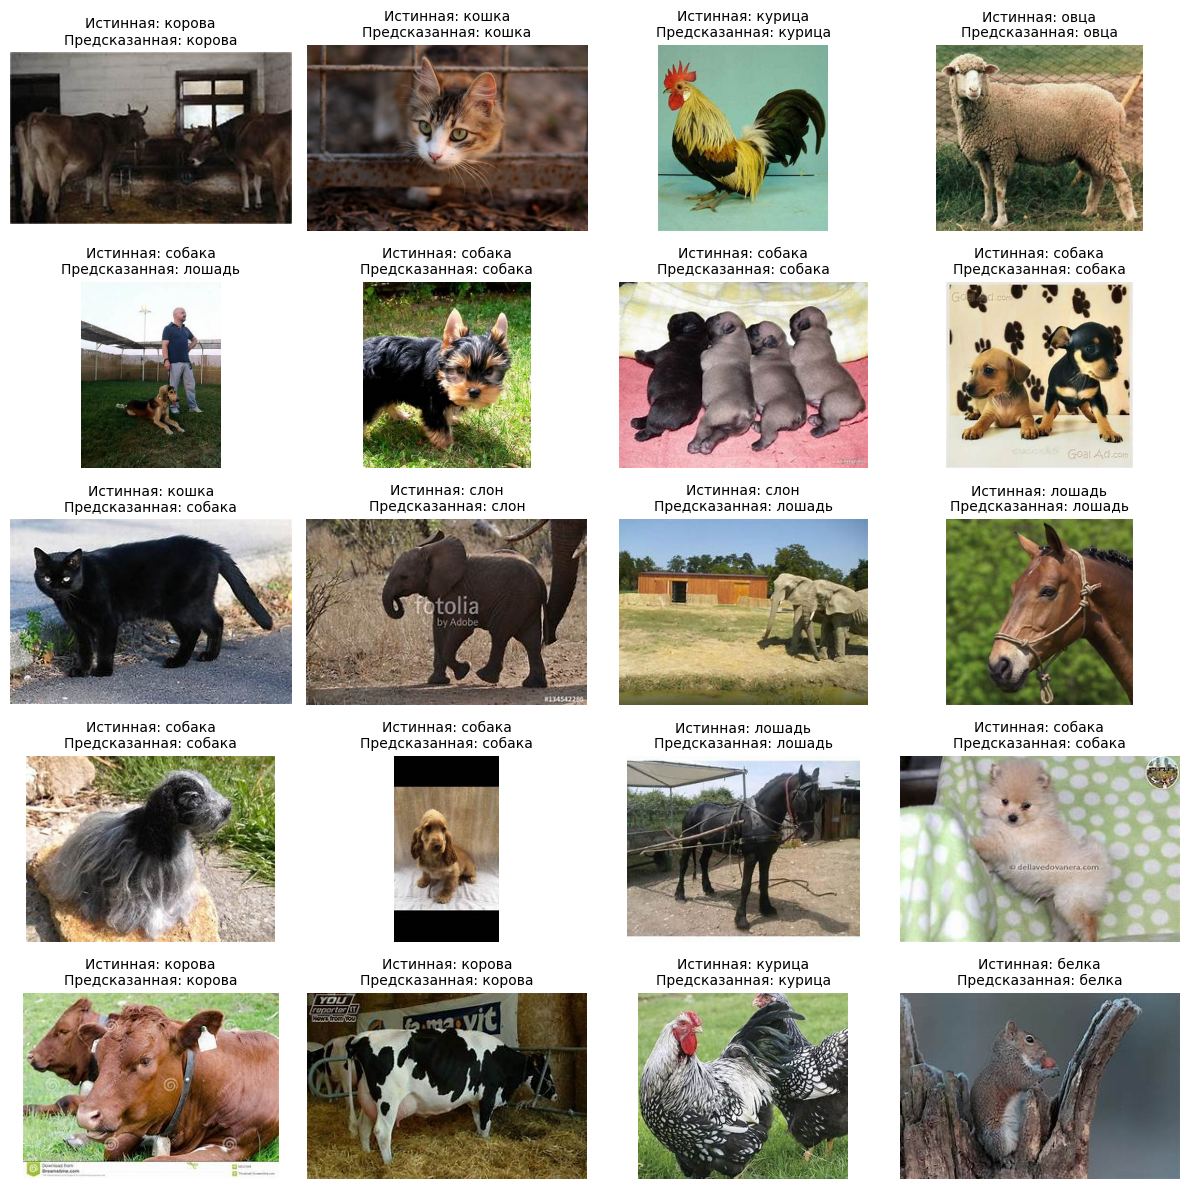

In [111]:
# Выбор случайных изображений
random_images = select_random_images(path)

# Отображение изображений с метками
display_images_with_labels(random_images, model)

ps.
Честно говоря, если бы у меня былор быь больше времени, я бы еще сделал отображение при прохождении картинки через каждый слой

Как видно модель хорошо справляется с картинками, где обьект близок и хорошо показан

In [65]:
#torch.cuda.empty_cache()

In [66]:
#del model
#del images, labels

In [67]:
#import gc
#gc.collect()